In [9]:
import numpy as np
import pandas as pd
from scipy.stats import beta, norm
import json

# ===========================
#  Z-SCORES POUR APPROX. NORMALES
# ===========================
Z_SCORES = {
    0.95: {
        "2sided": norm.ppf(1 - 0.05 / 2),   # ≈ 1.96
        "1sided": norm.ppf(0.95),           # ≈ 1.645
    },
    0.90: {
        "2sided": norm.ppf(1 - 0.10 / 2),   # ≈ 1.645
        "1sided": norm.ppf(0.90),           # ≈ 1.28
    }
}

# ===========================
#  FONCTIONS D'INTERVALLES
# ===========================

# --- Jeffreys two-sided equal-tailed (Bayesian) ---
def jeffreys_alpha2_vector(d_k, n, confidence_level=0.95):
    a_post = d_k + 0.5
    b_post = n - d_k + 0.5
    lb = beta.ppf((1 - confidence_level) / 2, a_post, b_post)
    ub = beta.ppf(1 - (1 - confidence_level) / 2, a_post, b_post)
    return lb, ub

# --- Jeffreys one-sided upper bound (ECB style) ---
def jeffreys_ecb_vector(d_k, n, confidence_level=0.95):
    a_post = d_k + 0.5
    b_post = n - d_k + 0.5
    return beta.ppf(confidence_level, a_post, b_post)

# --- Exact Clopper-Pearson two-sided ---
def exact_cp_vector(d_k, n, confidence_level=0.95):
    alpha = 1 - confidence_level
    lb = np.where(d_k == 0, 0.0, beta.ppf(alpha / 2, d_k, n - d_k + 1))
    ub = np.where(d_k == n, 1.0, beta.ppf(1 - alpha / 2, d_k + 1, n - d_k))
    return lb, ub

# --- Exact Clopper-Pearson one-sided upper bound ---
def exact_cp_unilateral_vector(d_k, n, confidence_level=0.95):
    alpha = 1 - confidence_level
    ub = np.where(d_k == n, 1.0, beta.ppf(1 - alpha, d_k + 1, n - d_k))
    return np.zeros_like(ub), ub

# --- Normal approximation two-sided ---
def approx_normal_vector(p_k, n, z_score):
    se = np.sqrt(p_k * (1 - p_k) / n)       # Standard error
    margin = z_score * se                   # Margin of error
    return p_k - margin, p_k + margin

# --- Normal approximation one-sided upper bound ---
def approx_normal_unilateral_vector(p_k, n, z_score):
    se = np.sqrt(p_k * (1 - p_k) / n)
    return np.zeros_like(p_k), p_k + z_score * se

# ===========================
#  CALIBRATION SUR UN TABLEAU DE VINTAGE
# ===========================

def apply_calib_on_vintage_df(df_vintage, confidence_level=0.95, n_round=4):
    """
    Applique les intervalles de confiance + tests de calibration sur un DataFrame de vintage.

    df_vintage doit contenir au moins les colonnes :
      - 'nb_individus' : n_k
      - 'nb_defaut'    : d_k
      - 'taux_defaut'  : p_k = d_k / n_k
      - 'pd_ttc'       : PD_k (PD de modèle à tester)

    La fonction ajoute :
      - colonnes texte des intervalles de confiance (ci_...)
      - colonnes booléennes de calibration (calib_...)
    """
    df = df_vintage.copy()

    n   = df["nb_individus"].to_numpy(dtype=int)
    d   = df["nb_defaut"].to_numpy(dtype=int)
    p_k = df["taux_defaut"].to_numpy(dtype=float)
    PD_k = df["pd_ttc"].to_numpy(dtype=float)

    # Z-scores selon le niveau de confiance
    z_2sided = Z_SCORES[confidence_level]["2sided"]
    z_1sided = Z_SCORES[confidence_level]["1sided"]

    # --- Intervalles ---
    lb_jet, ub_jet   = jeffreys_alpha2_vector(d, n, confidence_level)
    ub_ecb           = jeffreys_ecb_vector(d, n, confidence_level)

    lb_cp, ub_cp     = exact_cp_vector(d, n, confidence_level)
    _, ub_cp_uni     = exact_cp_unilateral_vector(d, n, confidence_level)

    lb_norm, ub_norm = approx_normal_vector(p_k, n, z_2sided)
    _, ub_norm_uni   = approx_normal_unilateral_vector(p_k, n, z_1sided)

    # --- Intervalles (format texte pour lecture) ---
    df["ci_jeffreys_equal_tailed"] = [
        f"[{round(a, n_round)}, {round(b, n_round)}]" for a, b in zip(lb_jet, ub_jet)
    ]
    df["ci_exact_cp"] = [
        f"[{round(a, n_round)}, {round(b, n_round)}]" for a, b in zip(lb_cp, ub_cp)
    ]
    df["ci_approx_normal"] = [
        f"[{round(a, n_round)}, {round(b, n_round)}]" for a, b in zip(lb_norm, ub_norm)
    ]

    df["ci_jeffreys_ecb"] = [f"[0, {round(b, n_round)}]" for b in ub_ecb]
    df["ci_exact_cp_uni"] = [f"[0, {round(b, n_round)}]" for b in ub_cp_uni]
    df["ci_approx_normal_uni"] = [f"[0, {round(b, n_round)}]" for b in ub_norm_uni]

    # --- Tests de calibration (booléens) ---
    # Deux côtés : PD_k doit être dans [lb, ub]
    df["calib_jeffreys_equal_tailed"] = (PD_k >= lb_jet) & (PD_k <= ub_jet)
    df["calib_exact_cp"]              = (PD_k >= lb_cp) & (PD_k <= ub_cp)
    df["calib_approx_normal"]         = (PD_k >= lb_norm) & (PD_k <= ub_norm)

    # Unilatéral : PD_k doit être < borne supérieure
    df["calib_jeffreys_ecb"]      = PD_k < ub_ecb
    df["calib_exact_cp_uni"]      = PD_k < ub_cp_uni
    df["calib_approx_normal_uni"] = PD_k < ub_norm_uni

    return df

# ===========================
#  TABLES PAR VINTAGE + PD TTC
# ===========================

def tables_par_vintage_defaut_avec_pd_ttc(
    df,
    bucket_stats_path="bucket_stats.json",
    vintage_col="vintage",
    grade_col="grade",
    default_col="default_24m",
):
    """
    Retourne un dict {vintage: DataFrame} où chaque DataFrame contient, pour chaque grade :
      - grade
      - nb_defaut
      - nb_individus
      - taux_defaut
      - pd_ttc (PD TTC issue de bucket_stats.json, section 'train', champ 'pd')

    Hypothèse : grade == bucket dans bucket_stats.json.
    """
    # Charger bucket_stats.json
    with open(bucket_stats_path, "r") as f:
        bucket_stats = json.load(f)

    # Mapping bucket -> pd (train)
    pd_map = {entry["bucket"]: entry["pd"] for entry in bucket_stats["train"]}

    # Agrégat (vintage, grade)
    table_global = (
        df
        .groupby([vintage_col, grade_col])[default_col]
        .agg(
            nb_defaut="sum",
            nb_individus="count"
        )
        .reset_index()
    )

    # Taux de défaut empirique
    table_global["taux_defaut"] = (
        table_global["nb_defaut"] / table_global["nb_individus"]
    )

    # Ajout PD TTC via le mapping bucket -> pd
    table_global["pd_ttc"] = table_global[grade_col].map(pd_map)

    # Un DataFrame par vintage (on enlève la colonne vintage)
    dict_tables = {
        vintage: sub_df.drop(columns=[vintage_col]).reset_index(drop=True)
        for vintage, sub_df in table_global.groupby(vintage_col)
    }

    return dict_tables

# ===========================
#  PIPELINE COMPLET
# ===========================

def build_vintage_tables_with_calibration(
    df,
    bucket_stats_path="bucket_stats.json",
    vintage_col="vintage",
    grade_col="grade",
    default_col="default_24m",
    confidence_level=0.95,
    n_round=4,
):
    """
    Renvoie un dict {vintage: DataFrame} avec pour chaque vintage :
      - agrégats par grade (nb_defaut, nb_individus, taux_defaut, pd_ttc)
      - intervalles de confiance (ci_...)
      - tests de calibration (calib_...)
    """
    dict_base = tables_par_vintage_defaut_avec_pd_ttc(
        df,
        bucket_stats_path=bucket_stats_path,
        vintage_col=vintage_col,
        grade_col=grade_col,
        default_col=default_col,
    )

    dict_calib = {
        vintage: apply_calib_on_vintage_df(
            sub_df,
            confidence_level=confidence_level,
            n_round=n_round
        )
        for vintage, sub_df in dict_base.items()
    }

    return dict_calib


df_val = pd.read_parquet("../data/processed/scored/validation_scored.parquet")
df_oos = pd.read_parquet("../data/processed/scored/oos_scored.parquet")
df =  pd.concat([df_val, df_oos], ignore_index=True)


res = build_vintage_tables_with_calibration(
    df,
    bucket_stats_path="../artifacts/model_from_binned/bucket_stats.json",
    vintage_col="vintage",
    grade_col="grade",
    default_col="default_12m",
    confidence_level=0.95,
    n_round=4,
)

# # Exemple : afficher la vintage 2021Q1
# print(res["2021Q1"])
# print(res["2019Q2"])


  vintage  grade                 method  calibrated  rejected  ci_width  \
0  2020Q1      1  jeffreys_equal_tailed       False      True    0.0049   
1  2020Q1      1               exact_cp       False      True    0.0053   
2  2020Q1      1          approx_normal       False      True    0.0048   
3  2020Q1      2  jeffreys_equal_tailed       False      True    0.0025   
4  2020Q1      2               exact_cp       False      True    0.0025   

    ci_lb   ci_ub    pd_ttc  taux_defaut  nb_individus  
0  0.0018  0.0067  0.000106     0.003701          2432  
1  0.0017  0.0070  0.000106     0.003701          2432  
2  0.0013  0.0061  0.000106     0.003701          2432  
3  0.0024  0.0049  0.000261     0.003488          8888  
4  0.0024  0.0049  0.000261     0.003488          8888  

=== Couverture et largeur moyenne par taille d'échantillon ===
       n_bin                 method  coverage  mean_width  n_cells
0        ≤50          approx_normal       NaN         NaN        0
1        

/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_2831/2000855070.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["n_bin", "method"])


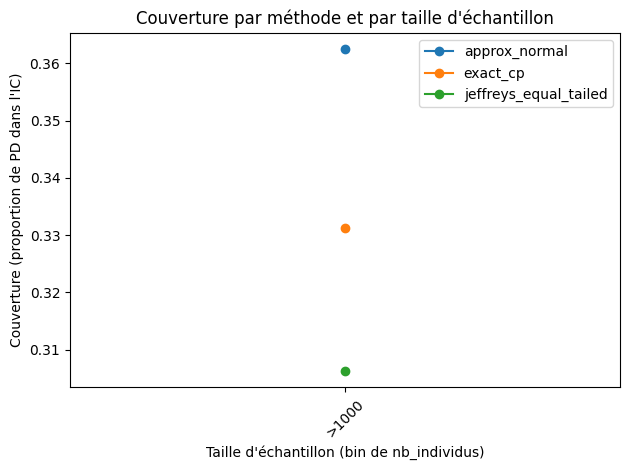


=== Couverture et largeur moyenne par niveau de PD TTC ===
        pd_bin                 method  coverage  mean_width  n_cells
0       [0,1%]          approx_normal  0.445312    0.000978      128
1       [0,1%]               exact_cp  0.406250    0.001056      128
2       [0,1%]  jeffreys_equal_tailed  0.375000    0.001002      128
3      (1%,3%]          approx_normal  0.031250    0.001687       32
4      (1%,3%]               exact_cp  0.031250    0.001703       32
5      (1%,3%]  jeffreys_equal_tailed  0.031250    0.001694       32
6     (3%,10%]          approx_normal       NaN         NaN        0
7     (3%,10%]               exact_cp       NaN         NaN        0
8     (3%,10%]  jeffreys_equal_tailed       NaN         NaN        0
9   (10%,100%]          approx_normal       NaN         NaN        0
10  (10%,100%]               exact_cp       NaN         NaN        0
11  (10%,100%]  jeffreys_equal_tailed       NaN         NaN        0


/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_2831/2000855070.py:162: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["pd_bin", "method"])


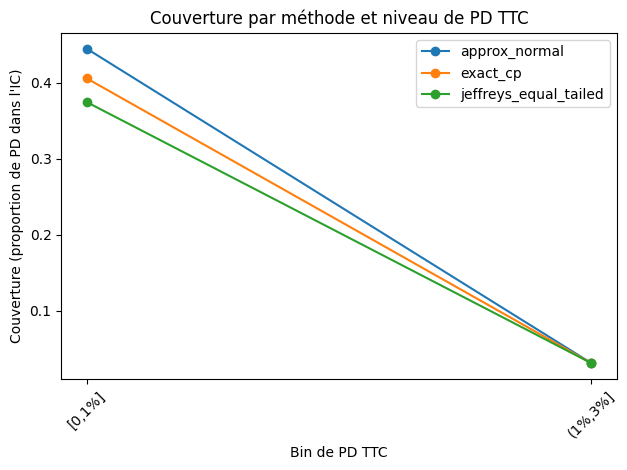

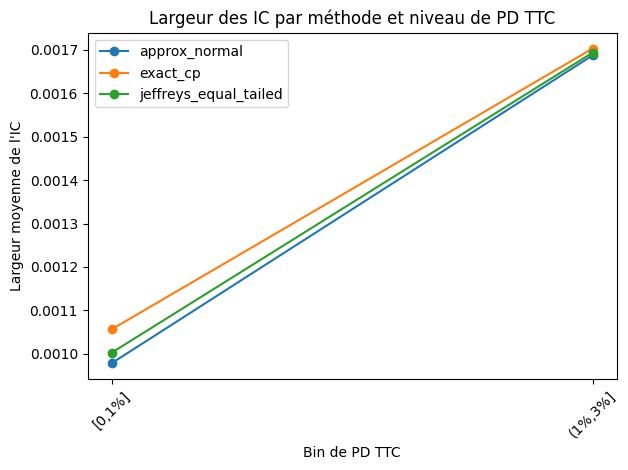


=== Matrice de similarité de Jaccard (basée sur les rejets) ===
method                 approx_normal  exact_cp  jeffreys_equal_tailed
method                                                               
approx_normal               1.000000  0.900000               0.868421
exact_cp                    0.900000  1.000000               0.963964
jeffreys_equal_tailed       0.868421  0.963964               1.000000


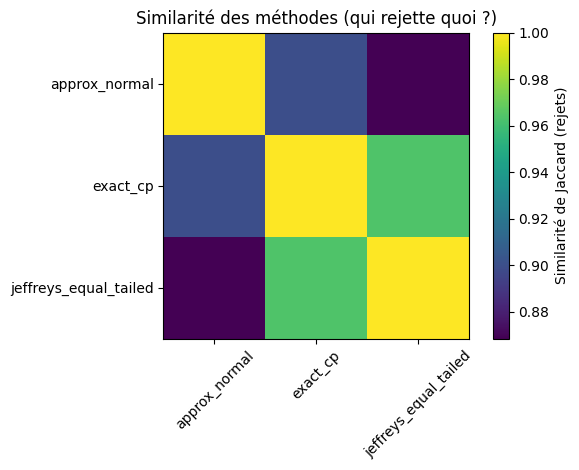


=== Résumé des z_calib par méthode ===
                         mean_z      std_z  mean_abs_z  share_outside
method                                                               
approx_normal          3.639086  13.040530    6.031035        0.62500
exact_cp               3.524768  12.988782    6.018109        0.68125
jeffreys_equal_tailed  3.520320  13.023637    6.067654        0.69375


<Figure size 640x480 with 0 Axes>

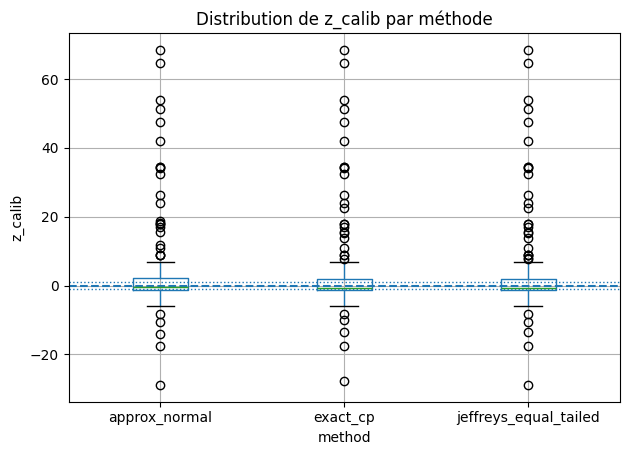


=== Différences de bornes Jeffreys - Clopper-Pearson ===
       lb_diff_jet_cp  ub_diff_jet_cp
count      160.000000      160.000000
mean         0.000011       -0.000034
std          0.000032        0.000069
min          0.000000       -0.000300
25%          0.000000        0.000000
50%          0.000000        0.000000
75%          0.000000        0.000000
max          0.000100        0.000000

=== Différences de bornes Jeffreys - Approx. Normale ===
       lb_diff_jet_norm  ub_diff_jet_norm
count        160.000000        160.000000
mean           0.000056          0.000076
std            0.000087          0.000117
min            0.000000          0.000000
25%            0.000000          0.000000
50%            0.000000          0.000000
75%            0.000100          0.000100
max            0.000500          0.000600


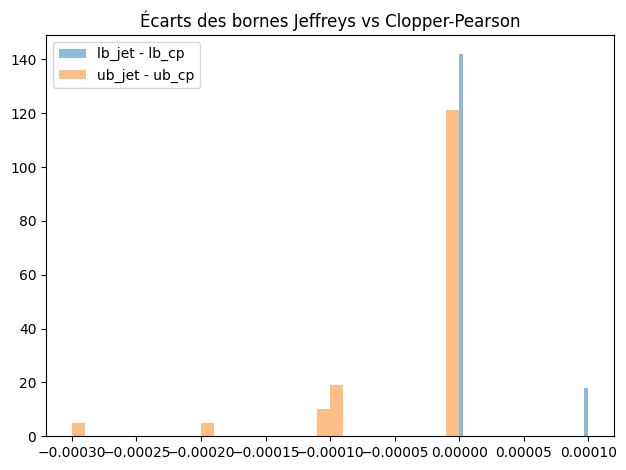

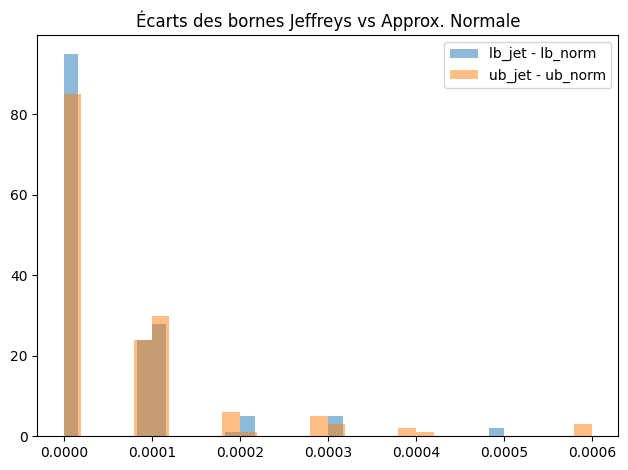

Analyses 1 à 5 exécutées (selon les flags MAKE_ANALYSIS_x).


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================================================================================
# 0. Empiler les vintages en un seul DataFrame : df_all
# ======================================================================================

def stack_vintages(dict_calib):
    frames = []
    for vintage, df_v in dict_calib.items():
        tmp = df_v.copy()
        tmp["vintage"] = vintage  # ex: "2021Q1"
        frames.append(tmp)
    df_all = pd.concat(frames, ignore_index=True)
    # ordonner les vintages
    vintages_sorted = sorted(dict_calib.keys())
    df_all["vintage"] = pd.Categorical(
        df_all["vintage"],
        ordered=True,
        categories=vintages_sorted
    )
    return df_all

df_all = stack_vintages(res)  # res = build_vintage_tables_with_calibration(...)

# ======================================================================================
# 1. Petite fonction utilitaire pour parser les chaînes de type "[0.0012, 0.0345]"
# ======================================================================================

def parse_ci(ci_str):
    if pd.isna(ci_str):
        return np.nan, np.nan
    ci_str = str(ci_str).strip()
    ci_str = ci_str.strip("[]")
    parts = [p.strip() for p in ci_str.split(",")]
    if len(parts) != 2:
        return np.nan, np.nan
    try:
        return float(parts[0]), float(parts[1])
    except ValueError:
        return np.nan, np.nan

# (optionnel) Jeffreys : bornes et largeur (si tu en as besoin ailleurs)
lb_list, ub_list = [], []
for s in df_all["ci_jeffreys_equal_tailed"]:
    lb, ub = parse_ci(s)
    lb_list.append(lb)
    ub_list.append(ub)

df_all["lb_jet"] = lb_list
df_all["ub_jet"] = ub_list
df_all["width_jet"] = df_all["ub_jet"] - df_all["lb_jet"]

# ======================================================================================
# 2. Construire un DataFrame "long" par méthode : df_long
# ======================================================================================

# Ici on ne met PLUS les colonnes rej_H0_* qui n'existent pas dans df_all.
# On ne garde que : nom méthode, colonne de calibration, colonne d'IC.
methods_2sided = [
    ("jeffreys_equal_tailed", "calib_jeffreys_equal_tailed", "ci_jeffreys_equal_tailed"),
    ("exact_cp",              "calib_exact_cp",              "ci_exact_cp"),
    ("approx_normal",         "calib_approx_normal",         "ci_approx_normal"),
]

rows = []
for _, row in df_all.iterrows():
    for name, calib_col, ci_col in methods_2sided:
        # bornes de l'IC
        lb, ub = parse_ci(row[ci_col])
        width = ub - lb if (pd.notna(lb) and pd.notna(ub)) else np.nan

        # booléen calibration : déjà dans df_all (calib_...)
        calibrated = bool(row[calib_col])
        # on définit "rejected" comme la négation de "calibrated"
        rejected = not calibrated

        rows.append({
            "vintage":      row["vintage"],
            "grade":        row["grade"],
            "method":       name,
            "calibrated":   calibrated,
            "rejected":     rejected,
            "ci_width":     width,
            "ci_lb":        lb,
            "ci_ub":        ub,
            "pd_ttc":       float(row["pd_ttc"]),
            "taux_defaut":  float(row["taux_defaut"]),
            "nb_individus": int(row["nb_individus"]),
        })

df_long = pd.DataFrame(rows)

print(df_long.head())


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# 9. Analyse 1 – Couverture et largeur par taille d'échantillon
# ============================================================================
# Prérequis : df_long existe déjà, avec au moins les colonnes :
# "method", "calibrated", "ci_width", "rejected", "nb_individus"

MAKE_ANALYSIS_1 = True

if MAKE_ANALYSIS_1:
    # Bins de taille d'échantillon (à adapter à ton contexte)
    df_long["n_bin"] = pd.cut(
        df_long["nb_individus"],
        bins=[0, 50, 100, 200, 500, 1000, np.inf],
        labels=["≤50", "51–100", "101–200", "201–500", "501–1000", ">1000"]
    )

    cov_n = (
        df_long
        .groupby(["n_bin", "method"])
        .agg(
            coverage=("calibrated", "mean"),   # 1 - taux de rejet
            mean_width=("ci_width", "mean"),
            n_cells=("rejected", "size")
        )
        .reset_index()
    )

    print("\n=== Couverture et largeur moyenne par taille d'échantillon ===")
    print(cov_n)

    # Plot : couverture vs n_bin par méthode
    plt.figure()
    for m in cov_n["method"].unique():
        sub = cov_n[cov_n["method"] == m]
        plt.plot(sub["n_bin"].astype(str), sub["coverage"], marker="o", label=m)
    plt.ylabel("Couverture (proportion de PD dans l'IC)")
    plt.xlabel("Taille d'échantillon (bin de nb_individus)")
    plt.title("Couverture par méthode et par taille d'échantillon")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================================
# 10. Analyse 2 – Couverture et largeur par niveau de PD TTC
# ============================================================================
# Prérequis : df_long avec "pd_ttc", "method", "calibrated", "ci_width", "rejected"

MAKE_ANALYSIS_2 = True

if MAKE_ANALYSIS_2:
    # Bins de PD TTC (à adapter à ton portefeuille)
    df_long["pd_bin"] = pd.cut(
        df_long["pd_ttc"],
        bins=[0, 0.01, 0.03, 0.10, 1.0],
        labels=["[0,1%]", "(1%,3%]", "(3%,10%]", "(10%,100%]"]
    )

    pd_stats = (
        df_long
        .groupby(["pd_bin", "method"])
        .agg(
            coverage=("calibrated", "mean"),
            mean_width=("ci_width", "mean"),
            n_cells=("rejected", "size")
        )
        .reset_index()
    )

    print("\n=== Couverture et largeur moyenne par niveau de PD TTC ===")
    print(pd_stats)

    # Plot couverture vs pd_bin
    plt.figure()
    for m in pd_stats["method"].unique():
        sub = pd_stats[pd_stats["method"] == m]
        plt.plot(sub["pd_bin"].astype(str), sub["coverage"], marker="o", label=m)
    plt.ylabel("Couverture (proportion de PD dans l'IC)")
    plt.xlabel("Bin de PD TTC")
    plt.title("Couverture par méthode et niveau de PD TTC")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot largeur vs pd_bin
    plt.figure()
    for m in pd_stats["method"].unique():
        sub = pd_stats[pd_stats["method"] == m]
        plt.plot(sub["pd_bin"].astype(str), sub["mean_width"], marker="o", label=m)
    plt.ylabel("Largeur moyenne de l'IC")
    plt.xlabel("Bin de PD TTC")
    plt.title("Largeur des IC par méthode et niveau de PD TTC")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================================
# 11. Analyse 3 – Similarité / désaccord des méthodes (Jaccard sur les rejets)
# ============================================================================
# Prérequis : df_long avec "vintage", "grade", "method", "rejected"

MAKE_ANALYSIS_3 = True

if MAKE_ANALYSIS_3:
    # Matrice vintage×grade × method -> rejected
    rej_matrix = df_long.pivot_table(
        index=["vintage", "grade"],
        columns="method",
        values="rejected"
    )

    methods = rej_matrix.columns
    jaccard = pd.DataFrame(index=methods, columns=methods, dtype=float)

    for m1 in methods:
        for m2 in methods:
            v1 = rej_matrix[m1].fillna(False).astype(bool)
            v2 = rej_matrix[m2].fillna(False).astype(bool)
            inter = (v1 & v2).sum()
            union = (v1 | v2).sum()
            jaccard.loc[m1, m2] = inter / union if union > 0 else np.nan

    print("\n=== Matrice de similarité de Jaccard (basée sur les rejets) ===")
    print(jaccard)

    # Heatmap
    plt.figure()
    plt.imshow(jaccard.values.astype(float), aspect="equal")
    plt.colorbar(label="Similarité de Jaccard (rejets)")
    plt.xticks(range(len(methods)), methods, rotation=45)
    plt.yticks(range(len(methods)), methods)
    plt.title("Similarité des méthodes (qui rejette quoi ?)")
    plt.tight_layout()
    plt.show()

# ============================================================================
# 12. Analyse 4 – Distance normalisée au centre de l'IC (z_calib)
# ============================================================================
# Prérequis : df_long avec "ci_width", "ci_lb", "ci_ub", "pd_ttc"

MAKE_ANALYSIS_4 = True

if MAKE_ANALYSIS_4:
    df_long["half_width"] = df_long["ci_width"] / 2
    df_long["ci_mid"] = (df_long["ci_lb"] + df_long["ci_ub"]) / 2

    # Eviter les divisions par zéro
    mask = df_long["half_width"] > 0
    df_long["z_calib"] = np.nan
    df_long.loc[mask, "z_calib"] = (
        (df_long.loc[mask, "pd_ttc"] - df_long.loc[mask, "ci_mid"]) /
        df_long.loc[mask, "half_width"]
    )

    df_long["abs_z_calib"] = df_long["z_calib"].abs()

    z_summary = (
        df_long
        .groupby("method")
        .agg(
            mean_z=("z_calib", "mean"),
            std_z=("z_calib", "std"),
            mean_abs_z=("abs_z_calib", "mean"),
            share_outside=("abs_z_calib", lambda x: np.mean(x > 1))
        )
    )

    print("\n=== Résumé des z_calib par méthode ===")
    print(z_summary)

    # Boxplot des z_calib par méthode
    plt.figure()
    df_long.boxplot(column="z_calib", by="method")
    plt.axhline(0, linestyle="--")
    plt.axhline(1, linestyle=":", linewidth=1)
    plt.axhline(-1, linestyle=":", linewidth=1)
    plt.title("Distribution de z_calib par méthode")
    plt.suptitle("")
    plt.ylabel("z_calib")
    plt.tight_layout()
    plt.show()

# ============================================================================
# 13. Analyse 5 – Écarts de bornes entre méthodes (sur df_all)
# ============================================================================
# Prérequis : df_all avec au moins les colonnes :
# "ci_jeffreys_equal_tailed", "ci_exact_cp", "ci_approx_normal"
# et parse_ci déjà défini.

MAKE_ANALYSIS_5 = True

if MAKE_ANALYSIS_5:
    # Utilitaire pour ajouter lb/ub à partir d'une colonne texte d'IC
    def add_ci_cols(df, ci_col, lb_col, ub_col):
        lbs, ubs = [], []
        for s in df[ci_col]:
            lb, ub = parse_ci(s)
            lbs.append(lb)
            ubs.append(ub)
        df[lb_col] = lbs
        df[ub_col] = ubs

    add_ci_cols(df_all, "ci_jeffreys_equal_tailed", "lb_jet_full",   "ub_jet_full")
    add_ci_cols(df_all, "ci_exact_cp",              "lb_cp",         "ub_cp")
    add_ci_cols(df_all, "ci_approx_normal",         "lb_norm",       "ub_norm")

    # Différences Jeffreys - CP et Jeffreys - Normale
    df_all["lb_diff_jet_cp"]   = df_all["lb_jet_full"] - df_all["lb_cp"]
    df_all["ub_diff_jet_cp"]   = df_all["ub_jet_full"] - df_all["ub_cp"]
    df_all["lb_diff_jet_norm"] = df_all["lb_jet_full"] - df_all["lb_norm"]
    df_all["ub_diff_jet_norm"] = df_all["ub_jet_full"] - df_all["ub_norm"]

    print("\n=== Différences de bornes Jeffreys - Clopper-Pearson ===")
    print(df_all[["lb_diff_jet_cp", "ub_diff_jet_cp"]].describe())

    print("\n=== Différences de bornes Jeffreys - Approx. Normale ===")
    print(df_all[["lb_diff_jet_norm", "ub_diff_jet_norm"]].describe())

    # Distributions des écarts Jeffreys vs CP
    plt.figure()
    plt.hist(df_all["lb_diff_jet_cp"].dropna(), bins=30, alpha=0.5, label="lb_jet - lb_cp")
    plt.hist(df_all["ub_diff_jet_cp"].dropna(), bins=30, alpha=0.5, label="ub_jet - ub_cp")
    plt.title("Écarts des bornes Jeffreys vs Clopper-Pearson")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Distributions des écarts Jeffreys vs Normale
    plt.figure()
    plt.hist(df_all["lb_diff_jet_norm"].dropna(), bins=30, alpha=0.5, label="lb_jet - lb_norm")
    plt.hist(df_all["ub_diff_jet_norm"].dropna(), bins=30, alpha=0.5, label="ub_jet - ub_norm")
    plt.title("Écarts des bornes Jeffreys vs Approx. Normale")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Analyses 1 à 5 exécutées (selon les flags MAKE_ANALYSIS_x).")




=== Stats globales par méthode ===
                       rej_rate  calib_rate  mean_width  median_width  n_cells
method                                                                        
approx_normal           0.63750     0.36250    0.001120        0.0009      160
exact_cp                0.66875     0.33125    0.001186        0.0010      160
jeffreys_equal_tailed   0.69375     0.30625    0.001141        0.0009      160


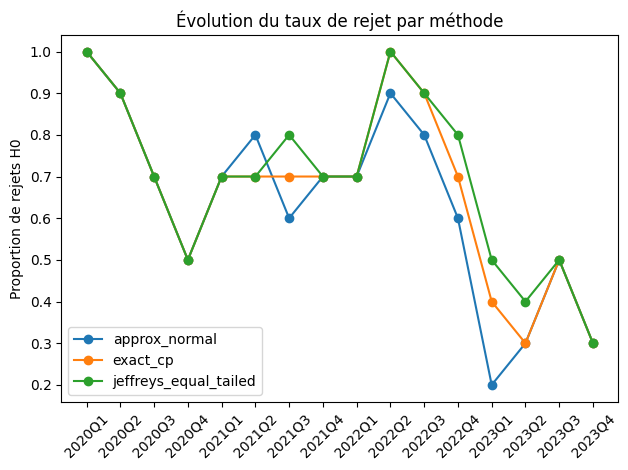

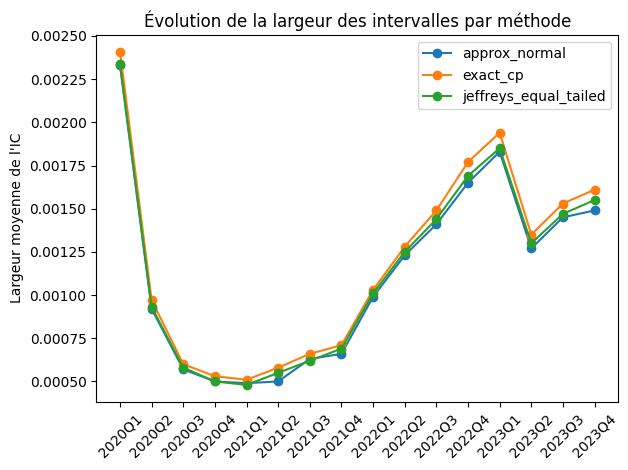

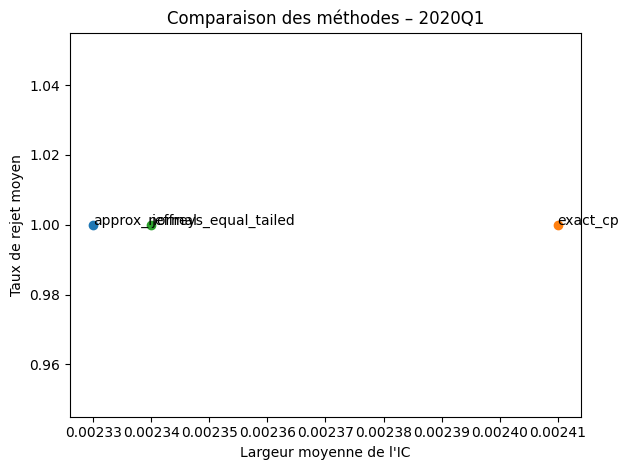

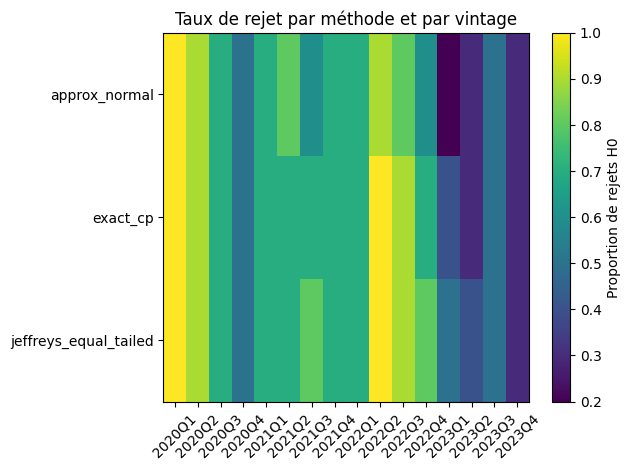

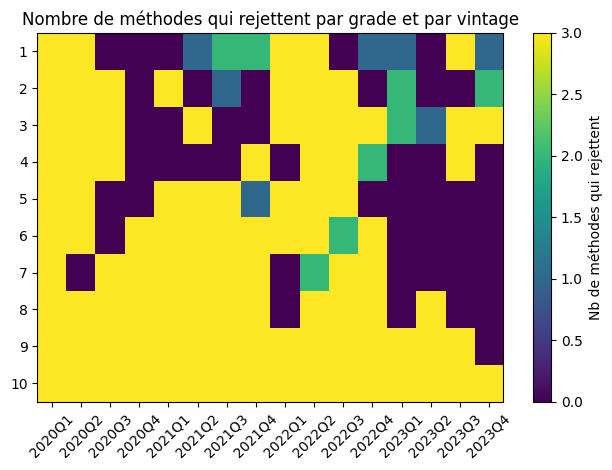

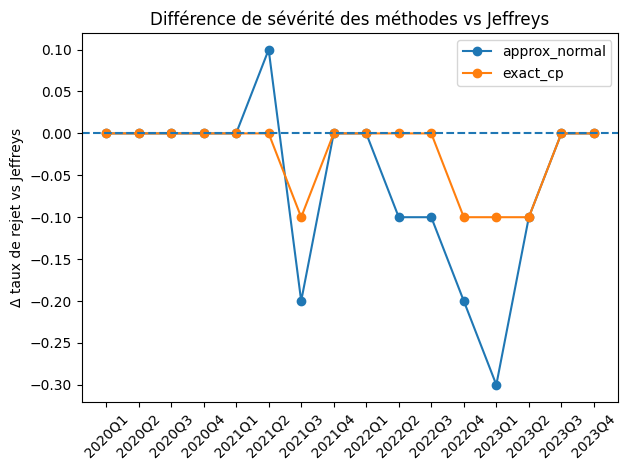

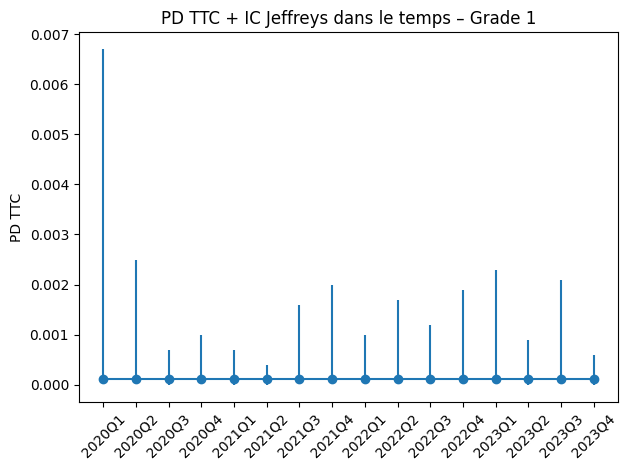


=== Calibration empirique (proportion de PD dans l'IC) et largeur par taille d'échantillon ===
       n_bin                 method  calib_rate  mean_width  n_cells
0        ≤50          approx_normal         NaN         NaN        0
1        ≤50               exact_cp         NaN         NaN        0
2        ≤50  jeffreys_equal_tailed         NaN         NaN        0
3     51–100          approx_normal         NaN         NaN        0
4     51–100               exact_cp         NaN         NaN        0
5     51–100  jeffreys_equal_tailed         NaN         NaN        0
6    101–200          approx_normal         NaN         NaN        0
7    101–200               exact_cp         NaN         NaN        0
8    101–200  jeffreys_equal_tailed         NaN         NaN        0
9    201–500          approx_normal         NaN         NaN        0
10   201–500               exact_cp         NaN         NaN        0
11   201–500  jeffreys_equal_tailed         NaN         NaN        0
12  501

/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_2831/2100850712.py:339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["n_bin", "method"])


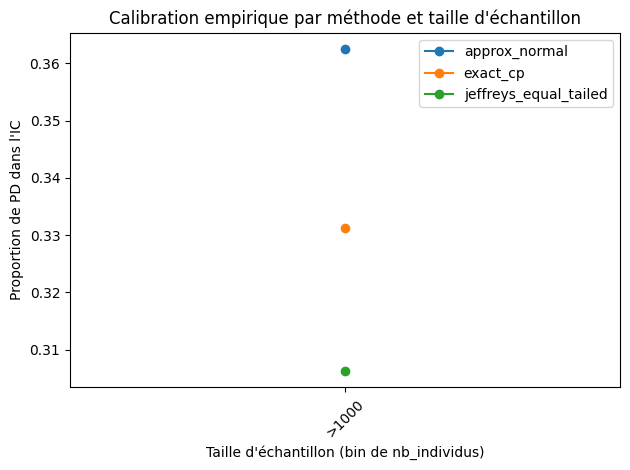


=== Calibration empirique et largeur par bin de PD TTC ===
        pd_bin                 method  calib_rate  mean_width  n_cells
0       [0,1%]          approx_normal    0.445312    0.000978      128
1       [0,1%]               exact_cp    0.406250    0.001056      128
2       [0,1%]  jeffreys_equal_tailed    0.375000    0.001002      128
3      (1%,3%]          approx_normal    0.031250    0.001687       32
4      (1%,3%]               exact_cp    0.031250    0.001703       32
5      (1%,3%]  jeffreys_equal_tailed    0.031250    0.001694       32
6     (3%,10%]          approx_normal         NaN         NaN        0
7     (3%,10%]               exact_cp         NaN         NaN        0
8     (3%,10%]  jeffreys_equal_tailed         NaN         NaN        0
9   (10%,100%]          approx_normal         NaN         NaN        0
10  (10%,100%]               exact_cp         NaN         NaN        0
11  (10%,100%]  jeffreys_equal_tailed         NaN         NaN        0


/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_2831/2100850712.py:378: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["pd_bin", "method"])


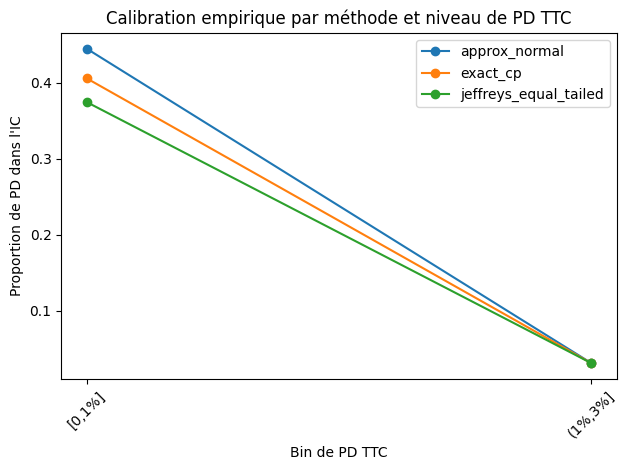


=== Similarité de Jaccard des rejets (méthode vs méthode) ===
method                 approx_normal  exact_cp  jeffreys_equal_tailed
method                                                               
approx_normal               1.000000  0.900000               0.868421
exact_cp                    0.900000  1.000000               0.963964
jeffreys_equal_tailed       0.868421  0.963964               1.000000


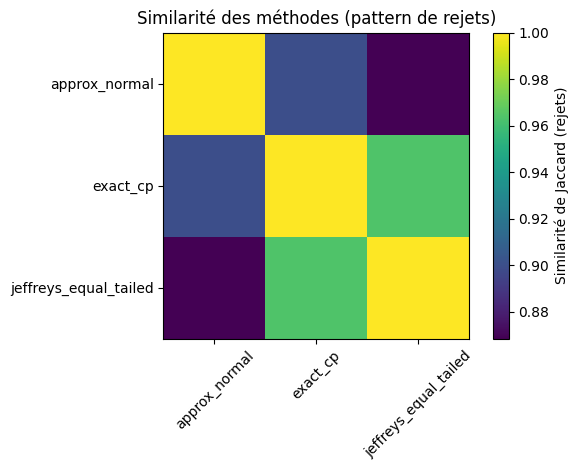


=== Résumé de z_calib par méthode ===
                         mean_z      std_z  mean_abs_z  share_outside
method                                                               
approx_normal          3.639086  13.040530    6.031035        0.62500
exact_cp               3.524768  12.988782    6.018109        0.68125
jeffreys_equal_tailed  3.520320  13.023637    6.067654        0.69375


<Figure size 640x480 with 0 Axes>

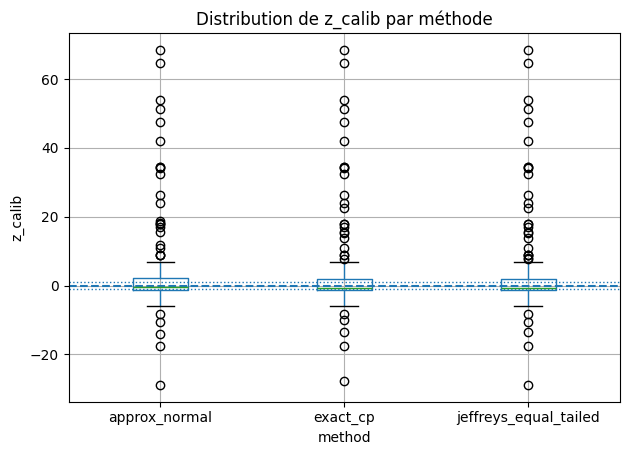


=== Différences de bornes Jeffreys - Clopper-Pearson ===
       lb_diff_jet_cp  ub_diff_jet_cp
count      160.000000      160.000000
mean         0.000011       -0.000034
std          0.000032        0.000069
min          0.000000       -0.000300
25%          0.000000        0.000000
50%          0.000000        0.000000
75%          0.000000        0.000000
max          0.000100        0.000000

=== Différences de bornes Jeffreys - Approx. Normale ===
       lb_diff_jet_norm  ub_diff_jet_norm
count        160.000000        160.000000
mean           0.000056          0.000076
std            0.000087          0.000117
min            0.000000          0.000000
25%            0.000000          0.000000
50%            0.000000          0.000000
75%            0.000100          0.000100
max            0.000500          0.000600


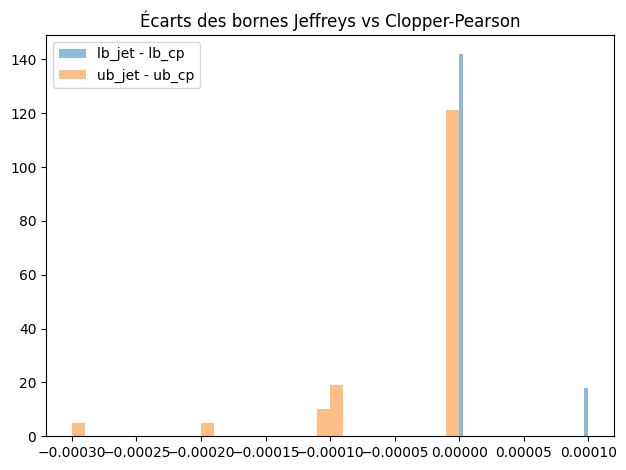

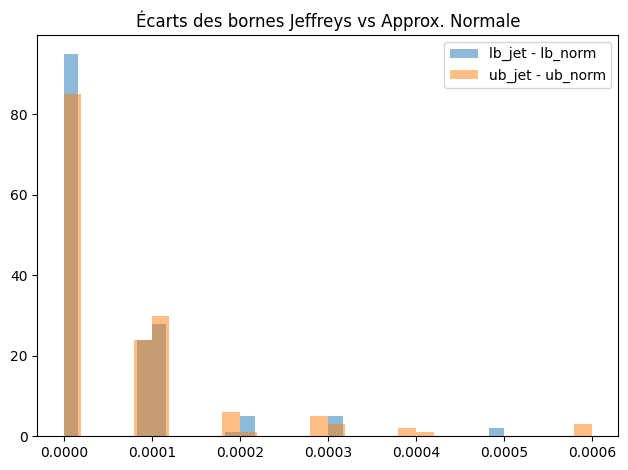


=== Stats par grade et par méthode ===
    grade                 method  rej_rate  calib_rate  mean_width  \
0       1          approx_normal    0.4375      0.5625    0.001294   
1       1               exact_cp    0.4375      0.5625    0.001662   
2       1  jeffreys_equal_tailed    0.5625      0.4375    0.001437   
3       2          approx_normal    0.4375      0.5625    0.000937   
4       2               exact_cp    0.5625      0.4375    0.001044   
5       2  jeffreys_equal_tailed    0.6250      0.3750    0.000963   
6       3          approx_normal    0.6250      0.3750    0.000913   
7       3               exact_cp    0.6875      0.3125    0.000931   
8       3  jeffreys_equal_tailed    0.7500      0.2500    0.000906   
9       4          approx_normal    0.4375      0.5625    0.000856   
10      4               exact_cp    0.5000      0.5000    0.000881   
11      4  jeffreys_equal_tailed    0.5000      0.5000    0.000837   
12      5          approx_normal    0.5625      0.

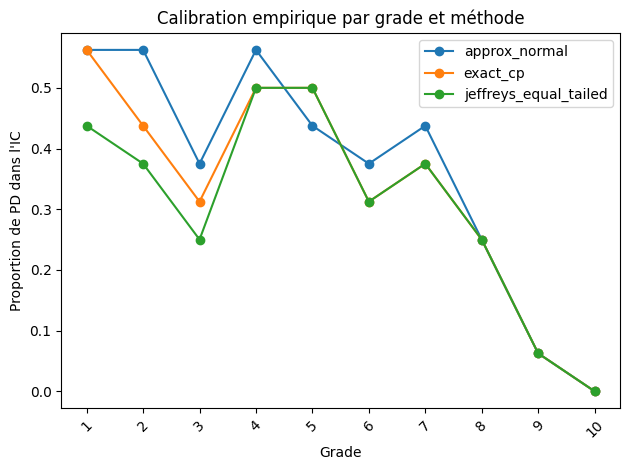


=== Patterns de désaccord par grade ===
    grade              pattern   n    freq
0       1           all_accept   5  0.3125
1       1           all_reject   5  0.3125
2       1          mixed_other   2  0.1250
3       1  only_normal_accepts   2  0.1250
4       1  only_normal_rejects   2  0.1250
6       2           all_reject   7  0.4375
5       2           all_accept   6  0.3750
8       2  only_normal_accepts   2  0.1250
7       2          mixed_other   1  0.0625
10      3           all_reject  10  0.6250
9       3           all_accept   4  0.2500
11      3          mixed_other   1  0.0625
12      3  only_normal_accepts   1  0.0625
13      4           all_accept   8  0.5000
14      4           all_reject   7  0.4375
15      4  only_normal_accepts   1  0.0625
17      5           all_reject   8  0.5000
16      5           all_accept   7  0.4375
18      5  only_normal_rejects   1  0.0625
20      6           all_reject  10  0.6250
19      6           all_accept   5  0.3125
21      6  on

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# 0. Empiler les vintages -> df_all
#    res = build_vintage_tables_with_calibration(...)
# =============================================================================

def stack_vintages(dict_calib):
    frames = []
    for vintage, df_v in dict_calib.items():
        tmp = df_v.copy()
        tmp["vintage"] = vintage  # ex: "2021Q1"
        frames.append(tmp)
    df_all_ = pd.concat(frames, ignore_index=True)

    vintages_sorted = sorted(dict_calib.keys())
    df_all_["vintage"] = pd.Categorical(
        df_all_["vintage"],
        ordered=True,
        categories=vintages_sorted
    )
    return df_all_

df_all = stack_vintages(res)

# =============================================================================
# 1. Utilitaire pour parser les chaînes d'IC "[0.0012, 0.0345]"
# =============================================================================

def parse_ci(ci_str):
    if pd.isna(ci_str):
        return np.nan, np.nan
    ci_str = str(ci_str).strip()
    ci_str = ci_str.strip("[]")
    parts = [p.strip() for p in ci_str.split(",")]
    if len(parts) != 2:
        return np.nan, np.nan
    try:
        return float(parts[0]), float(parts[1])
    except ValueError:
        return np.nan, np.nan

# Jeffreys : bornes et largeur (si besoin à part)
lb_list, ub_list = [], []
for s in df_all["ci_jeffreys_equal_tailed"]:
    lb, ub = parse_ci(s)
    lb_list.append(lb)
    ub_list.append(ub)

df_all["lb_jet"] = lb_list
df_all["ub_jet"] = ub_list
df_all["width_jet"] = df_all["ub_jet"] - df_all["lb_jet"]

# =============================================================================
# 2. Construire df_long (format "long" par méthode)
# =============================================================================

methods_2sided = [
    ("jeffreys_equal_tailed", "calib_jeffreys_equal_tailed", "ci_jeffreys_equal_tailed"),
    ("exact_cp",              "calib_exact_cp",              "ci_exact_cp"),
    ("approx_normal",         "calib_approx_normal",         "ci_approx_normal"),
]

rows = []
for _, row in df_all.iterrows():
    for name, calib_col, ci_col in methods_2sided:
        lb, ub = parse_ci(row[ci_col])
        width = ub - lb if (pd.notna(lb) and pd.notna(ub)) else np.nan

        calibrated = bool(row[calib_col])
        rejected = not calibrated  # H0: modèle calibré

        rows.append({
            "vintage":      row["vintage"],
            "grade":        row["grade"],
            "method":       name,
            "calibrated":   calibrated,
            "rejected":     rejected,
            "ci_width":     width,
            "ci_lb":        lb,
            "ci_ub":        ub,
            "pd_ttc":       float(row["pd_ttc"]),
            "taux_defaut":  float(row["taux_defaut"]),
            "nb_individus": int(row["nb_individus"]),
        })

df_long = pd.DataFrame(rows)

# =============================================================================
# 3. Stats globales par méthode (taux de rejet, largeur moyenne)
# =============================================================================

method_stats = (
    df_long
    .groupby("method")
    .agg(
        rej_rate=("rejected", "mean"),
        calib_rate=("calibrated", "mean"),
        mean_width=("ci_width", "mean"),
        median_width=("ci_width", "median"),
        n_cells=("rejected", "size")
    )
)

print("\n=== Stats globales par méthode ===")
print(method_stats)

# =============================================================================
# 4. GRAPHIQUE 1 – Taux de rejet par méthode dans le temps
# =============================================================================

MAKE_PLOT_1 = True

if MAKE_PLOT_1:
    rej_time = (
        df_long
        .groupby(["vintage", "method"])["rejected"]
        .mean()
        .reset_index()
    )

    plt.figure()
    for method in rej_time["method"].unique():
        sub = rej_time[rej_time["method"] == method]
        plt.plot(sub["vintage"], sub["rejected"], marker="o", label=method)

    plt.xticks(rotation=45)
    plt.ylabel("Proportion de rejets H0")
    plt.title("Évolution du taux de rejet par méthode")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. GRAPHIQUE 2 – Largeur moyenne des IC par méthode dans le temps
# =============================================================================

MAKE_PLOT_2 = True

if MAKE_PLOT_2:
    width_time = (
        df_long
        .groupby(["vintage", "method"])["ci_width"]
        .mean()
        .reset_index()
    )

    plt.figure()
    for method in width_time["method"].unique():
        sub = width_time[width_time["method"] == method]
        plt.plot(sub["vintage"], sub["ci_width"], marker="o", label=method)

    plt.xticks(rotation=45)
    plt.ylabel("Largeur moyenne de l'IC")
    plt.title("Évolution de la largeur des intervalles par méthode")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 6. GRAPHIQUE 3 – Frontière efficacité : largeur vs taux de rejet (pour un vintage)
# =============================================================================

MAKE_PLOT_3 = True

if MAKE_PLOT_3:
    if isinstance(df_long["vintage"].dtype, pd.CategoricalDtype):
        vintages_disponibles = list(df_long["vintage"].cat.categories)
    else:
        vintages_disponibles = sorted(df_long["vintage"].unique())

    vintage_to_plot = vintages_disponibles[0]  # à changer si besoin

    sub_v = df_long[df_long["vintage"] == vintage_to_plot]

    summary_v = (
        sub_v
        .groupby("method")
        .agg(
            mean_rej=("rejected", "mean"),
            mean_width=("ci_width", "mean")
        )
        .reset_index()
    )

    plt.figure()
    for _, r in summary_v.iterrows():
        plt.scatter(r["mean_width"], r["mean_rej"])
        plt.text(r["mean_width"], r["mean_rej"], r["method"])

    plt.xlabel("Largeur moyenne de l'IC")
    plt.ylabel("Taux de rejet moyen")
    plt.title(f"Comparaison des méthodes – {vintage_to_plot}")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 7. GRAPHIQUE 4 – Heatmap méthode × vintage du taux de rejet
# =============================================================================

MAKE_PLOT_4 = True

if MAKE_PLOT_4:
    rej_heat = (
        df_long
        .groupby(["method", "vintage"])["rejected"]
        .mean()
        .unstack("vintage")
    )

    plt.figure()
    plt.imshow(rej_heat.values, aspect="auto")
    plt.colorbar(label="Proportion de rejets H0")
    plt.yticks(range(len(rej_heat.index)), rej_heat.index)
    plt.xticks(range(len(rej_heat.columns)), rej_heat.columns, rotation=45)
    plt.title("Taux de rejet par méthode et par vintage")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 8. GRAPHIQUE 5 – Heatmap désaccord : nb de méthodes qui rejettent (vintage × grade)
# =============================================================================

MAKE_PLOT_5 = True

if MAKE_PLOT_5:
    disagreement = (
        df_long
        .groupby(["vintage", "grade"])["rejected"]
        .sum()
        .reset_index(name="nb_methods_reject")
    )

    pivot_dis = disagreement.pivot(index="grade", columns="vintage", values="nb_methods_reject")

    plt.figure()
    plt.imshow(pivot_dis.values, aspect="auto")
    plt.colorbar(label="Nb de méthodes qui rejettent")
    plt.yticks(range(len(pivot_dis.index)), pivot_dis.index)
    plt.xticks(range(len(pivot_dis.columns)), pivot_dis.columns, rotation=45)
    plt.title("Nombre de méthodes qui rejettent par grade et par vintage")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 9. GRAPHIQUE 6 – Δ taux de rejet vs Jeffreys (méthode baseline)
# =============================================================================

MAKE_PLOT_6 = True

if MAKE_PLOT_6:
    rej_time = (
        df_long
        .groupby(["vintage", "method"])["rejected"]
        .mean()
        .reset_index()
    )

    rej_pivot = rej_time.pivot(index="vintage", columns="method", values="rejected")

    baseline = "jeffreys_equal_tailed"
    if baseline in rej_pivot.columns:
        diff_from_base = rej_pivot.sub(rej_pivot[baseline], axis=0)

        plt.figure()
        for method in diff_from_base.columns:
            if method == baseline:
                continue
            plt.plot(diff_from_base.index, diff_from_base[method], marker="o", label=method)

        plt.axhline(0, linestyle="--")
        plt.xticks(rotation=45)
        plt.ylabel("Δ taux de rejet vs Jeffreys")
        plt.title("Différence de sévérité des méthodes vs Jeffreys")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Méthode baseline 'jeffreys_equal_tailed' introuvable dans rej_pivot.columns")

# =============================================================================
# 10. GRAPHIQUE 7 – PD TTC + IC Jeffreys dans le temps pour un grade donné
# =============================================================================

MAKE_PLOT_7 = True

if MAKE_PLOT_7:
    grades_disponibles = sorted(df_all["grade"].unique().tolist())
    grade_to_plot = grades_disponibles[0]  # à changer si besoin

    df_g = df_all[df_all["grade"] == grade_to_plot].copy()
    df_g = df_g.sort_values("vintage")

    y = df_g["pd_ttc"].to_numpy(dtype=float)
    lb = df_g["lb_jet"].to_numpy(dtype=float)
    ub = df_g["ub_jet"].to_numpy(dtype=float)

    # Si lb/ub sont NaN, on les remplace par y => pas de barre d'erreur
    lb = np.where(np.isnan(lb), y, lb)
    ub = np.where(np.isnan(ub), y, ub)

    # Distances à la borne inf / sup (doivent être >= 0 pour matplotlib)
    lower_err = np.maximum(0.0, y - lb)
    upper_err = np.maximum(0.0, ub - y)

    yerr = np.vstack([lower_err, upper_err])

    plt.figure()
    plt.errorbar(
        df_g["vintage"],
        y,
        yerr=yerr,
        fmt="o-",
    )
    plt.xticks(rotation=45)
    plt.ylabel("PD TTC")
    plt.title(f"PD TTC + IC Jeffreys dans le temps – Grade {grade_to_plot}")
    plt.tight_layout()
    plt.show()


# =============================================================================
# 11. Analyse – Couverture empirique & largeur par taille d'échantillon (descriptif)
# =============================================================================

MAKE_ANALYSIS_1 = True

if MAKE_ANALYSIS_1:
    df_long["n_bin"] = pd.cut(
        df_long["nb_individus"],
        bins=[0, 50, 100, 200, 500, 1000, np.inf],
        labels=["≤50", "51–100", "101–200", "201–500", "501–1000", ">1000"]
    )

    cov_n = (
        df_long
        .groupby(["n_bin", "method"])
        .agg(
            calib_rate=("calibrated", "mean"),
            mean_width=("ci_width", "mean"),
            n_cells=("rejected", "size")
        )
        .reset_index()
    )

    print("\n=== Calibration empirique (proportion de PD dans l'IC) et largeur par taille d'échantillon ===")
    print(cov_n)

    plt.figure()
    for m in cov_n["method"].unique():
        sub = cov_n[cov_n["method"] == m]
        plt.plot(sub["n_bin"].astype(str), sub["calib_rate"], marker="o", label=m)
    plt.ylabel("Proportion de PD dans l'IC")
    plt.xlabel("Taille d'échantillon (bin de nb_individus)")
    plt.title("Calibration empirique par méthode et taille d'échantillon")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 12. Analyse – Comportement par niveau de PD TTC (descriptif)
# =============================================================================

MAKE_ANALYSIS_2 = True

if MAKE_ANALYSIS_2:
    df_long["pd_bin"] = pd.cut(
        df_long["pd_ttc"],
        bins=[0, 0.01, 0.03, 0.10, 1.0],
        labels=["[0,1%]", "(1%,3%]", "(3%,10%]", "(10%,100%]"]
    )

    pd_stats = (
        df_long
        .groupby(["pd_bin", "method"])
        .agg(
            calib_rate=("calibrated", "mean"),
            mean_width=("ci_width", "mean"),
            n_cells=("rejected", "size")
        )
        .reset_index()
    )

    print("\n=== Calibration empirique et largeur par bin de PD TTC ===")
    print(pd_stats)

    plt.figure()
    for m in pd_stats["method"].unique():
        sub = pd_stats[pd_stats["method"] == m]
        plt.plot(sub["pd_bin"].astype(str), sub["calib_rate"], marker="o", label=m)
    plt.ylabel("Proportion de PD dans l'IC")
    plt.xlabel("Bin de PD TTC")
    plt.title("Calibration empirique par méthode et niveau de PD TTC")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 13. Analyse – Similarité / désaccord (Jaccard sur les rejets)
# =============================================================================

MAKE_ANALYSIS_3 = True

if MAKE_ANALYSIS_3:
    rej_matrix = df_long.pivot_table(
        index=["vintage", "grade"],
        columns="method",
        values="rejected"
    )

    methods = rej_matrix.columns
    jaccard = pd.DataFrame(index=methods, columns=methods, dtype=float)

    for m1 in methods:
        for m2 in methods:
            v1 = rej_matrix[m1].fillna(False).astype(bool)
            v2 = rej_matrix[m2].fillna(False).astype(bool)
            inter = (v1 & v2).sum()
            union = (v1 | v2).sum()
            jaccard.loc[m1, m2] = inter / union if union > 0 else np.nan

    print("\n=== Similarité de Jaccard des rejets (méthode vs méthode) ===")
    print(jaccard)

    plt.figure()
    plt.imshow(jaccard.values.astype(float), aspect="equal")
    plt.colorbar(label="Similarité de Jaccard (rejets)")
    plt.xticks(range(len(methods)), methods, rotation=45)
    plt.yticks(range(len(methods)), methods)
    plt.title("Similarité des méthodes (pattern de rejets)")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 14. Analyse – Distance normalisée au centre de l'IC (z_calib)
# =============================================================================

MAKE_ANALYSIS_4 = True

if MAKE_ANALYSIS_4:
    df_long["half_width"] = df_long["ci_width"] / 2
    df_long["ci_mid"] = (df_long["ci_lb"] + df_long["ci_ub"]) / 2

    mask = df_long["half_width"] > 0
    df_long["z_calib"] = np.nan
    df_long.loc[mask, "z_calib"] = (
        (df_long.loc[mask, "pd_ttc"] - df_long.loc[mask, "ci_mid"]) /
        df_long.loc[mask, "half_width"]
    )

    df_long["abs_z_calib"] = df_long["z_calib"].abs()

    z_summary = (
        df_long
        .groupby("method")
        .agg(
            mean_z=("z_calib", "mean"),
            std_z=("z_calib", "std"),
            mean_abs_z=("abs_z_calib", "mean"),
            share_outside=("abs_z_calib", lambda x: np.mean(x > 1))
        )
    )

    print("\n=== Résumé de z_calib par méthode ===")
    print(z_summary)

    plt.figure()
    df_long.boxplot(column="z_calib", by="method")
    plt.axhline(0, linestyle="--")
    plt.axhline(1, linestyle=":", linewidth=1)
    plt.axhline(-1, linestyle=":", linewidth=1)
    plt.title("Distribution de z_calib par méthode")
    plt.suptitle("")
    plt.ylabel("z_calib")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 15. Analyse – Écarts de bornes entre Jeffreys, CP et Normale
# =============================================================================

MAKE_ANALYSIS_5 = True

if MAKE_ANALYSIS_5:
    def add_ci_cols(df, ci_col, lb_col, ub_col):
        lbs, ubs = [], []
        for s in df[ci_col]:
            lb, ub = parse_ci(s)
            lbs.append(lb)
            ubs.append(ub)
        df[lb_col] = lbs
        df[ub_col] = ubs

    add_ci_cols(df_all, "ci_jeffreys_equal_tailed", "lb_jet_full",   "ub_jet_full")
    add_ci_cols(df_all, "ci_exact_cp",              "lb_cp",         "ub_cp")
    add_ci_cols(df_all, "ci_approx_normal",         "lb_norm",       "ub_norm")

    df_all["lb_diff_jet_cp"]   = df_all["lb_jet_full"] - df_all["lb_cp"]
    df_all["ub_diff_jet_cp"]   = df_all["ub_jet_full"] - df_all["ub_cp"]
    df_all["lb_diff_jet_norm"] = df_all["lb_jet_full"] - df_all["lb_norm"]
    df_all["ub_diff_jet_norm"] = df_all["ub_jet_full"] - df_all["ub_norm"]

    print("\n=== Différences de bornes Jeffreys - Clopper-Pearson ===")
    print(df_all[["lb_diff_jet_cp", "ub_diff_jet_cp"]].describe())

    print("\n=== Différences de bornes Jeffreys - Approx. Normale ===")
    print(df_all[["lb_diff_jet_norm", "ub_diff_jet_norm"]].describe())

    plt.figure()
    plt.hist(df_all["lb_diff_jet_cp"].dropna(), bins=30, alpha=0.5, label="lb_jet - lb_cp")
    plt.hist(df_all["ub_diff_jet_cp"].dropna(), bins=30, alpha=0.5, label="ub_jet - ub_cp")
    plt.title("Écarts des bornes Jeffreys vs Clopper-Pearson")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(df_all["lb_diff_jet_norm"].dropna(), bins=30, alpha=0.5, label="lb_jet - lb_norm")
    plt.hist(df_all["ub_diff_jet_norm"].dropna(), bins=30, alpha=0.5, label="ub_jet - ub_norm")
    plt.title("Écarts des bornes Jeffreys vs Approx. Normale")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 16. ANALYSE EMPIRIQUE PAR GRADE – Stats par grade × méthode
# =============================================================================

MAKE_GRADE_ANALYSIS_1 = True

if MAKE_GRADE_ANALYSIS_1:
    grade_method_stats = (
        df_long
        .groupby(["grade", "method"])
        .agg(
            rej_rate     = ("rejected", "mean"),
            calib_rate   = ("calibrated", "mean"),
            mean_width   = ("ci_width", "mean"),
            median_width = ("ci_width", "median"),
            n_cells      = ("rejected", "size"),
            mean_pd      = ("pd_ttc", "mean"),
            mean_n       = ("nb_individus", "mean")
        )
        .reset_index()
    )

    print("\n=== Stats par grade et par méthode ===")
    print(grade_method_stats.sort_values(["grade", "method"]))

    # Courbe calib_rate par grade et méthode
    plt.figure()
    for m in grade_method_stats["method"].unique():
        sub = grade_method_stats[grade_method_stats["method"] == m]
        plt.plot(sub["grade"].astype(str), sub["calib_rate"], marker="o", label=m)

    plt.ylabel("Proportion de PD dans l'IC")
    plt.xlabel("Grade")
    plt.title("Calibration empirique par grade et méthode")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 17. ANALYSE EMPIRIQUE PAR GRADE – Patterns de désaccord entre méthodes
# =============================================================================

MAKE_GRADE_ANALYSIS_2 = True

if MAKE_GRADE_ANALYSIS_2:
    rej_matrix_grade = df_long.pivot_table(
        index=["vintage", "grade"],
        columns="method",
        values="rejected"
    )

    rej_matrix_grade = rej_matrix_grade.fillna(False).astype(bool)

    def pattern(row):
        r = row.to_dict()
        # Hypothèse : les trois méthodes sont présentes
        # approx_normal, exact_cp, jeffreys_equal_tailed
        vals = list(r.values())
        if all(vals):
            return "all_reject"
        if not any(vals):
            return "all_accept"

        # cas où seule la normale accepte :
        if (not r.get("approx_normal", False)) and r.get("exact_cp", False) and r.get("jeffreys_equal_tailed", False):
            return "only_normal_accepts"

        # cas où seule la normale rejette :
        if r.get("approx_normal", False) and (not r.get("exact_cp", False)) and (not r.get("jeffreys_equal_tailed", False)):
            return "only_normal_rejects"

        # autres mélanges possibles :
        return "mixed_other"

    patterns = rej_matrix_grade.apply(pattern, axis=1).rename("pattern").reset_index()

    pattern_by_grade = (
        patterns
        .groupby(["grade", "pattern"])
        .size()
        .reset_index(name="n")
    )
    pattern_by_grade["freq"] = (
        pattern_by_grade["n"] /
        pattern_by_grade.groupby("grade")["n"].transform("sum")
    )

    print("\n=== Patterns de désaccord par grade ===")
    print(pattern_by_grade.sort_values(["grade", "freq"], ascending=[True, False]))

    # Focus sur les cas où seule la normale accepte
    borderline = patterns.merge(df_long, on=["vintage", "grade"])
    only_norm = borderline[borderline["pattern"] == "only_normal_accepts"]

    if not only_norm.empty:
        print("\n=== Cas où seule la normale accepte (agrégé par grade) ===")
        print(
            only_norm.groupby("grade")
            .agg(
                n_cells=("pd_ttc", "size"),
                mean_pd=("pd_ttc", "mean"),
                mean_taux_defaut=("taux_defaut", "mean"),
                mean_n=("nb_individus", "mean")
            )
            .reset_index()
        )
    else:
        print("\nAucun cas 'only_normal_accepts' trouvé.")

# =============================================================================
# 18. ANALYSE EMPIRIQUE PAR GRADE – z_calib par grade × méthode
# =============================================================================

MAKE_GRADE_ANALYSIS_3 = True

if MAKE_GRADE_ANALYSIS_3:
    if "z_calib" not in df_long.columns:
        # Au cas où MAKE_ANALYSIS_4 aurait été mis à False
        df_long["half_width"] = df_long["ci_width"] / 2
        df_long["ci_mid"] = (df_long["ci_lb"] + df_long["ci_ub"]) / 2

        mask = df_long["half_width"] > 0
        df_long["z_calib"] = np.nan
        df_long.loc[mask, "z_calib"] = (
            (df_long.loc[mask, "pd_ttc"] - df_long.loc[mask, "ci_mid"]) /
            df_long.loc[mask, "half_width"]
        )
        df_long["abs_z_calib"] = df_long["z_calib"].abs()

    z_by_grade = (
        df_long
        .groupby(["grade", "method"])
        .agg(
            mean_z      = ("z_calib", "mean"),
            std_z       = ("z_calib", "std"),
            mean_abs_z  = ("abs_z_calib", "mean"),
            share_outside = ("abs_z_calib", lambda x: np.mean(x > 1)),
            n_cells     = ("z_calib", "size")
        )
        .reset_index()
    )

    print("\n=== z_calib par grade et méthode ===")
    print(z_by_grade.sort_values(["grade", "method"]))

print("\nTous les tableaux et graphiques descriptifs ont été générés (selon les flags MAKE_* et MAKE_GRADE_ANALYSIS_*).")


/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_2831/3701668739.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_g["vintage"].unique(), rotation=45)
/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_2831/3701668739.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_g["vintage"].unique(), rotation=45)
/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_2831/3701668739.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_g["vintage"].unique(), rotation=45)
/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_2831/3701668739.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or

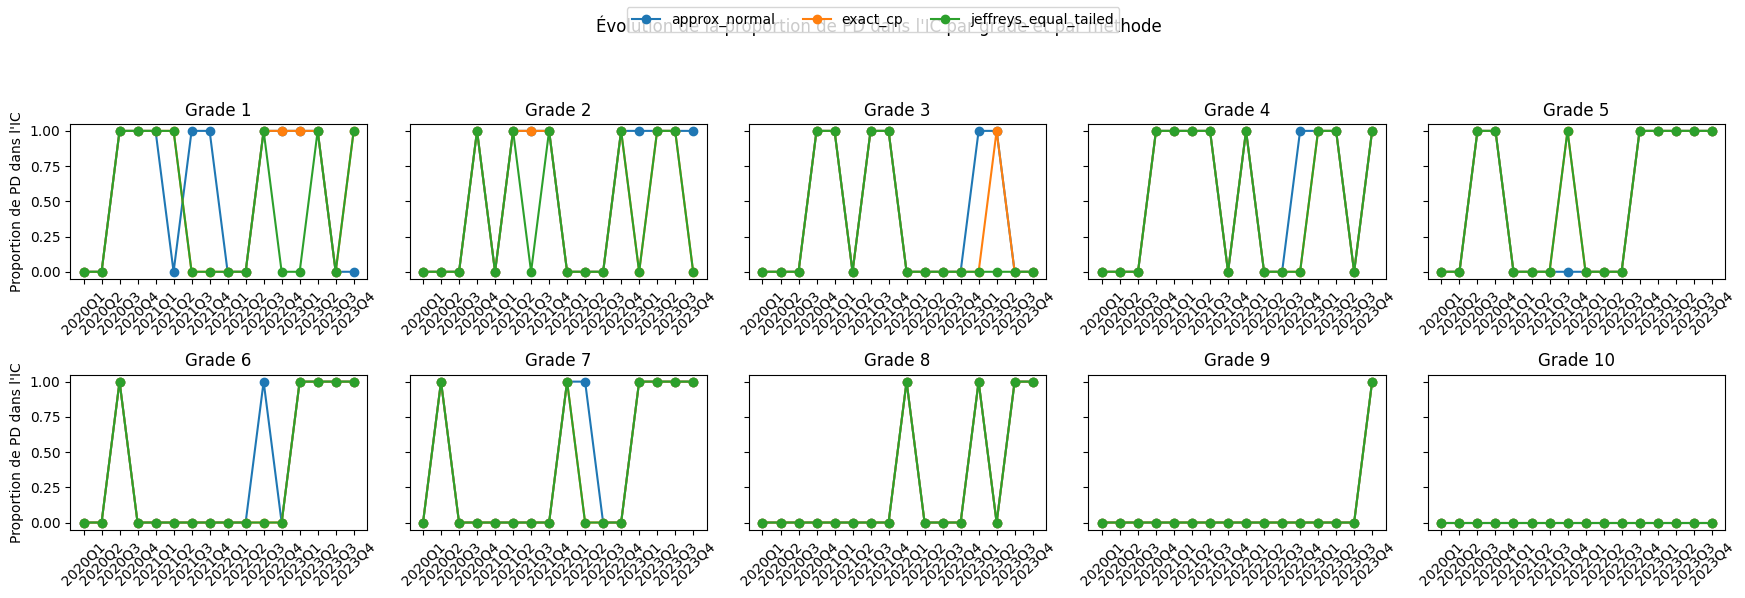

In [12]:
import math
import matplotlib.pyplot as plt

# =============================================================================
# Évolution de la proportion de PD dans l'IC (calib_rate) par grade et par méthode
# =============================================================================

# 1. Proportion de PD dans l'IC par (grade, vintage, method)
calib_time = (
    df_long
    .groupby(["grade", "vintage", "method"])["calibrated"]
    .mean()
    .reset_index(name="calib_rate")
)

# Pour garder l'ordre des vintages si c'est un catégoriel ordonné
if isinstance(df_long["vintage"].dtype, pd.CategoricalDtype):
    vintages_order = list(df_long["vintage"].cat.categories)
    calib_time["vintage"] = pd.Categorical(
        calib_time["vintage"],
        categories=vintages_order,
        ordered=True
    )

grades = sorted(df_long["grade"].unique())
methods = calib_time["method"].unique()

n_grades = len(grades)
ncols = 5  # par ex. 5 colonnes pour afficher les 10 grades en 2 lignes
nrows = math.ceil(n_grades / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3.0 * nrows), sharey=True)
axes = axes.flatten()

for i, g in enumerate(grades):
    ax = axes[i]
    sub_g = calib_time[calib_time["grade"] == g].copy()
    sub_g = sub_g.sort_values("vintage")

    for m in methods:
        sub_m = sub_g[sub_g["method"] == m]
        if sub_m.empty:
            continue
        ax.plot(
            sub_m["vintage"],
            sub_m["calib_rate"],
            marker="o",
            label=m
        )

    ax.set_title(f"Grade {g}")
    ax.set_xticklabels(sub_g["vintage"].unique(), rotation=45)
    if i % ncols == 0:
        ax.set_ylabel("Proportion de PD dans l'IC")

# Supprimer les axes inutilisés si nb de grades < nrows*ncols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Légende globale (une seule)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(methods))

fig.suptitle("Évolution de la proportion de PD dans l'IC par grade et par méthode")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


Notebook CWD: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/notebook
Detected ROOT: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration
sys.path[0]: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration
VAL exists: True
OOS exists: True
BUCKET exists: True


,vintage,method,share_grades_rejected,share_exposure_rejected,avg_len_weighted,n_total
0,2022Q1,cp,1.0,1.000000,0.001191,583714
1,2022Q1,jeffreys,1.0,1.000000,0.001173,583714
2,2022Q1,normal,1.0,1.000000,0.001173,583714
3,2022Q2,cp,1.0,1.000000,0.001499,437882
4,2022Q2,jeffreys,1.0,1.000000,0.001476,437882
5,2022Q2,normal,1.0,1.000000,0.001475,437882
6,2022Q3,cp,0.9,0.971979,0.001793,336779
7,2022Q3,jeffreys,0.9,0.971979,0.001763,336779
8,2022Q3,normal,0.9,0.971979,0.001762,336779
9,2022Q4,cp,0.7,0.839143,0.002170,222384


,vintage,grade,n,d,pd_hat,pd_obs,pd_ttc,lb_jeffreys,ub_jeffreys,len_jeffreys,reject_jeffreys,lb_cp,ub_cp,len_cp,reject_cp,lb_normal,ub_normal,len_normal,reject_normal
0,2022Q1,1,38474,29,0.000177,0.000754,0.000177,0.000515,0.001067,0.000552,True,0.000505,0.001082,0.000577,True,0.000480,0.001028,0.000548,True
1,2022Q1,2,54829,49,0.000503,0.000894,0.000503,0.000669,0.001171,0.000502,True,0.000661,0.001181,0.000520,True,0.000644,0.001144,0.000500,True
2,2022Q1,3,63538,108,0.001014,0.0017,0.001014,0.001402,0.002043,0.000642,True,0.001395,0.002052,0.000657,True,0.001379,0.002020,0.000641,True
3,2022Q1,4,66244,171,0.001674,0.002581,0.001674,0.002216,0.002990,0.000774,True,0.002209,0.002998,0.000789,True,0.002195,0.002968,0.000773,True
4,2022Q1,5,78144,261,0.002746,0.00334,0.002746,0.002954,0.003763,0.000810,True,0.002948,0.003770,0.000822,True,0.002935,0.003745,0.000809,True
5,2022Q1,6,77574,442,0.004331,0.005698,0.004331,0.005186,0.006246,0.001060,True,0.005180,0.006253,0.001073,True,0.005168,0.006227,0.001059,True
6,2022Q1,7,82016,667,0.007040,0.008133,0.007040,0.007535,0.008765,0.001230,True,0.007529,0.008771,0.001242,True,0.007518,0.008747,0.001229,True
7,2022Q1,8,64599,768,0.010861,0.011889,0.010861,0.011075,0.012747,0.001672,True,0.011067,0.012755,0.001687,True,0.011053,0.012725,0.001672,True
8,2022Q1,9,45130,865,0.017486,0.019167,0.017486,0.017933,0.020463,0.002530,True,0.017922,0.020474,0.002553,True,0.017902,0.020432,0.002530,True
9,2022Q1,10,13166,384,0.033981,0.029166,0.033981,0.026394,0.032145,0.005750,True,0.026358,0.032184,0.005826,True,0.026292,0.032040,0.005749,True


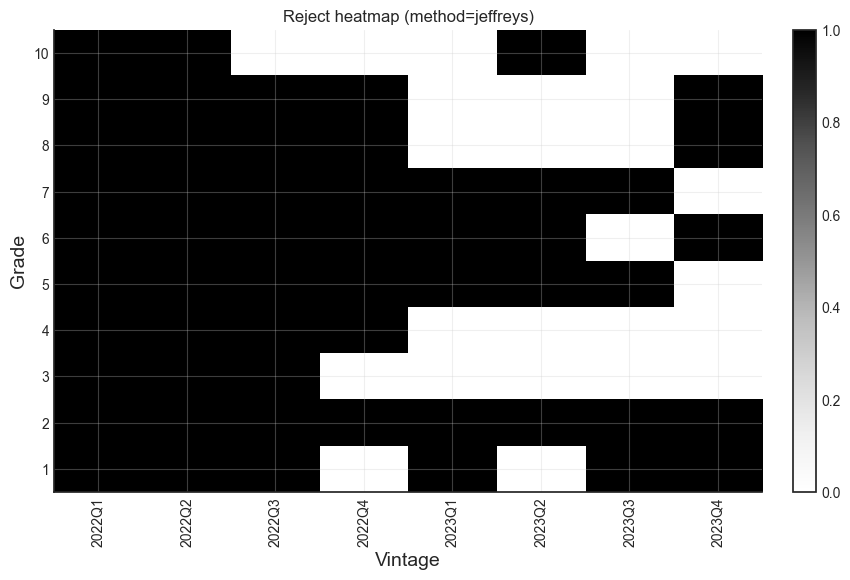

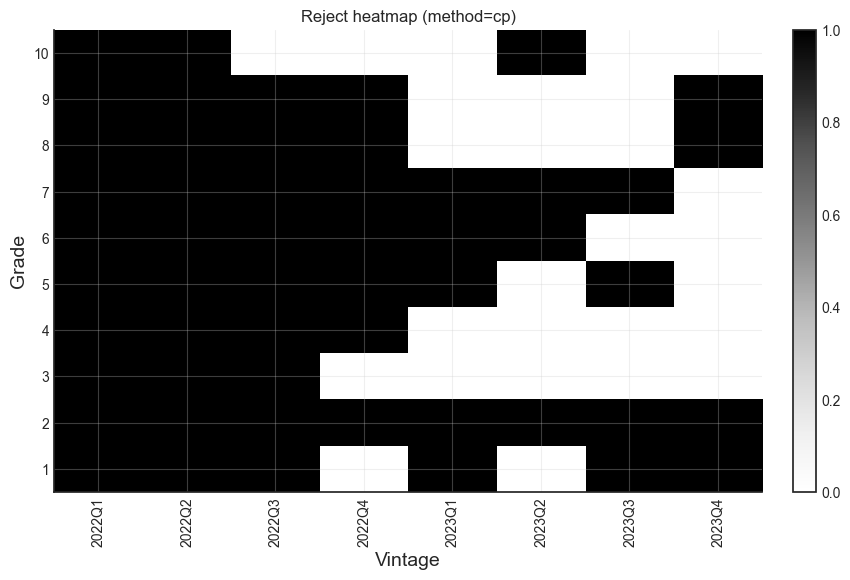

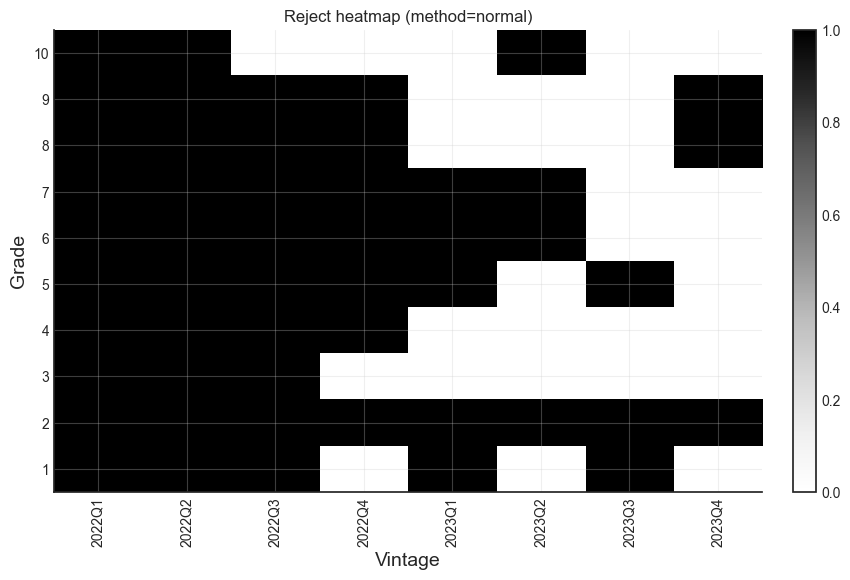

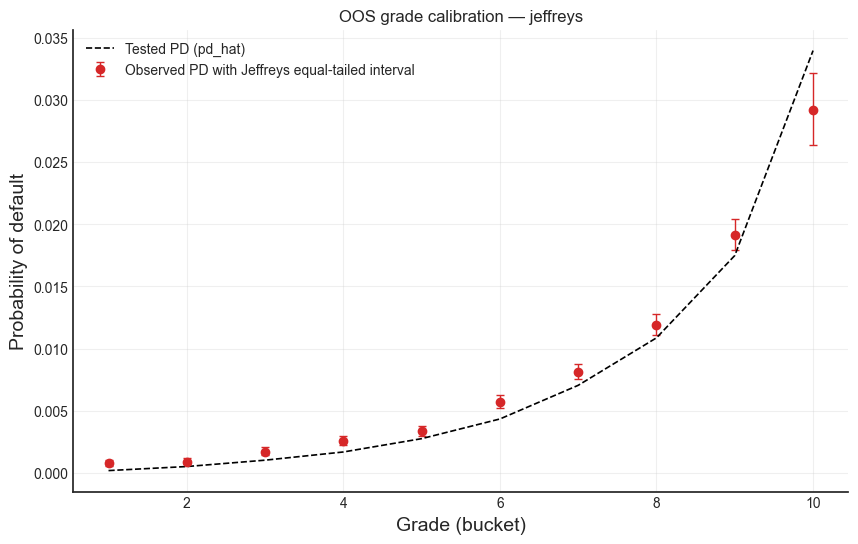

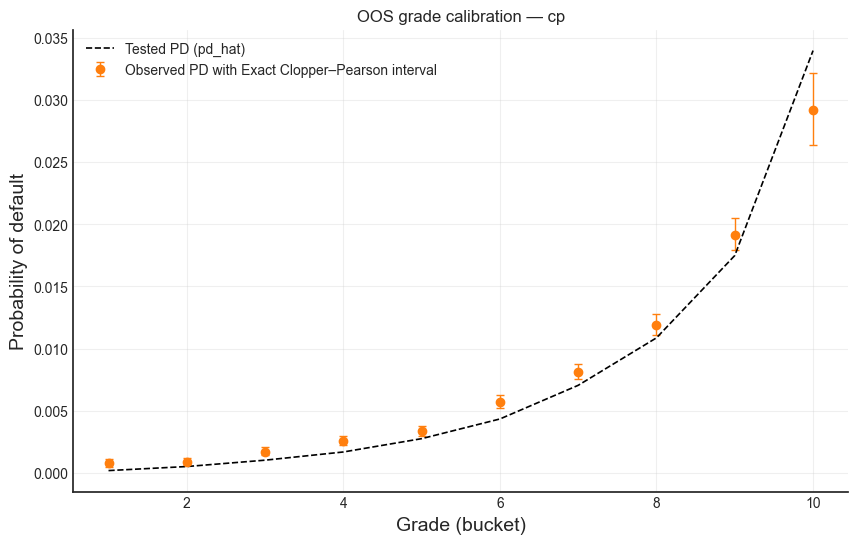

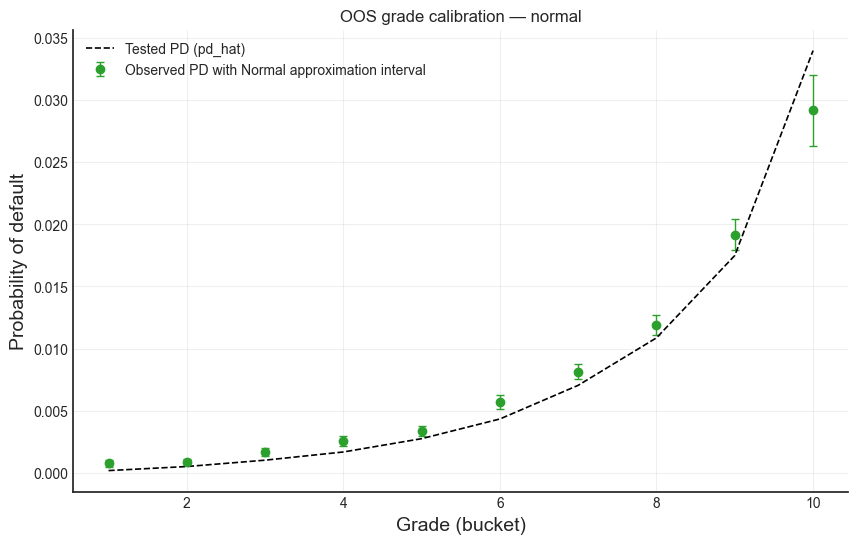

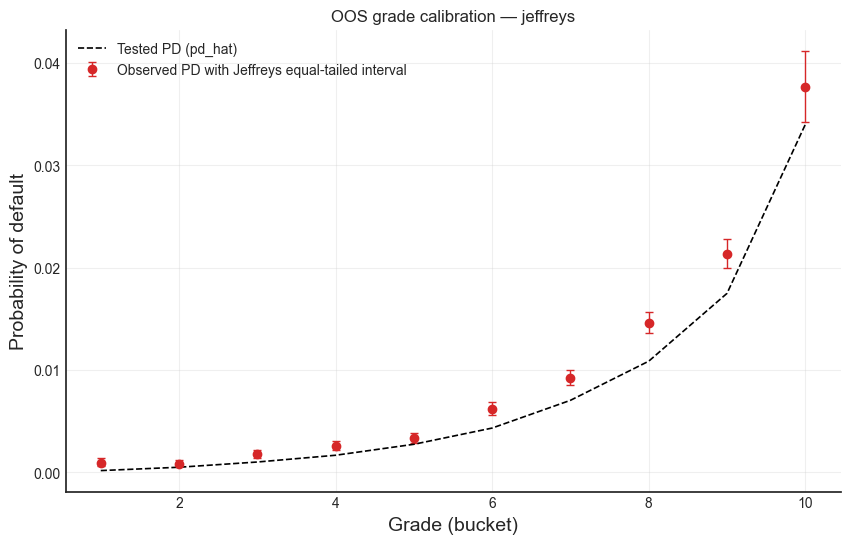

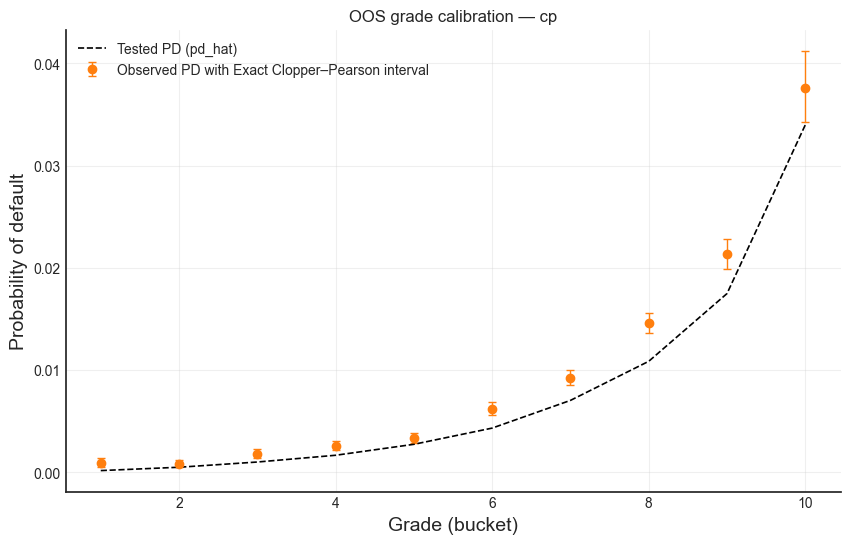

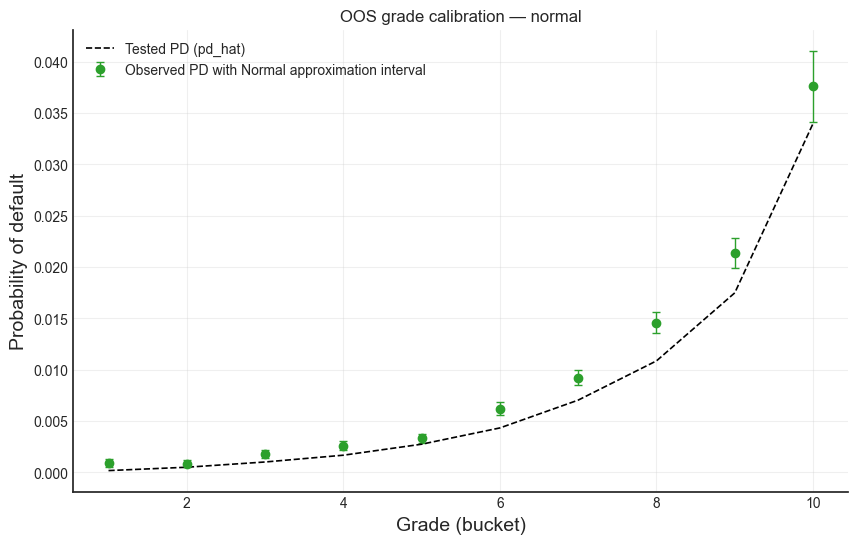

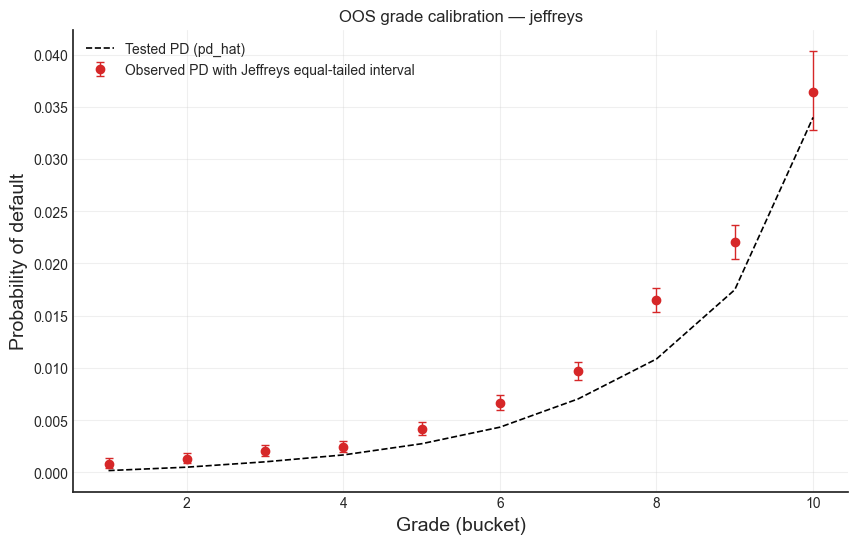

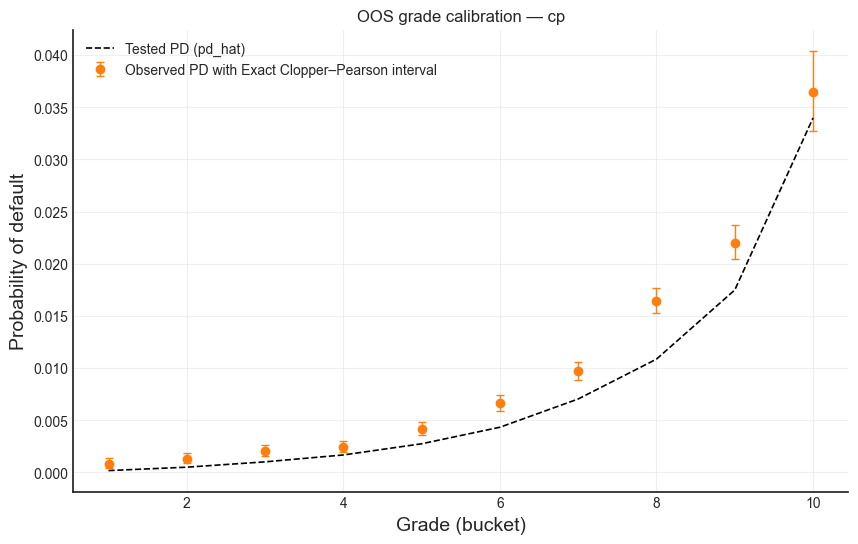

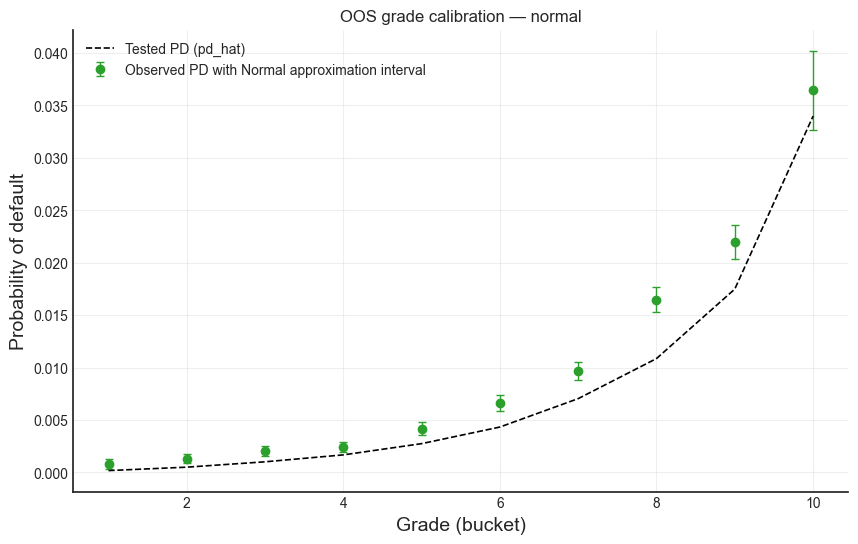

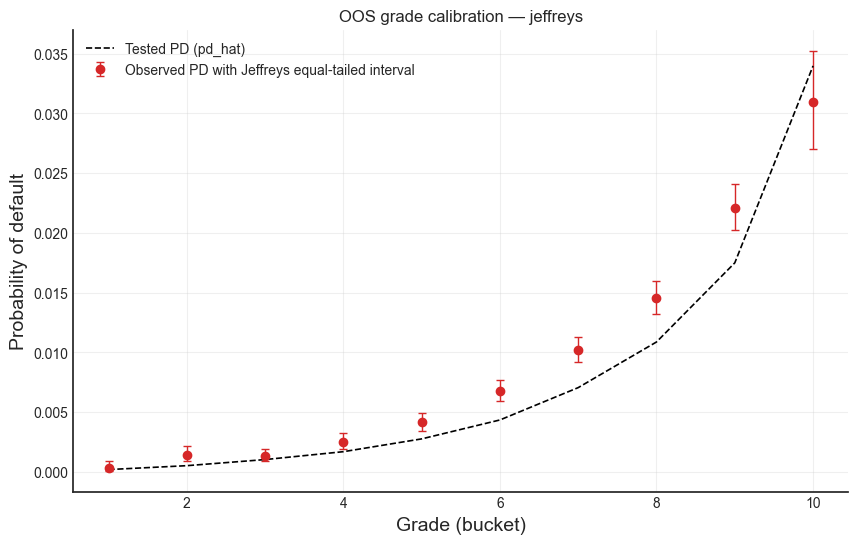

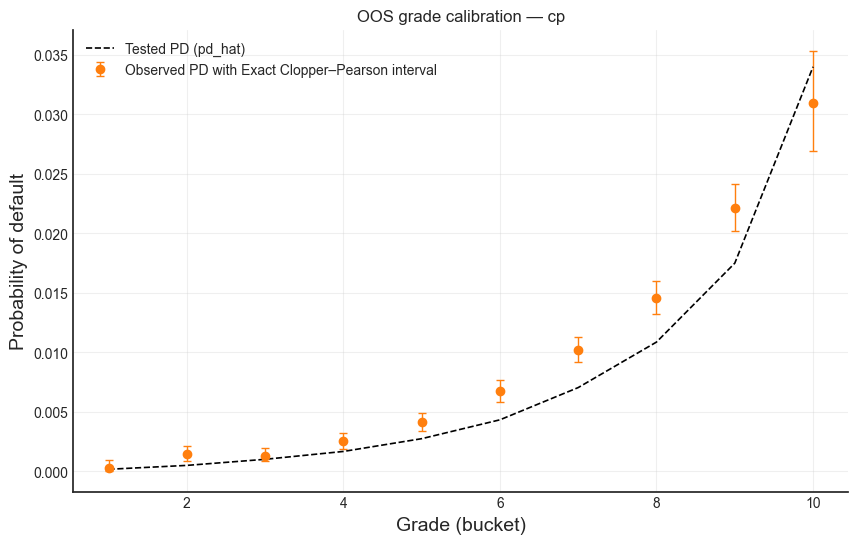

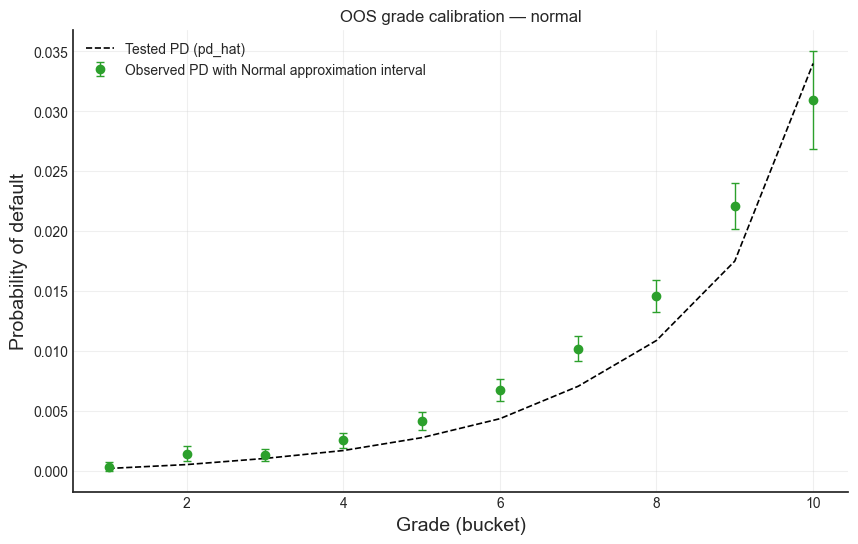

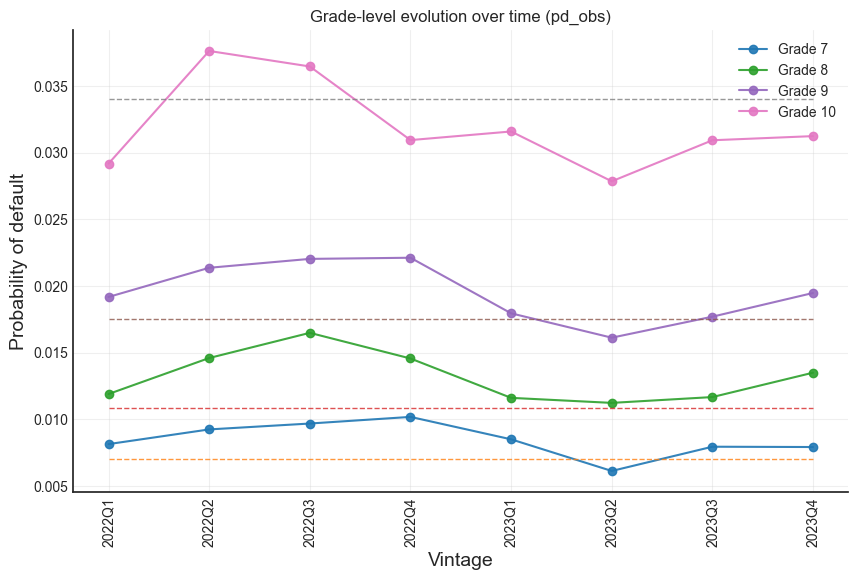

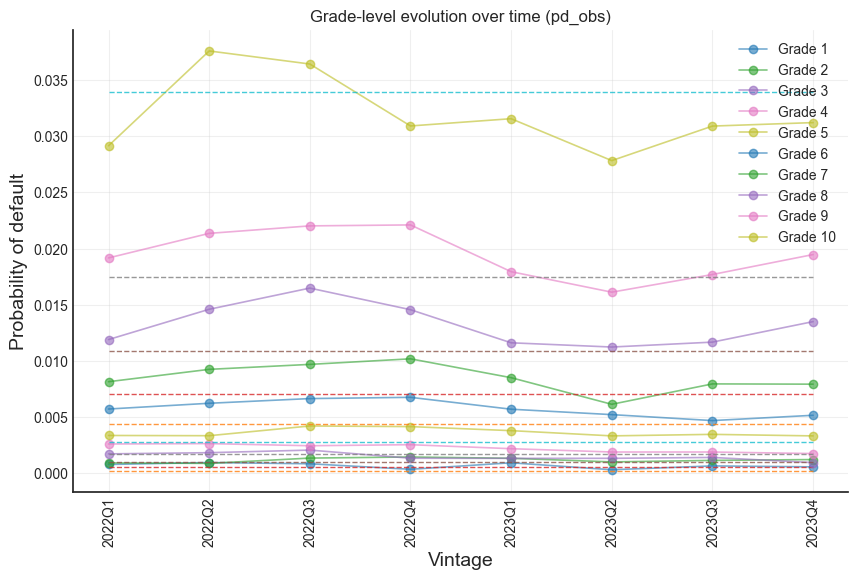

In [25]:
# =========================
# Notebook: OOS grade-level calibration (Jeffreys / Exact CP / Normal)
# - Works even if notebook is in ./notebook/
# - Fixes sys.path so `from experiments...` imports work
# - Robust paths by auto-detecting project root
# =========================

# -------------------------
# 0) Make project imports work from /notebook
# -------------------------
from __future__ import annotations

from pathlib import Path
import sys

def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    markers = {"pyproject.toml", "Makefile", ".git"}
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("Notebook CWD:", Path.cwd())
print("Detected ROOT:", ROOT)
print("sys.path[0]:", sys.path[0])


# -------------------------
# 1) Imports (project + libs)
# -------------------------
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from experiments.stats.intervals import (
    jeffreys_alpha2,
    exact_cp,
    approx_normal,
)

from experiments.plots.style import (
    new_figure,
    finalize_ax,
    save_figure,
    METHOD_STYLES,
)


# -------------------------
# 2) CONFIG
# -------------------------
CONF_LEVEL = 0.95

# Data paths (relative to project root)
VAL_PATH = ROOT / "data" / "processed" / "scored" / "validation_scored.parquet"
OOS_PATH = ROOT / "data" / "processed" / "scored" / "oos_scored.parquet"

# Bucket stats JSON (PD TTC by bucket)
BUCKET_STATS_PATH = ROOT / "artifacts" / "model_from_binned" / "bucket_stats.json"
BUCKET_SECTION = "train"  # or "train", "train_raw", "validation", "train_val_longrun"

# Columns
VINTAGE_COL = "vintage"
GRADE_COL = "grade"
DEFAULT_COL = "default_12m"

# If you have per-loan PD predictions, set that column name here (else fallback to pd_ttc)
PD_HAT_COL = "pd_hat"  # e.g. "pd_hat", "pd_model", "proba_default", ...

# Choose what PD to test: "pd_hat" (preferred) or "pd_ttc"
TEST_TARGET = "pd_hat"

print("VAL exists:", VAL_PATH.exists())
print("OOS exists:", OOS_PATH.exists())
print("BUCKET exists:", BUCKET_STATS_PATH.exists())


# -------------------------
# 3) Helpers
# -------------------------
def _safe_int_grade(x) -> int:
    try:
        return int(float(x))
    except Exception:
        return int(x)

def load_bucket_pd_map(bucket_stats_path: Path, section: str) -> dict[int, float]:
    with open(bucket_stats_path, "r") as f:
        data = json.load(f)
    if section not in data:
        raise KeyError(f"'{section}' not in bucket_stats.json. Available keys: {list(data.keys())}")
    return {int(e["bucket"]): float(e["pd"]) for e in data[section]}

def build_vintage_grade_table(
    df: pd.DataFrame,
    vintage_col: str,
    grade_col: str,
    default_col: str,
    pd_hat_col: str | None,
    pd_ttc_map: dict[int, float] | None,
) -> pd.DataFrame:
    """
    Build vintage×grade table with:
      - n, d, pd_obs = d/n
      - pd_hat = mean per-loan PD (if available), else NaN
      - pd_ttc = PD from bucket_stats (if provided)
    """
    cols = [vintage_col, grade_col, default_col]
    use_pd_hat = pd_hat_col is not None and pd_hat_col in df.columns
    if use_pd_hat:
        cols.append(pd_hat_col)

    x = df[cols].copy()
    x[grade_col] = x[grade_col].map(_safe_int_grade)

    if use_pd_hat:
        agg = x.groupby([vintage_col, grade_col], as_index=False).agg(
            n=(default_col, "count"),
            d=(default_col, "sum"),
            pd_hat=(pd_hat_col, "mean"),
        )
    else:
        agg = x.groupby([vintage_col, grade_col], as_index=False).agg(
            n=(default_col, "count"),
            d=(default_col, "sum"),
        )
        agg["pd_hat"] = np.nan

    agg["pd_obs"] = agg["d"] / agg["n"]

    if pd_ttc_map is not None:
        agg["pd_ttc"] = agg[grade_col].map(pd_ttc_map).astype(float)
    else:
        agg["pd_ttc"] = np.nan

    # fallback: if no per-loan pd_hat, use pd_ttc as target PD
    if agg["pd_hat"].isna().all() and "pd_ttc" in agg.columns:
        agg["pd_hat"] = agg["pd_ttc"]

    return agg

def add_intervals_and_tests(
    df_vg: pd.DataFrame,
    confidence_level: float,
    test_target: str = "pd_hat",
) -> pd.DataFrame:
    """
    Add LB/UB/length/reject for methods: jeffreys, cp, normal.
    reject = target PD not in [LB,UB]
    """
    if test_target not in df_vg.columns:
        raise KeyError(f"test_target='{test_target}' not found in df columns: {df_vg.columns.tolist()}")

    out = df_vg.copy()
    n = out["n"].to_numpy(dtype=int)
    d = out["d"].to_numpy(dtype=int)
    p_obs = out["pd_obs"].to_numpy(dtype=float)
    p0 = out[test_target].to_numpy(dtype=float)

    lb_j, ub_j, lb_cp, ub_cp, lb_n, ub_n = [], [], [], [], [], []

    for ni, di, p_i in zip(n, d, p_obs):
        a, b = jeffreys_alpha2(ni, di, confidence_level)
        lb_j.append(a); ub_j.append(b)

        a, b = exact_cp(ni, di, confidence_level)
        lb_cp.append(a); ub_cp.append(b)

        a, b = approx_normal(ni, di, confidence_level)
        lb_n.append(max(0.0, a))
        ub_n.append(min(1.0, b))

    lb_j = np.array(lb_j); ub_j = np.array(ub_j)
    lb_cp = np.array(lb_cp); ub_cp = np.array(ub_cp)
    lb_n = np.array(lb_n); ub_n = np.array(ub_n)

    for method, (lb, ub) in {
        "jeffreys": (lb_j, ub_j),
        "cp": (lb_cp, ub_cp),
        "normal": (lb_n, ub_n),
    }.items():
        out[f"lb_{method}"] = lb
        out[f"ub_{method}"] = ub
        out[f"len_{method}"] = ub - lb
        out[f"reject_{method}"] = ~((p0 >= lb) & (p0 <= ub))

    return out

def build_method_summary(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Summary per vintage & method:
      - share_grades_rejected
      - share_exposure_rejected (weighted by n)
      - avg_len_weighted (weighted by n)
    """
    rows = []
    for method in ["jeffreys", "cp", "normal"]:
        for vintage, g in df_long.groupby(VINTAGE_COL):
            n_tot = float(g["n"].sum())
            rows.append({
                "vintage": vintage,
                "method": method,
                "share_grades_rejected": float(g[f"reject_{method}"].mean()),
                "share_exposure_rejected": float(g.loc[g[f"reject_{method}"], "n"].sum() / n_tot) if n_tot > 0 else np.nan,
                "avg_len_weighted": float((g["n"] * g[f"len_{method}"]).sum() / n_tot) if n_tot > 0 else np.nan,
                "n_total": int(n_tot),
            })
    return (
        pd.DataFrame(rows)
        .sort_values(["vintage", "method"])
        .reset_index(drop=True)
    )


# -------------------------
# 4) Load + build tables
# -------------------------
df_oos = pd.read_parquet(OOS_PATH)
# If you want Val + OOS, uncomment below:
# df_val = pd.read_parquet(VAL_PATH)
# df = pd.concat([df_val, df_oos], ignore_index=True)
df = df_oos.copy()

pd_ttc_map = load_bucket_pd_map(BUCKET_STATS_PATH, BUCKET_SECTION) if BUCKET_STATS_PATH.exists() else None

df_vg = build_vintage_grade_table(
    df,
    vintage_col=VINTAGE_COL,
    grade_col=GRADE_COL,
    default_col=DEFAULT_COL,
    pd_hat_col=PD_HAT_COL,
    pd_ttc_map=pd_ttc_map,
)

# Ensure TEST_TARGET exists; fallback to pd_ttc if necessary
if TEST_TARGET not in df_vg.columns or df_vg[TEST_TARGET].isna().all():
    TEST_TARGET = "pd_ttc"
    print("Fallback TEST_TARGET -> pd_ttc")

df_long = add_intervals_and_tests(df_vg, confidence_level=CONF_LEVEL, test_target=TEST_TARGET)
df_summary = build_method_summary(df_long)

display(df_summary.head(30))
display(df_long.head(20))


# -------------------------
# 5) Plots (simulation style)
# -------------------------
def plot_pd_by_grade_one_method(
    df_vintage: pd.DataFrame,
    method: str,
    pd_target_col: str,
    show: bool = True,
    save_path: Path | None = None,
):
    """
    For one vintage:
      - points: pd_obs
      - error bars: [lb_method, ub_method]
      - dashed line: pd_target_col (pd_hat/pd_ttc)
    """
    dfp = df_vintage.sort_values(GRADE_COL).copy()
    x = dfp[GRADE_COL].astype(int).to_numpy()
    y = dfp["pd_obs"].to_numpy(float)
    lb = dfp[f"lb_{method}"].to_numpy(float)
    ub = dfp[f"ub_{method}"].to_numpy(float)
    yhat = dfp[pd_target_col].to_numpy(float)

    yerr = np.vstack([np.maximum(0.0, y - lb), np.maximum(0.0, ub - y)])

    fig, ax = new_figure()

    style = METHOD_STYLES.get(method, {})
    color = style.get("color", None)
    label = style.get("label", method)

    ax.errorbar(
        x, y, yerr=yerr,
        fmt="o", capsize=3, linewidth=1.0,
        color=color,
        label=f"Observed PD with {label} interval",
    )
    ax.plot(
        x, yhat,
        linestyle="--", linewidth=1.2, color="black",
        label=f"Tested PD ({pd_target_col})",
    )

    finalize_ax(
        ax,
        xlabel="Grade (bucket)",
        ylabel="Probability of default",
        title=f"OOS grade calibration — {method}",
        nominal_level=None,
        add_legend=True,
    )

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)

def plot_reject_heatmap(
    df_long_all: pd.DataFrame,
    method: str,
    show: bool = True,
    save_path: Path | None = None,
):
    """
    Heatmap: grade (y) × vintage (x), value = reject (0/1).
    """
    tmp = df_long_all.copy()
    tmp[VINTAGE_COL] = tmp[VINTAGE_COL].astype(str)
    tmp[GRADE_COL] = tmp[GRADE_COL].astype(int)

    mat = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values=f"reject_{method}").sort_index()
    Z = mat.fillna(False).astype(int).to_numpy()

    fig, ax = new_figure()
    im = ax.imshow(Z, aspect="auto", origin="lower")  # default colormap

    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(mat.index.tolist())
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(mat.columns.tolist(), rotation=90)

    finalize_ax(
        ax,
        xlabel="Vintage",
        ylabel="Grade",
        title=f"Reject heatmap (method={method})",
        nominal_level=None,
        add_legend=False,
    )
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)

# Heatmaps (compact summary across vintages)
for method in ["jeffreys", "cp", "normal"]:
    plot_reject_heatmap(df_long, method, show=True)

# PD-by-grade for a few vintages (avoid spamming)
some_vintages = sorted(df_long[VINTAGE_COL].unique())[:4]  # adjust slice
for v in some_vintages:
    sub = df_long[df_long[VINTAGE_COL] == v]
    for method in ["jeffreys", "cp", "normal"]:
        plot_pd_by_grade_one_method(sub, method, pd_target_col=TEST_TARGET, show=True)



import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from experiments.plots.style import new_figure, finalize_ax, save_figure


# -------------------------
# Vintage sorting helper (YYYYQn)
# -------------------------
def vintage_sort_key(v: str) -> float:
    """
    Convert "2021Q3" -> 2021*4+3 for correct chronological sorting.
    Falls back to NaN -> lexical order.
    """
    if v is None:
        return np.nan
    m = re.match(r"^\s*(\d{4})\s*Q\s*([1-4])\s*$", str(v).upper().replace(" ", ""))
    if not m:
        return np.nan
    year = int(m.group(1))
    q = int(m.group(2))
    return year * 4 + q


def prepare_time_axis(df_long: pd.DataFrame, vintage_col="vintage") -> tuple[pd.DataFrame, list[str]]:
    df = df_long.copy()
    df["_vkey"] = df[vintage_col].map(vintage_sort_key)
    # if some vintages not parsable, fallback to string sort for those
    if df["_vkey"].isna().any():
        # keep parsable first, then lexicographic
        df["_vkey"] = df["_vkey"].fillna(df[vintage_col].astype(str).rank(method="dense"))
    vintages_sorted = (
        df[[vintage_col, "_vkey"]]
        .drop_duplicates()
        .sort_values("_vkey")[vintage_col]
        .astype(str).tolist()
    )
    df[vintage_col] = pd.Categorical(df[vintage_col].astype(str), categories=vintages_sorted, ordered=True)
    return df, vintages_sorted


# -------------------------
# Plot: evolution over time for multiple grades (one method band optional)
# -------------------------
def plot_grade_evolution_over_time(
    df_long: pd.DataFrame,
    method: str = "jeffreys",          # which interval to show (lb_/ub_)
    y: str = "pd_obs",                # "pd_obs" or "pd_hat" or "pd_ttc"
    pd_target_col: str = "pd_hat",     # dashed reference per grade
    grades: list[int] | None = None,  # select grades to avoid clutter
    show_intervals: bool = False,     # bands make it heavy if many grades
    alpha_lines: float = 0.9,
    lw: float = 1.5,
    save_path=None,
    show=True,
    title=None,
):
    df, vintages = prepare_time_axis(df_long, vintage_col="vintage")

    if grades is None:
        grades = sorted(df["grade"].astype(int).unique().tolist())

    # Keep selected grades only
    df = df[df["grade"].astype(int).isin(grades)].copy()

    fig, ax = new_figure()

    # x positions for vintages
    x = np.arange(len(vintages))
    ax.set_xticks(x)
    ax.set_xticklabels(vintages, rotation=90)

    # Plot one line per grade
    for g in grades:
        sub = df[df["grade"].astype(int) == g].sort_values("vintage")
        y_vals = sub[y].to_numpy(float)

        ax.plot(
            x,
            y_vals,
            marker="o",
            linewidth=lw,
            alpha=alpha_lines,
            label=f"Grade {g}",
        )

        # Optional: show tested PD as dashed line for same grade
        if pd_target_col in sub.columns and not sub[pd_target_col].isna().all():
            ax.plot(
                x,
                sub[pd_target_col].to_numpy(float),
                linestyle="--",
                linewidth=1.0,
                alpha=0.8,
            )

        # Optional: interval bands (for chosen method)
        if show_intervals:
            lb_col = f"lb_{method}"
            ub_col = f"ub_{method}"
            if lb_col in sub.columns and ub_col in sub.columns:
                lb = sub[lb_col].to_numpy(float)
                ub = sub[ub_col].to_numpy(float)
                ax.fill_between(x, lb, ub, alpha=0.08)

    finalize_ax(
        ax,
        xlabel="Vintage",
        ylabel="Probability of default",
        title=title or f"Grade-level evolution over time ({y})",
        nominal_level=None,
        add_legend=True,
    )

    # To keep legend readable when many grades, you can uncomment:
    # ax.legend(ncol=2, fontsize=10)

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)


# -------------------------
# Example usage
# -------------------------

# 1) Courbes pd_obs par grade (les 4 grades les plus risqués seulement)
grades_risky = [7, 8, 9, 10]
plot_grade_evolution_over_time(
    df_long,
    method="jeffreys",
    y="pd_obs",
    pd_target_col="pd_hat",     # ou "pd_ttc"
    grades=grades_risky,
    show_intervals=False,       # True si tu veux, mais ça charge
)

# 2) Tous les grades (sans bandes), peut être dense mais lisible avec alpha
plot_grade_evolution_over_time(
    df_long,
    method="jeffreys",
    y="pd_obs",
    pd_target_col="pd_hat",
    grades=None,
    show_intervals=False,
    alpha_lines=0.6,
    lw=1.2,
)



# -------------------------
# 6) (Optional) save CSV outputs (relative to notebook)
# -------------------------
# OUT_DIR = Path("./outputs_oos_grade_calibration")
# OUT_DIR.mkdir(parents=True, exist_ok=True)
# df_long.to_csv(OUT_DIR / "oos_grade_calibration_long.csv", index=False)
# df_summary.to_csv(OUT_DIR / "oos_grade_calibration_summary.csv", index=False)
# print("Saved CSVs to:", OUT_DIR.resolve())


In [7]:
# écart en bps (basis points)
df_long["gap_bps"] = 1e4 * (df_long["pd_obs"] - df_long[TEST_TARGET])

# moyenne pondérée par n, par vintage
gap_v = (
    df_long.groupby("vintage")
    .apply(lambda x: np.average(x["gap_bps"], weights=x["n"]))
    .rename("weighted_gap_bps")
    .reset_index()
)
display(gap_v)


/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_5832/1747833332.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x["gap_bps"], weights=x["n"]))


,vintage,weighted_gap_bps
0,2022Q1,8.828769
1,2022Q2,19.408842
2,2022Q3,25.634728
3,2022Q4,22.474650
4,2023Q1,9.682348
5,2023Q2,0.586459
6,2023Q3,6.210036
7,2023Q4,10.072137


In [8]:
import numpy as np
import pandas as pd

# 1) Choisir la PD testée (pd_hat ou pd_ttc)
p_test_col = TEST_TARGET  # "pd_hat" ou "pd_ttc"

eps = 1e-12
x = df_long.copy()

# 2) Stats par cellule (vintage, grade)
x["p_obs"] = x["pd_obs"].astype(float)
x["p_test"] = x[p_test_col].astype(float)

x["gap_bps"] = 1e4 * (x["p_obs"] - x["p_test"])
x["oe_ratio"] = (x["p_obs"] + eps) / (x["p_test"] + eps)     # Observed / Expected
x["log_oe"]   = np.log(x["oe_ratio"])                         # symétrique (0 = parfait)

# 3) Diagnostic par vintage
def diag_one_vintage(g: pd.DataFrame) -> pd.Series:
    w = g["n"].astype(float).to_numpy()
    w = w / w.sum()

    gap = g["gap_bps"].to_numpy(float)
    logoe = g["log_oe"].to_numpy(float)

    # proportion de grades dans le même sens que la moyenne (signature "niveau")
    mean_gap = np.sum(w * gap)
    same_sign_share = np.mean(np.sign(gap) == np.sign(mean_gap)) if mean_gap != 0 else np.mean(gap == 0)

    # dispersion selon le grade (signature "forme")
    # (si c'est juste un shift, dispersion faible)
    weighted_std_gap = np.sqrt(np.sum(w * (gap - mean_gap)**2))

    # corrélation grade vs gap (si plus mauvais grades dévient plus → slope/shape)
    # (si correlation forte, c’est rarement purement un intercept shift)
    grades = g["grade"].astype(float).to_numpy()
    if np.std(grades) > 0 and np.std(gap) > 0:
        corr_grade_gap = float(np.corrcoef(grades, gap)[0, 1])
    else:
        corr_grade_gap = np.nan

    # OE global par vintage (exposition-weighted)
    # Observed defaults / Expected defaults
    d_tot = g["d"].sum()
    exp_tot = (g["n"] * g["p_test"]).sum()
    oe_global = float(d_tot / exp_tot) if exp_tot > 0 else np.nan

    return pd.Series({
        "N_total": int(g["n"].sum()),
        "DR_obs": float(d_tot / g["n"].sum()),
        "DR_test": float(exp_tot / g["n"].sum()),
        "OE_global": oe_global,
        "gap_bps_weighted": float(mean_gap),
        "gap_bps_std_across_grades": float(weighted_std_gap),
        "same_sign_share": float(same_sign_share),
        "corr(grade, gap_bps)": corr_grade_gap,
    })

diag = x.groupby("vintage").apply(diag_one_vintage).reset_index()

display(diag.sort_values("vintage"))


/var/folders/yk/g149s5cs3m1f2t6smf32gc1m0000gn/T/ipykernel_5832/1454769575.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diag = x.groupby("vintage").apply(diag_one_vintage).reset_index()


,vintage,N_total,DR_obs,DR_test,OE_global,gap_bps_weighted,gap_bps_std_across_grades,same_sign_share,"corr(grade, gap_bps)"
0,2022Q1,583714.0,0.006414,0.005531,1.159617,8.828769,4.567184,1.0,0.808410
1,2022Q2,437882.0,0.007982,0.006041,1.321300,19.408842,15.640542,1.0,0.793903
2,2022Q3,336779.0,0.008840,0.006276,1.408447,25.634728,18.706812,1.0,0.843956
3,2022Q4,222384.0,0.008715,0.006467,1.347518,22.474650,16.207425,0.9,0.844677
4,2023Q1,186037.0,0.007525,0.006557,1.147661,9.682348,4.770235,1.0,0.595933
5,2023Q2,276114.0,0.006273,0.006214,1.009438,0.586459,7.111917,0.8,-0.360808
6,2023Q3,262621.0,0.006755,0.006134,1.101240,6.210036,5.808308,0.9,0.255394
7,2023Q4,206973.0,0.007156,0.006148,1.163820,10.072137,11.348514,0.7,0.688866


Notebook CWD: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/notebook
Detected ROOT: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration
sys.path[0]: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration
VAL exists: True
OOS exists: True
BUCKET exists: True
Using rolling window: 4 quarters


,vintage,method,share_grades_rejected,share_exposure_rejected,avg_len_weighted,n_total
0,2022Q1,cp,0.466667,0.339438,0.001308,583714
1,2022Q1,jeffreys,0.466667,0.339438,0.001282,583714
2,2022Q1,normal,0.266667,0.205928,0.001279,583714
3,2022Q2,cp,0.666667,0.543092,0.001016,1021596
4,2022Q2,jeffreys,0.733333,0.626178,0.001002,1021596
5,2022Q2,normal,0.600000,0.532228,0.001000,1021596
6,2022Q3,cp,0.933333,0.917660,0.000900,1358375
7,2022Q3,jeffreys,0.933333,0.917660,0.000889,1358375
8,2022Q3,normal,0.933333,0.917660,0.000888,1358375
9,2022Q4,cp,1.000000,1.000000,0.000839,1580759


,vintage,grade,n,d,pd_obs,pd_hat,pd_ttc,roll_window_q,lb_jeffreys,ub_jeffreys,len_jeffreys,reject_jeffreys,lb_cp,ub_cp,len_cp,reject_cp,lb_normal,ub_normal,len_normal,reject_normal
0,2022Q1,1,7338,3,0.000409,0.000078,0.000087,4,0.000115,0.001091,0.000976,True,0.000084,0.001194,0.001110,True,0.000000,0.000871,0.000871,False
1,2022Q2,1,11099,4,0.000360,0.000078,0.000087,4,0.000122,0.000857,0.000735,True,0.000098,0.000922,0.000824,True,0.000007,0.000714,0.000706,False
2,2022Q3,1,13910,6,0.000431,0.000078,0.000087,4,0.000180,0.000889,0.000709,True,0.000158,0.000939,0.000780,True,0.000086,0.000776,0.000690,True
3,2022Q4,1,15589,7,0.000449,0.000078,0.000087,4,0.000201,0.000881,0.000681,True,0.000181,0.000925,0.000744,True,0.000116,0.000782,0.000665,True
4,2023Q1,1,9697,5,0.000516,0.000078,0.000087,4,0.000197,0.001130,0.000933,True,0.000167,0.001203,0.001035,True,0.000064,0.000967,0.000904,False
5,2023Q2,1,8657,4,0.000462,0.000078,0.000087,4,0.000156,0.001098,0.000942,True,0.000126,0.001183,0.001057,True,0.000009,0.000915,0.000905,False
6,2023Q3,1,8669,5,0.000577,0.000078,0.000087,4,0.000220,0.001264,0.001044,True,0.000187,0.001345,0.001158,True,0.000071,0.001082,0.001011,False
7,2023Q4,1,9075,4,0.000441,0.000078,0.000087,4,0.000149,0.001048,0.000899,True,0.000120,0.001128,0.001008,True,0.000009,0.000873,0.000864,False
8,2022Q1,2,14565,7,0.000481,0.000158,0.000220,4,0.000215,0.000943,0.000728,True,0.000193,0.000990,0.000797,True,0.000125,0.000837,0.000712,False
9,2022Q2,2,21925,13,0.000593,0.000158,0.000220,4,0.000332,0.000985,0.000652,True,0.000316,0.001014,0.000698,True,0.000271,0.000915,0.000644,True


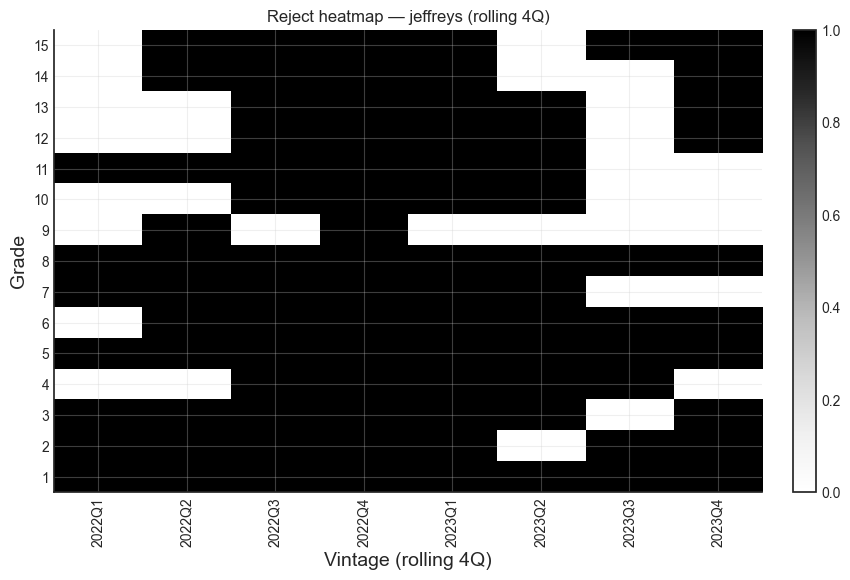

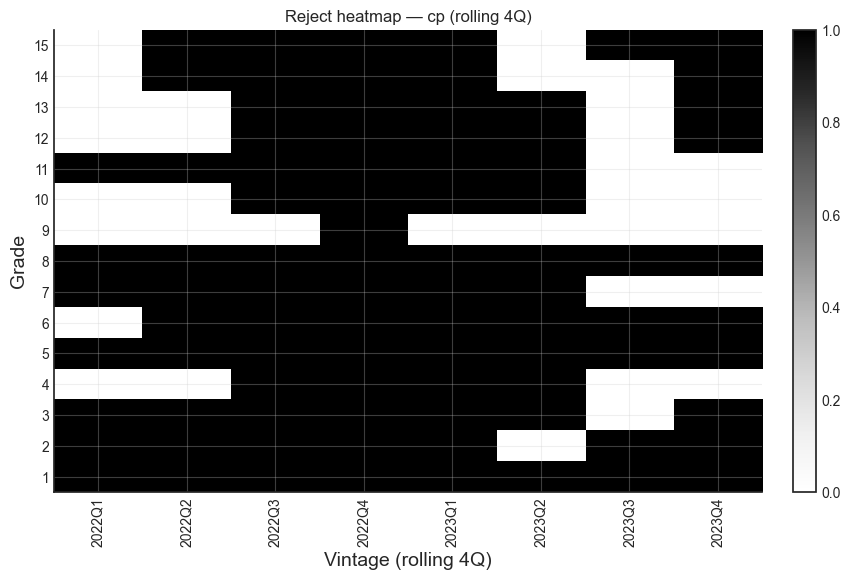

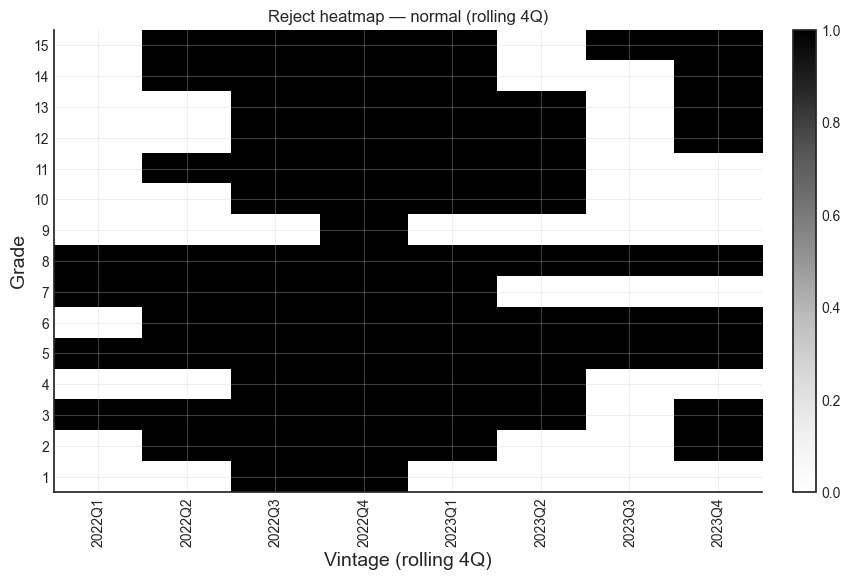

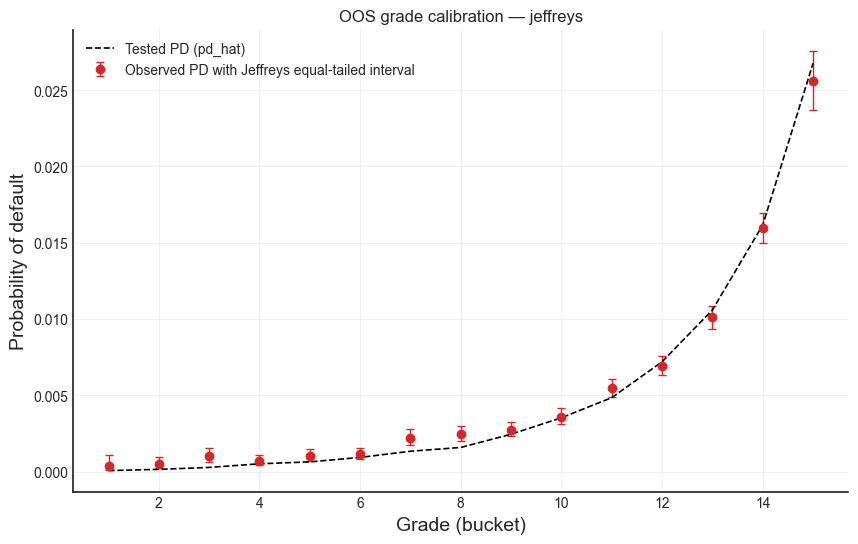

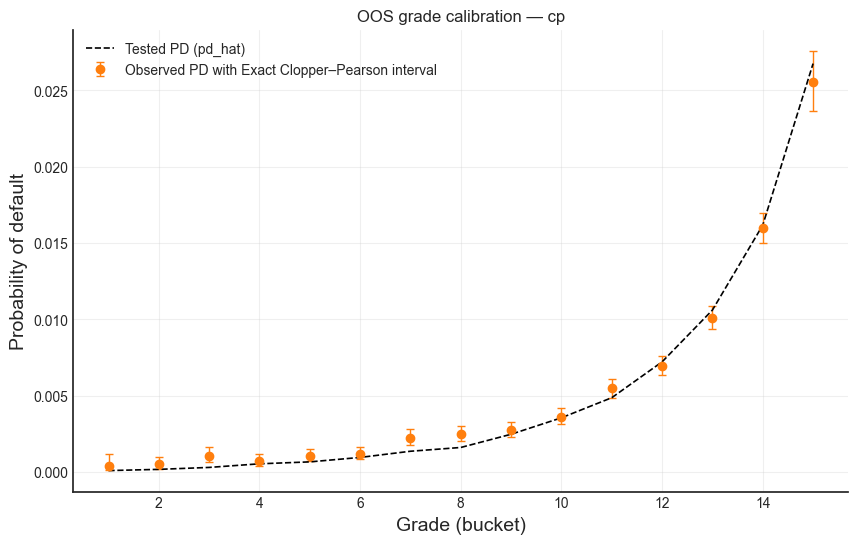

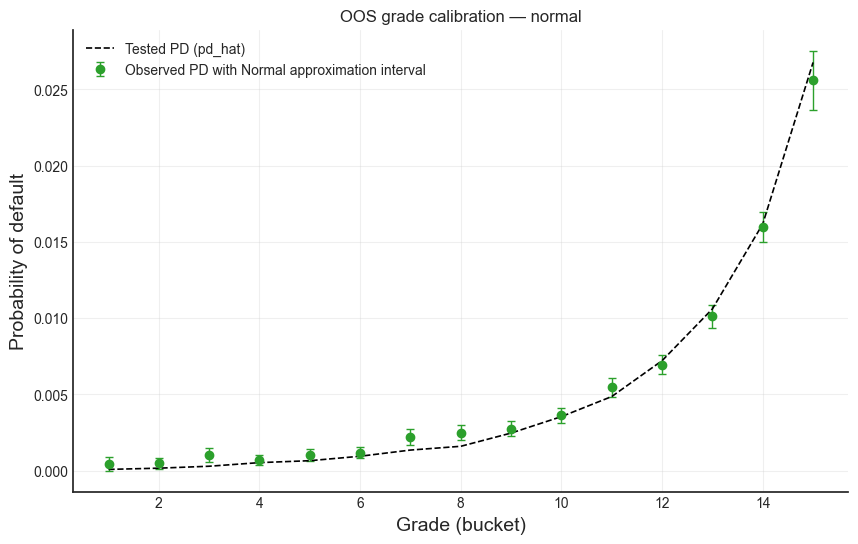

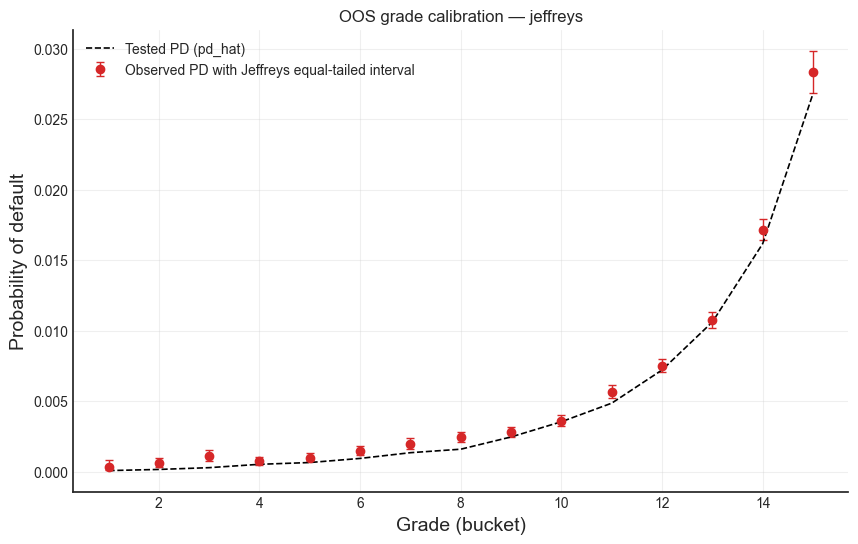

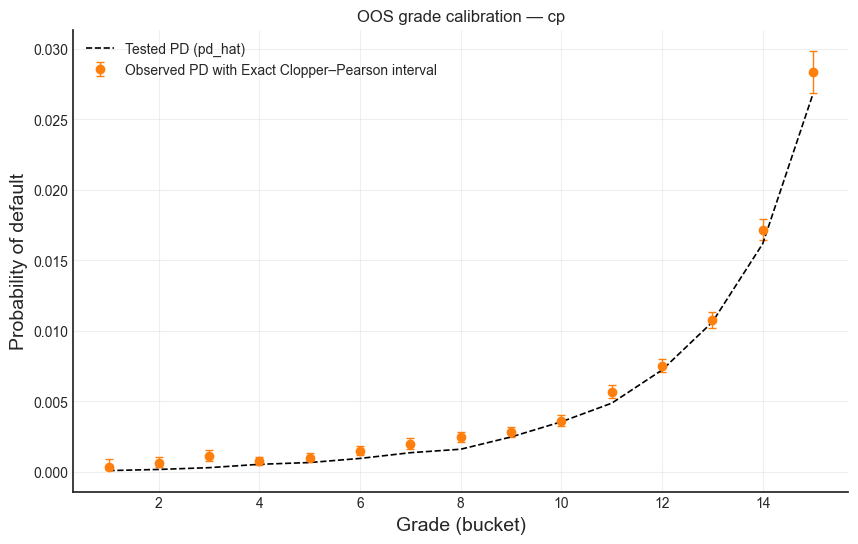

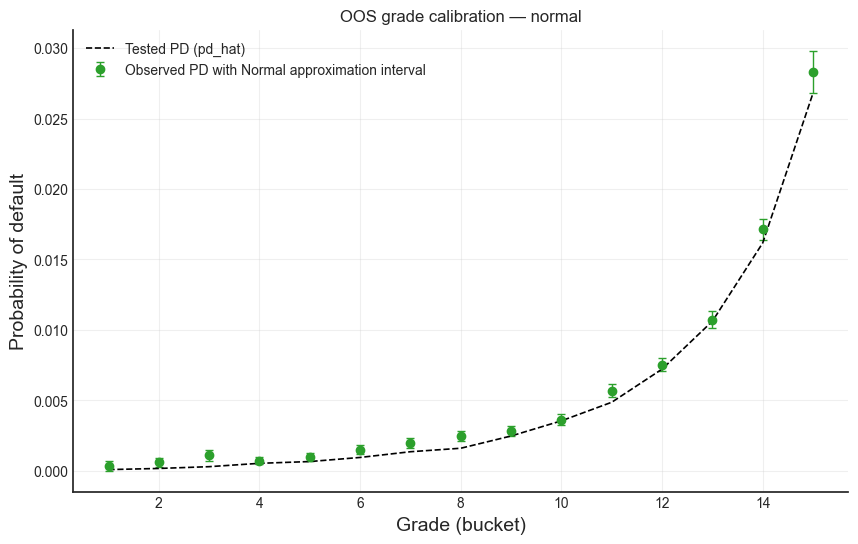

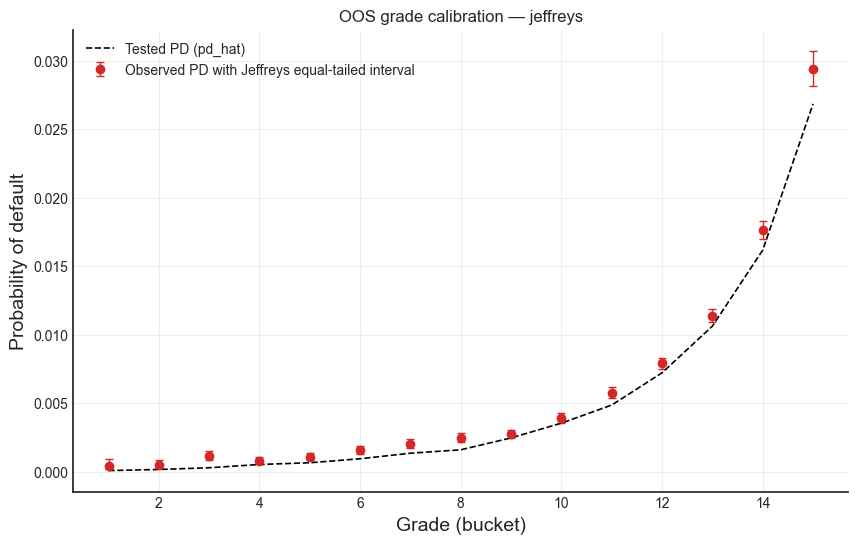

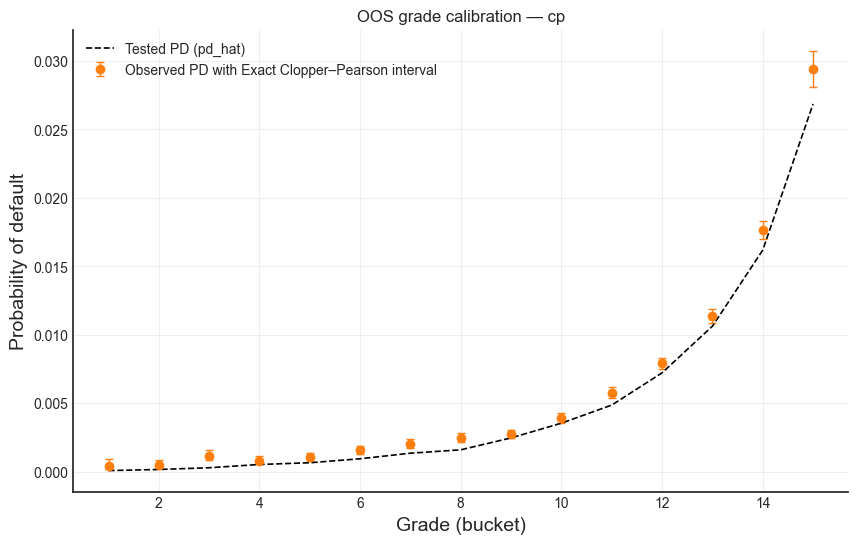

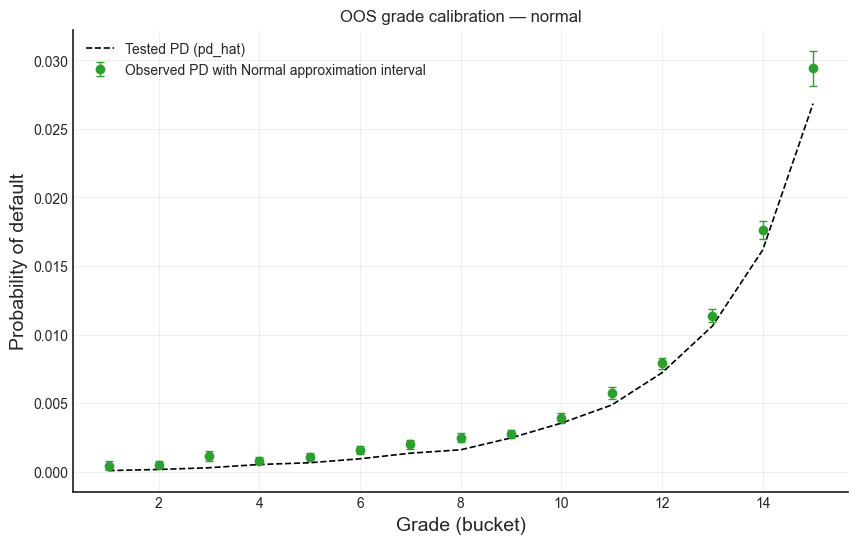

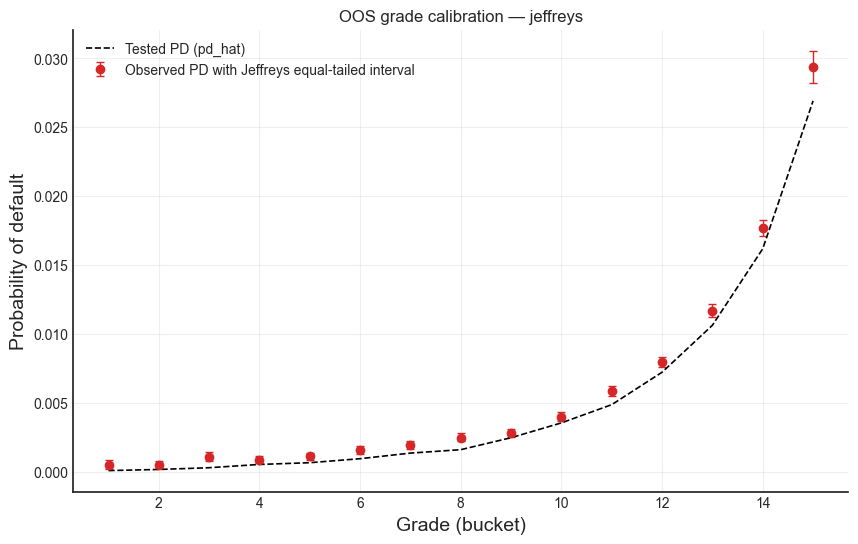

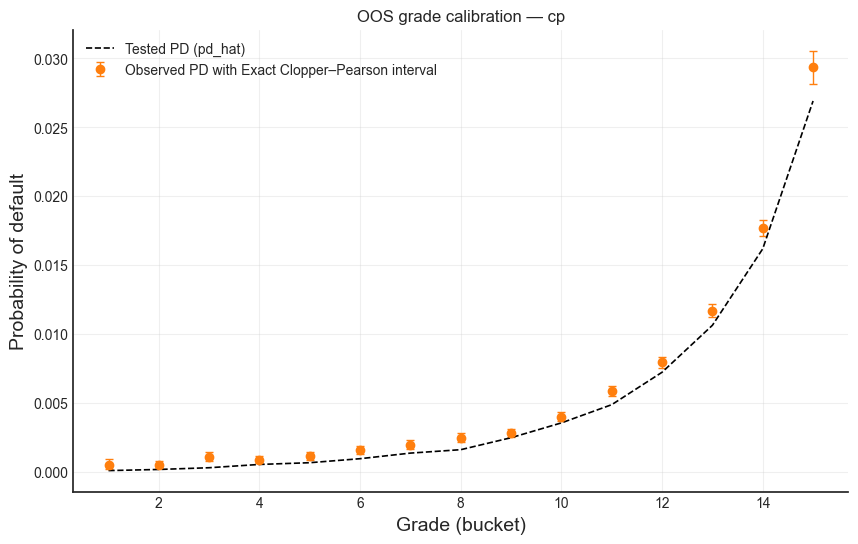

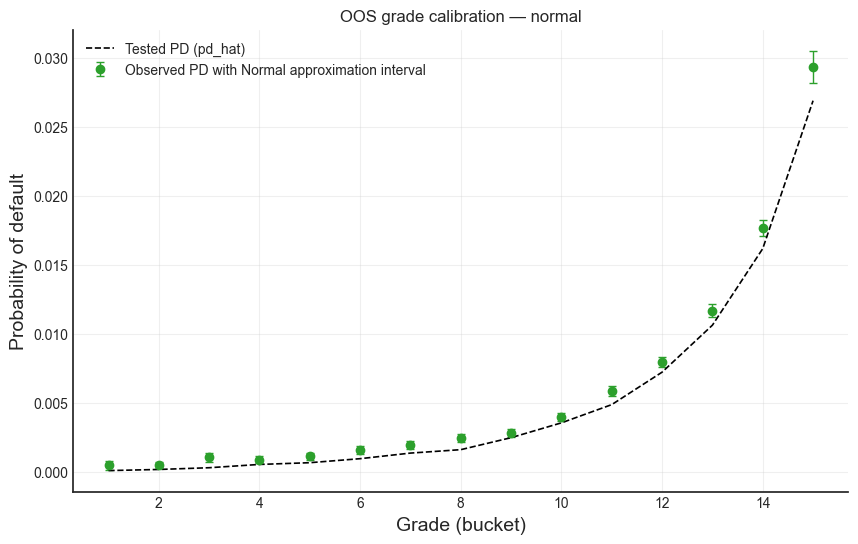

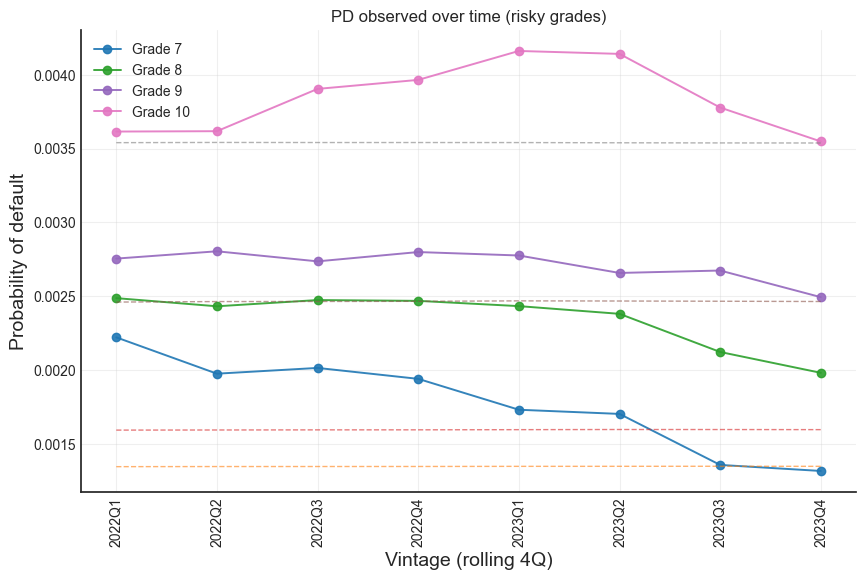

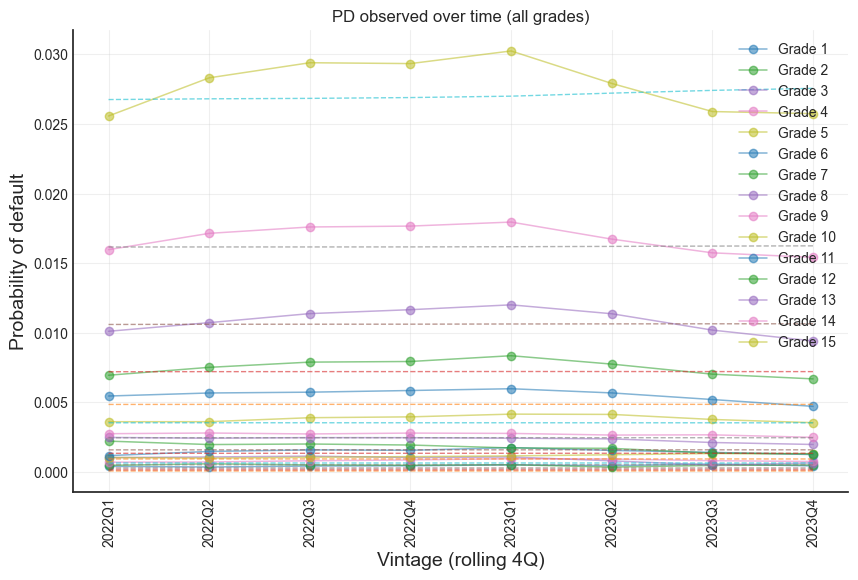

In [21]:
# =========================
# Notebook: OOS grade-level calibration (Jeffreys / Exact CP / Normal)
# + Rolling 4 quarters (or any window)
# - Works even if notebook is in ./notebook/
# - Fixes sys.path so `from experiments...` imports work
# - Robust paths by auto-detecting project root
# =========================

# -------------------------
# 0) Make project imports work from /notebook
# -------------------------
from __future__ import annotations

from pathlib import Path
import sys

def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    markers = {"pyproject.toml", "Makefile", ".git"}
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("Notebook CWD:", Path.cwd())
print("Detected ROOT:", ROOT)
print("sys.path[0]:", sys.path[0])


# -------------------------
# 1) Imports (project + libs)
# -------------------------
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from experiments.stats.intervals import (
    jeffreys_alpha2,
    exact_cp,
    approx_normal,
)

from experiments.plots.style import (
    new_figure,
    finalize_ax,
    save_figure,
    METHOD_STYLES,
)


# -------------------------
# 2) CONFIG
# -------------------------
CONF_LEVEL = 0.95

# Data paths (relative to project root)
VAL_PATH = ROOT / "data" / "processed" / "scored" / "validation_scored.parquet"
OOS_PATH = ROOT / "data" / "processed" / "scored" / "oos_scored.parquet"

# Bucket stats JSON (PD TTC by bucket)
BUCKET_STATS_PATH = ROOT / "artifacts" / "model_from_binned" / "bucket_stats.json"
BUCKET_SECTION = "train_val_longrun"  # or "train", "train_raw", "validation", "train_val_longrun"

# Columns
VINTAGE_COL = "vintage"
GRADE_COL = "grade"
DEFAULT_COL = "default_12m"

# Your scored files usually have per-loan PD under column "pd" (from your training script)
# If you truly have "pd_hat" in your scored parquet, set it below.
PD_HAT_COL = "pd"  # <-- change to "pd_hat" if that's your column

# Choose what PD to test: "pd_hat" (preferred) or "pd_ttc"
TEST_TARGET = "pd_hat"  # will fallback to pd_ttc if pd_hat is missing

# Rolling config
USE_ROLLING = True
ROLLING_Q = 4  # rolling quarters window

print("VAL exists:", VAL_PATH.exists())
print("OOS exists:", OOS_PATH.exists())
print("BUCKET exists:", BUCKET_STATS_PATH.exists())


# -------------------------
# 3) Helpers
# -------------------------
def _safe_int_grade(x) -> int:
    try:
        return int(float(x))
    except Exception:
        return int(x)

def load_bucket_pd_map(bucket_stats_path: Path, section: str) -> dict[int, float]:
    with open(bucket_stats_path, "r") as f:
        data = json.load(f)
    if section not in data:
        raise KeyError(f"'{section}' not in bucket_stats.json. Available keys: {list(data.keys())}")
    return {int(e["bucket"]): float(e["pd"]) for e in data[section]}

def build_vintage_grade_table(
    df: pd.DataFrame,
    vintage_col: str,
    grade_col: str,
    default_col: str,
    pd_hat_col: str | None,
    pd_ttc_map: dict[int, float] | None,
) -> pd.DataFrame:
    """
    Build vintage×grade table with:
      - n, d, pd_obs = d/n
      - pd_hat = mean per-loan PD (if available), else NaN
      - pd_ttc = PD from bucket_stats (if provided)
    """
    cols = [vintage_col, grade_col, default_col]
    use_pd_hat = pd_hat_col is not None and pd_hat_col in df.columns
    if use_pd_hat:
        cols.append(pd_hat_col)

    x = df[cols].copy()
    x[grade_col] = x[grade_col].map(_safe_int_grade)

    if use_pd_hat:
        agg = x.groupby([vintage_col, grade_col], as_index=False).agg(
            n=(default_col, "count"),
            d=(default_col, "sum"),
            pd_hat=(pd_hat_col, "mean"),
        )
    else:
        agg = x.groupby([vintage_col, grade_col], as_index=False).agg(
            n=(default_col, "count"),
            d=(default_col, "sum"),
        )
        agg["pd_hat"] = np.nan

    agg["pd_obs"] = agg["d"] / agg["n"]

    if pd_ttc_map is not None:
        agg["pd_ttc"] = agg[grade_col].map(pd_ttc_map).astype(float)
    else:
        agg["pd_ttc"] = np.nan

    return agg


# -------------------------
# Rolling quarter utilities
# -------------------------
def vintage_sort_key(v: str) -> float:
    """
    Convert "2021Q3" -> 2021*4+3 for chronological sorting.
    If not parsable, returns NaN.
    """
    if v is None:
        return np.nan
    s = str(v).strip().upper().replace(" ", "")
    m = re.match(r"^(\d{4})Q([1-4])$", s)
    if not m:
        return np.nan
    return int(m.group(1)) * 4 + int(m.group(2))

def make_rolling_vintage_grade_table(
    df_vg: pd.DataFrame,
    window_quarters: int = 4,
    vintage_col: str = "vintage",
    grade_col: str = "grade",
) -> pd.DataFrame:
    """
    Input df_vg must contain:
      vintage, grade, n, d, pd_obs, pd_hat, pd_ttc

    Output:
      Same columns, but n/d/pd_obs/pd_hat are rolled over the last `window_quarters`
      ending at each vintage (inclusive).
    """
    x = df_vg.copy()
    x[vintage_col] = x[vintage_col].astype(str)
    x[grade_col] = x[grade_col].astype(int)

    # Sort vintages
    x["_vkey"] = x[vintage_col].map(vintage_sort_key)
    if x["_vkey"].isna().any():
        # fallback for unparsed vintages
        x["_vkey"] = x["_vkey"].fillna(x[vintage_col].astype(str).rank(method="dense"))

    vintages_sorted = (
        x[[vintage_col, "_vkey"]]
        .drop_duplicates()
        .sort_values("_vkey")[vintage_col]
        .tolist()
    )

    # Weighted mean numerators
    x["pd_hat_num"] = x["pd_hat"].astype(float) * x["n"].astype(float)

    rows = []
    all_vintages = pd.Index(vintages_sorted, name=vintage_col)

    for g, sub in x.groupby(grade_col, sort=True):
        sub = sub.set_index(vintage_col).reindex(all_vintages)

        sub[grade_col] = int(g)
        sub["n"] = sub["n"].fillna(0.0)
        sub["d"] = sub["d"].fillna(0.0)
        sub["pd_hat_num"] = sub["pd_hat_num"].fillna(0.0)

        # pd_ttc is constant by grade -> keep first non-null
        if "pd_ttc" in sub.columns:
            pd_ttc_val = sub["pd_ttc"].dropna()
            pd_ttc_val = float(pd_ttc_val.iloc[0]) if len(pd_ttc_val) else np.nan
        else:
            pd_ttc_val = np.nan

        n_roll = sub["n"].rolling(window_quarters, min_periods=1).sum()
        d_roll = sub["d"].rolling(window_quarters, min_periods=1).sum()

        pd_obs_roll = np.where(n_roll > 0, d_roll / n_roll, np.nan)

        pd_hat_num_roll = sub["pd_hat_num"].rolling(window_quarters, min_periods=1).sum()
        pd_hat_roll = np.where(n_roll > 0, pd_hat_num_roll / n_roll, np.nan)

        out_g = pd.DataFrame({
            vintage_col: all_vintages.astype(str),
            grade_col: int(g),
            "n": n_roll.astype(int),
            "d": d_roll.astype(int),
            "pd_obs": pd_obs_roll.astype(float),
            "pd_hat": pd_hat_roll.astype(float),
            "pd_ttc": pd_ttc_val,
            "roll_window_q": int(window_quarters),
        })
        rows.append(out_g)

    out = pd.concat(rows, ignore_index=True)
    out = out[out["n"] > 0].reset_index(drop=True)
    return out


def add_intervals_and_tests(
    df_vg: pd.DataFrame,
    confidence_level: float,
    test_target: str = "pd_hat",
) -> pd.DataFrame:
    """
    Add LB/UB/length/reject for methods: jeffreys, cp, normal.
    reject = target PD not in [LB,UB]
    """
    if test_target not in df_vg.columns:
        raise KeyError(f"test_target='{test_target}' not found in df columns: {df_vg.columns.tolist()}")

    out = df_vg.copy()
    n = out["n"].to_numpy(dtype=int)
    d = out["d"].to_numpy(dtype=int)
    p0 = out[test_target].to_numpy(dtype=float)

    lb_j, ub_j, lb_cp, ub_cp, lb_n, ub_n = [], [], [], [], [], []

    for ni, di in zip(n, d):
        a, b = jeffreys_alpha2(ni, di, confidence_level)
        lb_j.append(a); ub_j.append(b)

        a, b = exact_cp(ni, di, confidence_level)
        lb_cp.append(a); ub_cp.append(b)

        a, b = approx_normal(ni, di, confidence_level)
        lb_n.append(max(0.0, a))
        ub_n.append(min(1.0, b))

    lb_j = np.array(lb_j); ub_j = np.array(ub_j)
    lb_cp = np.array(lb_cp); ub_cp = np.array(ub_cp)
    lb_n = np.array(lb_n); ub_n = np.array(ub_n)

    for method, (lb, ub) in {
        "jeffreys": (lb_j, ub_j),
        "cp": (lb_cp, ub_cp),
        "normal": (lb_n, ub_n),
    }.items():
        out[f"lb_{method}"] = lb
        out[f"ub_{method}"] = ub
        out[f"len_{method}"] = ub - lb
        out[f"reject_{method}"] = ~((p0 >= lb) & (p0 <= ub))

    return out


def build_method_summary(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Summary per vintage & method:
      - share_grades_rejected
      - share_exposure_rejected (weighted by n)
      - avg_len_weighted (weighted by n)
    """
    rows = []
    for method in ["jeffreys", "cp", "normal"]:
        for vintage, g in df_long.groupby(VINTAGE_COL):
            n_tot = float(g["n"].sum())
            rows.append({
                "vintage": str(vintage),
                "method": method,
                "share_grades_rejected": float(g[f"reject_{method}"].mean()),
                "share_exposure_rejected": float(g.loc[g[f"reject_{method}"], "n"].sum() / n_tot) if n_tot > 0 else np.nan,
                "avg_len_weighted": float((g["n"] * g[f"len_{method}"]).sum() / n_tot) if n_tot > 0 else np.nan,
                "n_total": int(n_tot),
            })
    return (
        pd.DataFrame(rows)
        .sort_values(["vintage", "method"])
        .reset_index(drop=True)
    )


# -------------------------
# 4) Load + build tables (OOS only by default)
# -------------------------
df_oos = pd.read_parquet(OOS_PATH)

# If you want Val + OOS, uncomment:
# df_val = pd.read_parquet(VAL_PATH)
# df = pd.concat([df_val, df_oos], ignore_index=True)
df = df_oos.copy()

pd_ttc_map = load_bucket_pd_map(BUCKET_STATS_PATH, BUCKET_SECTION) if BUCKET_STATS_PATH.exists() else None

df_vg = build_vintage_grade_table(
    df,
    vintage_col=VINTAGE_COL,
    grade_col=GRADE_COL,
    default_col=DEFAULT_COL,
    pd_hat_col=PD_HAT_COL,
    pd_ttc_map=pd_ttc_map,
)

# Optional rolling
if USE_ROLLING:
    df_vg_used = make_rolling_vintage_grade_table(
        df_vg,
        window_quarters=ROLLING_Q,
        vintage_col=VINTAGE_COL,
        grade_col=GRADE_COL,
    )
    print(f"Using rolling window: {ROLLING_Q} quarters")
else:
    df_vg_used = df_vg

# Choose tested PD
if TEST_TARGET == "pd_hat":
    # ensure pd_hat exists and non-null
    if "pd_hat" not in df_vg_used.columns or df_vg_used["pd_hat"].isna().all():
        TEST_TARGET = "pd_ttc"
        print("Fallback TEST_TARGET -> pd_ttc")
else:
    if TEST_TARGET not in df_vg_used.columns:
        TEST_TARGET = "pd_ttc"
        print("Fallback TEST_TARGET -> pd_ttc")

df_long = add_intervals_and_tests(df_vg_used, confidence_level=CONF_LEVEL, test_target=TEST_TARGET)
df_summary = build_method_summary(df_long)

display(df_summary.head(30))
display(df_long.head(20))


# -------------------------
# 5) Plots (simulation style)
# -------------------------
def plot_pd_by_grade_one_method(
    df_vintage: pd.DataFrame,
    method: str,
    pd_target_col: str,
    show: bool = True,
    save_path: Path | None = None,
):
    """
    For one vintage:
      - points: pd_obs
      - error bars: [lb_method, ub_method]
      - dashed line: pd_target_col (pd_hat/pd_ttc)
    """
    dfp = df_vintage.sort_values(GRADE_COL).copy()
    x = dfp[GRADE_COL].astype(int).to_numpy()
    y = dfp["pd_obs"].to_numpy(float)
    lb = dfp[f"lb_{method}"].to_numpy(float)
    ub = dfp[f"ub_{method}"].to_numpy(float)
    yhat = dfp[pd_target_col].to_numpy(float)

    yerr = np.vstack([np.maximum(0.0, y - lb), np.maximum(0.0, ub - y)])

    fig, ax = new_figure()

    style = METHOD_STYLES.get(method, {})
    color = style.get("color", None)
    label = style.get("label", method)

    ax.errorbar(
        x, y, yerr=yerr,
        fmt="o", capsize=3, linewidth=1.0,
        color=color,
        label=f"Observed PD with {label} interval",
    )
    ax.plot(
        x, yhat,
        linestyle="--", linewidth=1.2, color="black",
        label=f"Tested PD ({pd_target_col})",
    )

    finalize_ax(
        ax,
        xlabel="Grade (bucket)",
        ylabel="Probability of default",
        title=f"OOS grade calibration — {method}",
        nominal_level=None,
        add_legend=True,
    )

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)

def plot_reject_heatmap(
    df_long_all: pd.DataFrame,
    method: str,
    show: bool = True,
    save_path: Path | None = None,
    title: str | None = None,
):
    """
    Heatmap: grade (y) × vintage (x), value = reject (0/1).
    """
    tmp = df_long_all.copy()
    tmp[VINTAGE_COL] = tmp[VINTAGE_COL].astype(str)
    tmp[GRADE_COL] = tmp[GRADE_COL].astype(int)

    mat = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values=f"reject_{method}").sort_index()
    Z = mat.fillna(False).astype(int).to_numpy()

    fig, ax = new_figure()
    im = ax.imshow(Z, aspect="auto", origin="lower")  # default colormap

    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(mat.index.tolist())
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(mat.columns.tolist(), rotation=90)

    finalize_ax(
        ax,
        xlabel="Vintage" + (f" (rolling {ROLLING_Q}Q)" if USE_ROLLING else ""),
        ylabel="Grade",
        title=title or f"Reject heatmap (method={method})",
        nominal_level=None,
        add_legend=False,
    )
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)


# Heatmaps across vintages
for method in ["jeffreys", "cp", "normal"]:
    plot_reject_heatmap(
        df_long,
        method,
        show=True,
        title=f"Reject heatmap — {method}" + (f" (rolling {ROLLING_Q}Q)" if USE_ROLLING else ""),
    )

# PD-by-grade for a few vintages (avoid spamming)
some_vintages = sorted(df_long[VINTAGE_COL].unique())[:4]
for v in some_vintages:
    sub = df_long[df_long[VINTAGE_COL] == v]
    for method in ["jeffreys", "cp", "normal"]:
        plot_pd_by_grade_one_method(sub, method, pd_target_col=TEST_TARGET, show=True)


# -------------------------
# 6) Plot: evolution over time for multiple grades (compact)
# -------------------------
def prepare_time_axis(df_long: pd.DataFrame, vintage_col="vintage") -> tuple[pd.DataFrame, list[str]]:
    df = df_long.copy()
    df["_vkey"] = df[vintage_col].map(vintage_sort_key)
    if df["_vkey"].isna().any():
        df["_vkey"] = df["_vkey"].fillna(df[vintage_col].astype(str).rank(method="dense"))
    vintages_sorted = (
        df[[vintage_col, "_vkey"]]
        .drop_duplicates()
        .sort_values("_vkey")[vintage_col]
        .astype(str).tolist()
    )
    df[vintage_col] = pd.Categorical(df[vintage_col].astype(str), categories=vintages_sorted, ordered=True)
    return df, vintages_sorted

def plot_grade_evolution_over_time(
    df_long: pd.DataFrame,
    method: str = "jeffreys",
    y: str = "pd_obs",                 # "pd_obs" or "pd_hat" or "pd_ttc"
    pd_target_col: str = "pd_hat",     # dashed per grade (optional)
    grades: list[int] | None = None,
    show_intervals: bool = False,
    alpha_lines: float = 0.8,
    lw: float = 1.2,
    save_path: Path | None = None,
    show: bool = True,
    title: str | None = None,
):
    df, vintages = prepare_time_axis(df_long, vintage_col=VINTAGE_COL)

    if grades is None:
        grades = sorted(df[GRADE_COL].astype(int).unique().tolist())

    df = df[df[GRADE_COL].astype(int).isin(grades)].copy()

    fig, ax = new_figure()

    x = np.arange(len(vintages))
    ax.set_xticks(x)
    ax.set_xticklabels(vintages, rotation=90)

    for g in grades:
        sub = df[df[GRADE_COL].astype(int) == g].sort_values(VINTAGE_COL)
        y_vals = sub[y].to_numpy(float)

        ax.plot(
            x, y_vals,
            marker="o",
            linewidth=lw,
            alpha=alpha_lines,
            label=f"Grade {g}",
        )

        if pd_target_col in sub.columns and not sub[pd_target_col].isna().all():
            ax.plot(
                x,
                sub[pd_target_col].to_numpy(float),
                linestyle="--",
                linewidth=1.0,
                alpha=0.6,
            )

        if show_intervals:
            lb_col = f"lb_{method}"
            ub_col = f"ub_{method}"
            if lb_col in sub.columns and ub_col in sub.columns:
                lb = sub[lb_col].to_numpy(float)
                ub = sub[ub_col].to_numpy(float)
                ax.fill_between(x, lb, ub, alpha=0.08)

    finalize_ax(
        ax,
        xlabel="Vintage" + (f" (rolling {ROLLING_Q}Q)" if USE_ROLLING else ""),
        ylabel="Probability of default",
        title=title or f"Grade-level evolution over time ({y})",
        nominal_level=None,
        add_legend=True,
    )

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)

# Example: only risky grades (7-10)
plot_grade_evolution_over_time(
    df_long,
    method="jeffreys",
    y="pd_obs",
    pd_target_col=TEST_TARGET,
    grades=[7, 8, 9, 10],
    show_intervals=False,
    alpha_lines=0.9,
    lw=1.4,
    title="PD observed over time (risky grades)",
)

# Example: all grades (lighter alpha)
plot_grade_evolution_over_time(
    df_long,
    method="jeffreys",
    y="pd_obs",
    pd_target_col=TEST_TARGET,
    grades=None,
    show_intervals=False,
    alpha_lines=0.55,
    lw=1.1,
    title="PD observed over time (all grades)",
)


# -------------------------
# 7) (Optional) Export CSV outputs (relative to notebook)
# -------------------------
# OUT_DIR = Path("./outputs_oos_grade_calibration")
# OUT_DIR.mkdir(parents=True, exist_ok=True)
# df_long.to_csv(OUT_DIR / ("oos_grade_calibration_long_rolling.csv" if USE_ROLLING else "oos_grade_calibration_long.csv"), index=False)
# df_summary.to_csv(OUT_DIR / ("oos_grade_calibration_summary_rolling.csv" if USE_ROLLING else "oos_grade_calibration_summary.csv"), index=False)
# print("Saved CSVs to:", OUT_DIR.resolve())


Notebook CWD: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/notebook
Detected ROOT: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration
sys.path[0]: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration
VAL exists: True
OOS exists: True
BUCKET exists: True


,year,method,share_grades_rejected,share_exposure_rejected,avg_len_weighted,n_total
0,2022,cp,1.000000,1.00000,0.000839,1580759
1,2022,jeffreys,1.000000,1.00000,0.000829,1580759
2,2022,normal,1.000000,1.00000,0.000828,1580759
3,2023,cp,0.666667,0.64967,0.001025,931745
4,2023,jeffreys,0.666667,0.64967,0.001009,931745
5,2023,normal,0.600000,0.63993,0.001008,931745


,year,grade,n,d,pd_hat,pd_obs,pd_ttc,lb_jeffreys,ub_jeffreys,len_jeffreys,reject_jeffreys,lb_cp,ub_cp,len_cp,reject_cp,lb_normal,ub_normal,len_normal,reject_normal
0,2022,1,15589,7,0.000078,0.000449,0.000458,0.000201,0.000881,0.000681,True,0.000181,0.000925,0.000744,True,0.000116,0.000782,0.000665,True
1,2022,2,30684,15,0.000159,0.000489,0.000711,0.000286,0.000786,0.000500,True,0.000274,0.000806,0.000533,True,0.000242,0.000736,0.000495,True
2,2022,3,40405,42,0.000285,0.001039,0.000777,0.000760,0.001391,0.000631,True,0.000749,0.001405,0.000656,True,0.000725,0.001354,0.000628,True
3,2022,4,51800,45,0.000523,0.000869,0.000891,0.000642,0.001151,0.000509,True,0.000634,0.001162,0.000529,True,0.000615,0.001122,0.000507,True
4,2022,5,64234,71,0.000649,0.001105,0.001228,0.000870,0.001385,0.000515,True,0.000863,0.001394,0.000531,True,0.000848,0.001362,0.000514,True
5,2022,6,85182,133,0.000941,0.001561,0.001293,0.001313,0.001844,0.000531,True,0.001307,0.001850,0.000543,True,0.001296,0.001827,0.000530,True
6,2022,7,82986,161,0.001347,0.00194,0.001565,0.001658,0.002257,0.000599,True,0.001652,0.002264,0.000611,True,0.001641,0.002239,0.000599,True
7,2022,8,110201,272,0.001595,0.002468,0.001853,0.002188,0.002774,0.000586,True,0.002184,0.002779,0.000595,True,0.002175,0.002761,0.000586,True
8,2022,9,129341,362,0.002465,0.002799,0.002181,0.002522,0.003098,0.000576,True,0.002518,0.003102,0.000584,True,0.002511,0.003087,0.000576,True
9,2022,10,143770,570,0.003541,0.003965,0.002657,0.003650,0.004300,0.000650,True,0.003646,0.004303,0.000657,True,0.003640,0.004289,0.000650,True


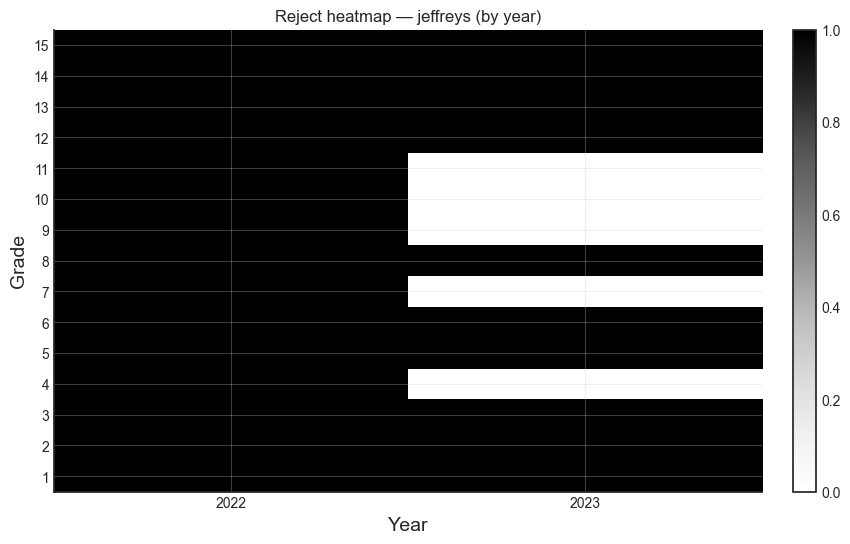

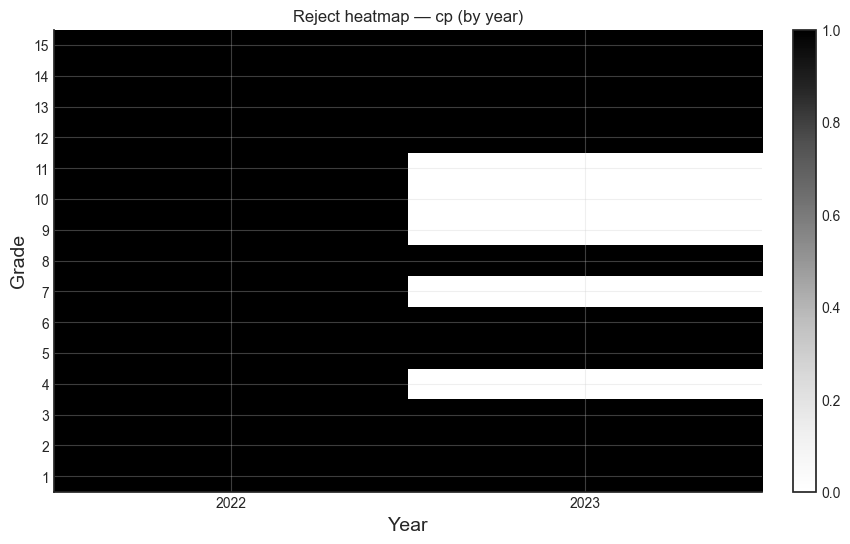

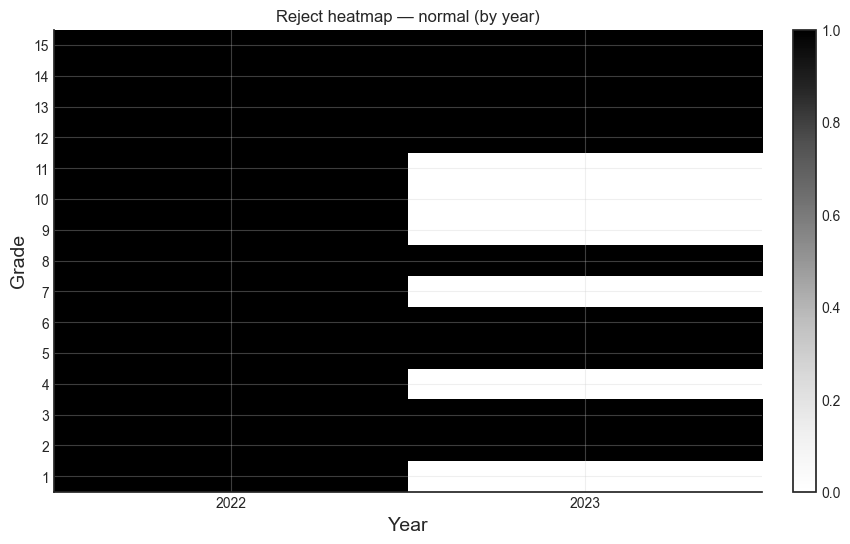

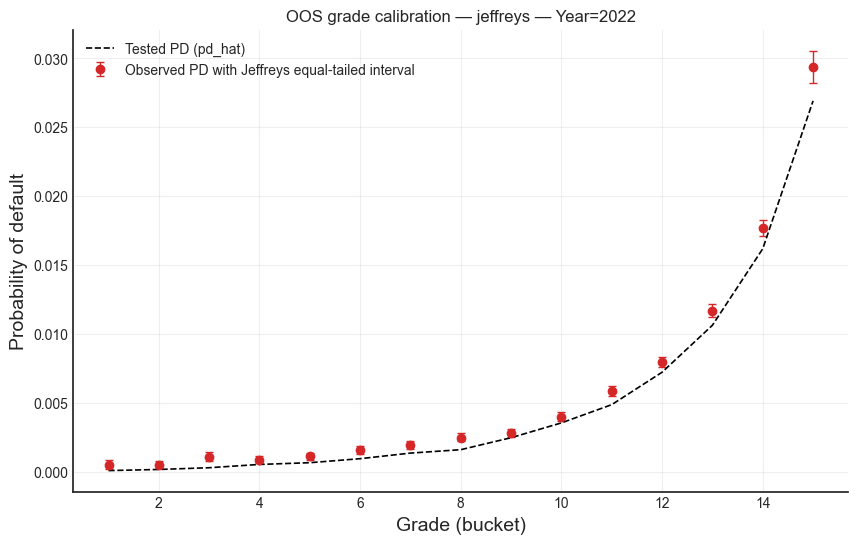

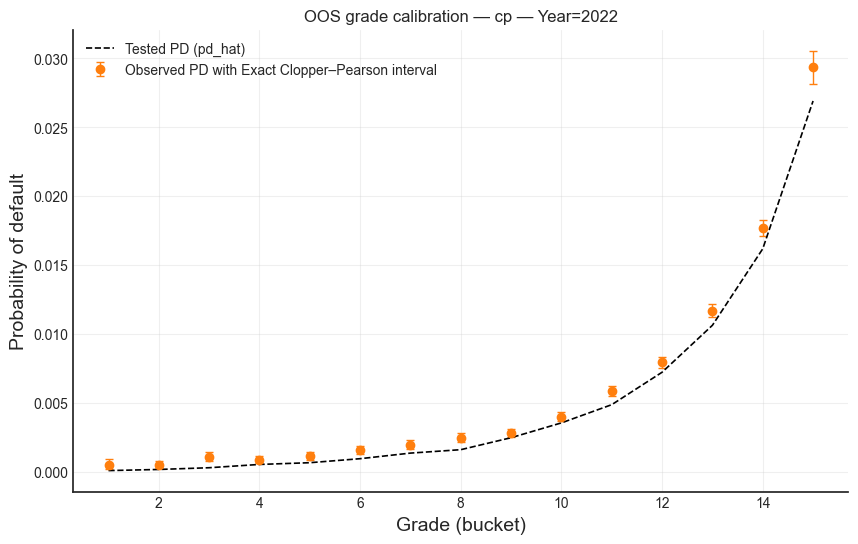

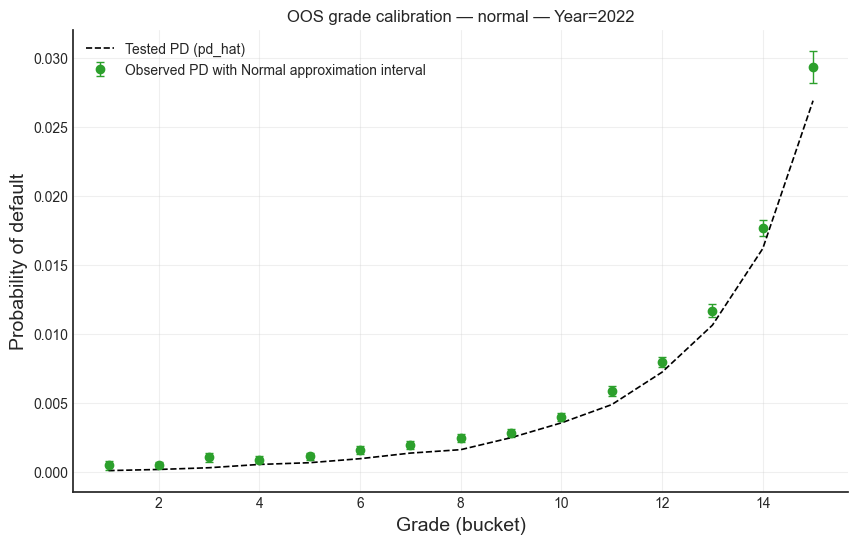

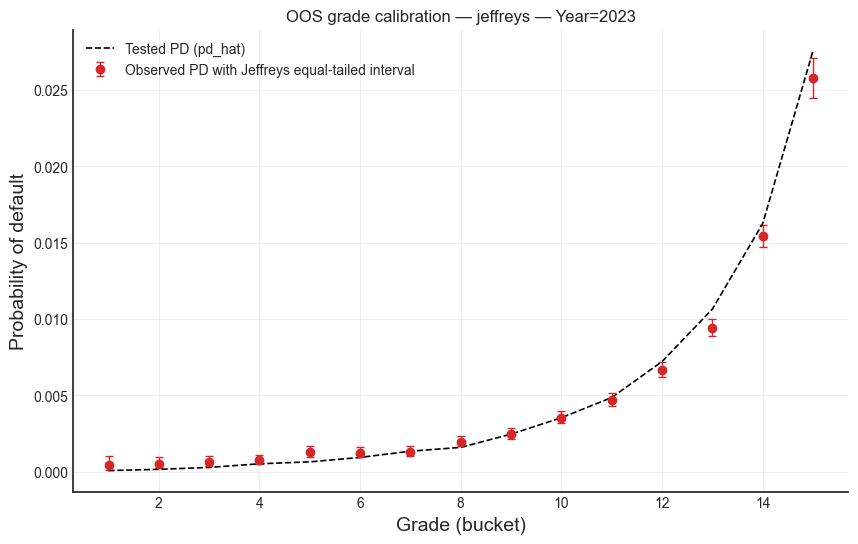

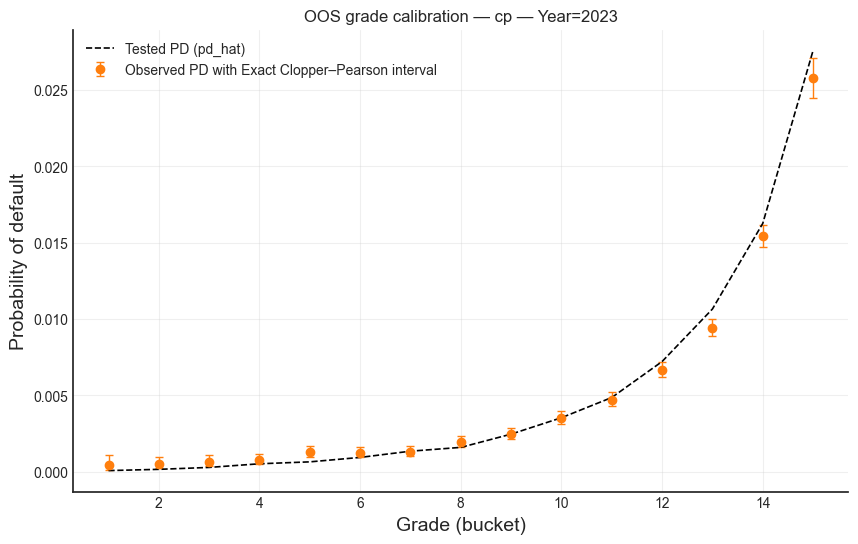

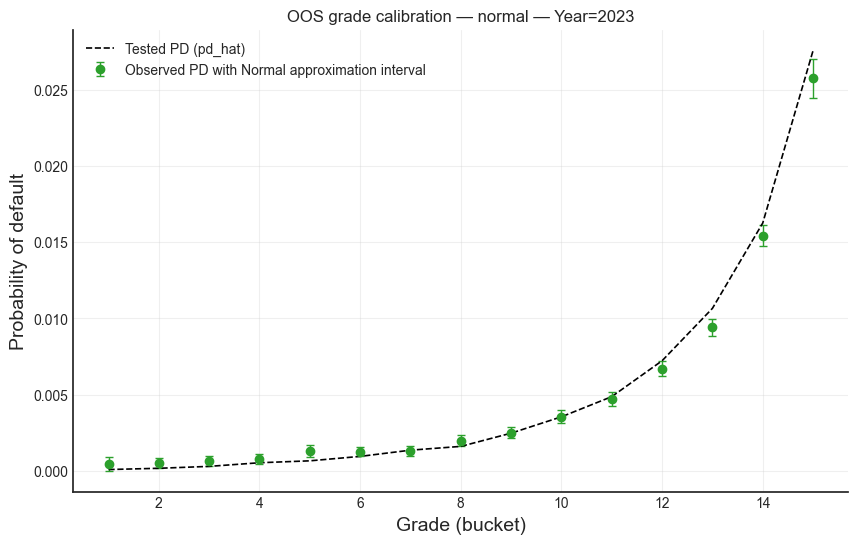

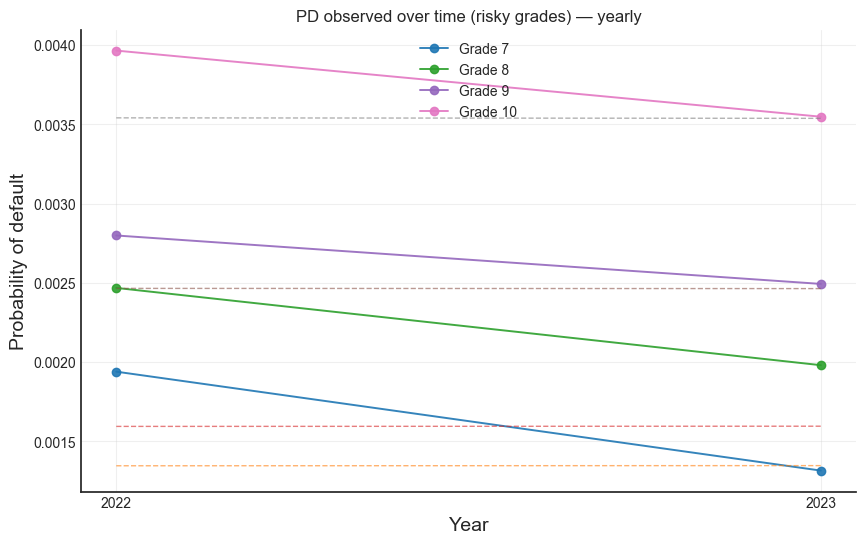

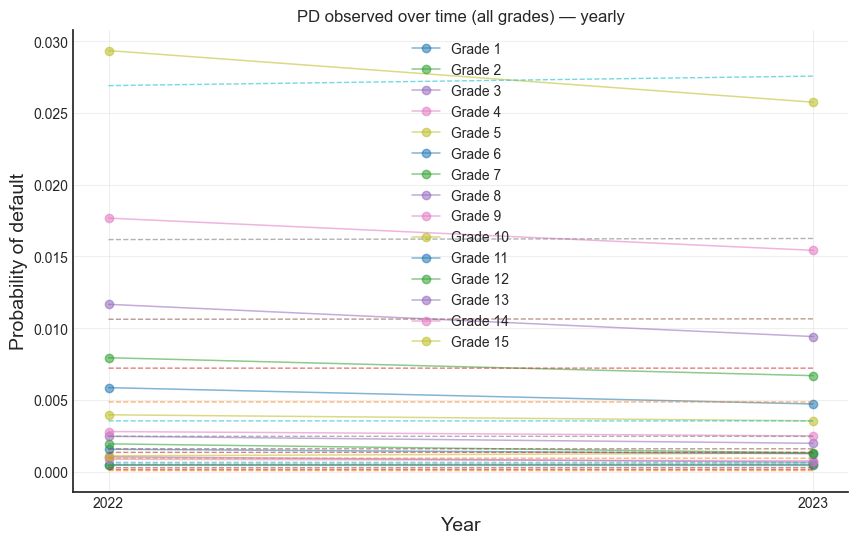

In [23]:
# =========================
# Notebook: OOS grade-level calibration (Jeffreys / Exact CP / Normal)
# ✅ Aggregation PAR ANNÉE (au lieu de rolling quarters)
# - Works even if notebook is in ./notebook/
# - Fixes sys.path so `from experiments...` imports work
# - Robust paths by auto-detecting project root
# =========================

# -------------------------
# 0) Make project imports work from /notebook
# -------------------------
from __future__ import annotations

from pathlib import Path
import sys

def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    markers = {"pyproject.toml", "Makefile", ".git"}
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("Notebook CWD:", Path.cwd())
print("Detected ROOT:", ROOT)
print("sys.path[0]:", sys.path[0])


# -------------------------
# 1) Imports (project + libs)
# -------------------------
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from experiments.stats.intervals import (
    jeffreys_alpha2,
    exact_cp,
    approx_normal,
)

from experiments.plots.style import (
    new_figure,
    finalize_ax,
    save_figure,
    METHOD_STYLES,
)


# -------------------------
# 2) CONFIG
# -------------------------
CONF_LEVEL = 0.95

# Data paths (relative to project root)
VAL_PATH = ROOT / "data" / "processed" / "scored" / "validation_scored.parquet"
OOS_PATH = ROOT / "data" / "processed" / "scored" / "oos_scored.parquet"

# Bucket stats JSON (PD TTC by bucket)
BUCKET_STATS_PATH = ROOT / "artifacts" / "model_from_binned" / "bucket_stats.json"
BUCKET_SECTION = "validation"  # or "train", "train_raw", "validation", "train_val_longrun"

# Columns in scored data
VINTAGE_COL = "vintage"      # typically "YYYYQn"
GRADE_COL = "grade"
DEFAULT_COL = "default_12m"

# per-loan PD column in scored parquet (in your training script it's "pd")
PD_HAT_COL = "pd"            # change to "pd_hat" if that's your column

# Choose what PD to test: "pd_hat" (preferred) or "pd_ttc"
TEST_TARGET = "pd_hat"       # will fallback to pd_ttc if pd_hat missing

# Time aggregation
TIME_COL = "year"            # we will create this
TIME_LABEL = "Year"

print("VAL exists:", VAL_PATH.exists())
print("OOS exists:", OOS_PATH.exists())
print("BUCKET exists:", BUCKET_STATS_PATH.exists())


# -------------------------
# 3) Helpers
# -------------------------
def _safe_int_grade(x) -> int:
    try:
        return int(float(x))
    except Exception:
        return int(x)

def load_bucket_pd_map(bucket_stats_path: Path, section: str) -> dict[int, float]:
    with open(bucket_stats_path, "r") as f:
        data = json.load(f)
    if section not in data:
        raise KeyError(f"'{section}' not in bucket_stats.json. Available keys: {list(data.keys())}")
    return {int(e["bucket"]): float(e["pd"]) for e in data[section]}

def add_year_from_vintage(df: pd.DataFrame, vintage_col: str = "vintage") -> pd.Series:
    """
    Extract year from vintage like "2021Q3" -> 2021.
    Robust: takes first 4 digits found.
    """
    s = df[vintage_col].astype(str)
    year = s.str.extract(r"(\d{4})", expand=False)
    year = pd.to_numeric(year, errors="coerce").astype("Int64")
    return year

def build_year_grade_table(
    df: pd.DataFrame,
    vintage_col: str,
    grade_col: str,
    default_col: str,
    pd_hat_col: str | None,
    pd_ttc_map: dict[int, float] | None,
    time_col: str = "year",
) -> pd.DataFrame:
    """
    Build year×grade table with:
      - n, d, pd_obs = d/n
      - pd_hat = mean per-loan PD (if available), else NaN
      - pd_ttc = PD from bucket_stats (if provided)
    """
    x = df.copy()

    if vintage_col not in x.columns:
        raise KeyError(f"'{vintage_col}' not in df.columns. Available: {x.columns.tolist()}")

    x[time_col] = add_year_from_vintage(x, vintage_col=vintage_col)
    x = x.dropna(subset=[time_col]).copy()
    x[time_col] = x[time_col].astype(int)

    x[grade_col] = x[grade_col].map(_safe_int_grade)

    use_pd_hat = pd_hat_col is not None and pd_hat_col in x.columns

    base_cols = [time_col, grade_col, default_col]
    if use_pd_hat:
        base_cols.append(pd_hat_col)

    x = x[base_cols].copy()

    if use_pd_hat:
        agg = x.groupby([time_col, grade_col], as_index=False).agg(
            n=(default_col, "count"),
            d=(default_col, "sum"),
            pd_hat=(pd_hat_col, "mean"),
        )
    else:
        agg = x.groupby([time_col, grade_col], as_index=False).agg(
            n=(default_col, "count"),
            d=(default_col, "sum"),
        )
        agg["pd_hat"] = np.nan

    agg["pd_obs"] = agg["d"] / agg["n"]

    if pd_ttc_map is not None:
        agg["pd_ttc"] = agg[grade_col].map(pd_ttc_map).astype(float)
    else:
        agg["pd_ttc"] = np.nan

    return agg.sort_values([time_col, grade_col]).reset_index(drop=True)

def add_intervals_and_tests(
    df_tg: pd.DataFrame,
    confidence_level: float,
    test_target: str = "pd_hat",
) -> pd.DataFrame:
    """
    Add LB/UB/length/reject for methods: jeffreys, cp, normal.
    reject = target PD not in [LB,UB]
    """
    if test_target not in df_tg.columns:
        raise KeyError(f"test_target='{test_target}' not found in df columns: {df_tg.columns.tolist()}")

    out = df_tg.copy()
    n = out["n"].to_numpy(dtype=int)
    d = out["d"].to_numpy(dtype=int)
    p0 = out[test_target].to_numpy(dtype=float)

    lb_j, ub_j, lb_cp, ub_cp, lb_n, ub_n = [], [], [], [], [], []

    for ni, di in zip(n, d):
        a, b = jeffreys_alpha2(ni, di, confidence_level)
        lb_j.append(a); ub_j.append(b)

        a, b = exact_cp(ni, di, confidence_level)
        lb_cp.append(a); ub_cp.append(b)

        a, b = approx_normal(ni, di, confidence_level)
        lb_n.append(max(0.0, a))
        ub_n.append(min(1.0, b))

    lb_j = np.array(lb_j); ub_j = np.array(ub_j)
    lb_cp = np.array(lb_cp); ub_cp = np.array(ub_cp)
    lb_n = np.array(lb_n); ub_n = np.array(ub_n)

    for method, (lb, ub) in {
        "jeffreys": (lb_j, ub_j),
        "cp": (lb_cp, ub_cp),
        "normal": (lb_n, ub_n),
    }.items():
        out[f"lb_{method}"] = lb
        out[f"ub_{method}"] = ub
        out[f"len_{method}"] = ub - lb
        out[f"reject_{method}"] = ~((p0 >= lb) & (p0 <= ub))

    return out

def build_method_summary(df_long: pd.DataFrame, time_col: str) -> pd.DataFrame:
    """
    Summary per time & method:
      - share_grades_rejected
      - share_exposure_rejected (weighted by n)
      - avg_len_weighted (weighted by n)
    """
    rows = []
    for method in ["jeffreys", "cp", "normal"]:
        for t, g in df_long.groupby(time_col):
            n_tot = float(g["n"].sum())
            rows.append({
                time_col: int(t),
                "method": method,
                "share_grades_rejected": float(g[f"reject_{method}"].mean()),
                "share_exposure_rejected": float(g.loc[g[f"reject_{method}"], "n"].sum() / n_tot) if n_tot > 0 else np.nan,
                "avg_len_weighted": float((g["n"] * g[f"len_{method}"]).sum() / n_tot) if n_tot > 0 else np.nan,
                "n_total": int(n_tot),
            })
    return (
        pd.DataFrame(rows)
        .sort_values([time_col, "method"])
        .reset_index(drop=True)
    )


# -------------------------
# 4) Load + build tables (OOS only by default)
# -------------------------
df_oos = pd.read_parquet(OOS_PATH)

# If you want Val + OOS, uncomment:
# df_val = pd.read_parquet(VAL_PATH)
# df = pd.concat([df_val, df_oos], ignore_index=True)
df = df_oos.copy()

pd_ttc_map = load_bucket_pd_map(BUCKET_STATS_PATH, BUCKET_SECTION) if BUCKET_STATS_PATH.exists() else None

df_tg = build_year_grade_table(
    df,
    vintage_col=VINTAGE_COL,
    grade_col=GRADE_COL,
    default_col=DEFAULT_COL,
    pd_hat_col=PD_HAT_COL,
    pd_ttc_map=pd_ttc_map,
    time_col=TIME_COL,
)

# Choose tested PD
if TEST_TARGET == "pd_hat":
    if "pd_hat" not in df_tg.columns or df_tg["pd_hat"].isna().all():
        TEST_TARGET = "pd_ttc"
        print("Fallback TEST_TARGET -> pd_ttc")
else:
    if TEST_TARGET not in df_tg.columns:
        TEST_TARGET = "pd_ttc"
        print("Fallback TEST_TARGET -> pd_ttc")

df_long = add_intervals_and_tests(df_tg, confidence_level=CONF_LEVEL, test_target=TEST_TARGET)
df_summary = build_method_summary(df_long, time_col=TIME_COL)

display(df_summary.head(30))
display(df_long.head(20))


# -------------------------
# 5) Plots (simulation style)
# -------------------------
def plot_pd_by_grade_one_method(
    df_one_time: pd.DataFrame,
    method: str,
    pd_target_col: str,
    time_value: int,
    show: bool = True,
    save_path: Path | None = None,
):
    """
    For one year:
      - points: pd_obs
      - error bars: [lb_method, ub_method]
      - dashed line: pd_target_col (pd_hat/pd_ttc)
    """
    dfp = df_one_time.sort_values(GRADE_COL).copy()
    x = dfp[GRADE_COL].astype(int).to_numpy()
    y = dfp["pd_obs"].to_numpy(float)
    lb = dfp[f"lb_{method}"].to_numpy(float)
    ub = dfp[f"ub_{method}"].to_numpy(float)
    yhat = dfp[pd_target_col].to_numpy(float)

    yerr = np.vstack([np.maximum(0.0, y - lb), np.maximum(0.0, ub - y)])

    fig, ax = new_figure()

    style = METHOD_STYLES.get(method, {})
    color = style.get("color", None)
    label = style.get("label", method)

    ax.errorbar(
        x, y, yerr=yerr,
        fmt="o", capsize=3, linewidth=1.0,
        color=color,
        label=f"Observed PD with {label} interval",
    )
    ax.plot(
        x, yhat,
        linestyle="--", linewidth=1.2, color="black",
        label=f"Tested PD ({pd_target_col})",
    )

    finalize_ax(
        ax,
        xlabel="Grade (bucket)",
        ylabel="Probability of default",
        title=f"OOS grade calibration — {method} — {TIME_LABEL}={time_value}",
        nominal_level=None,
        add_legend=True,
    )

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)

def plot_reject_heatmap(
    df_long_all: pd.DataFrame,
    method: str,
    time_col: str,
    show: bool = True,
    save_path: Path | None = None,
    title: str | None = None,
):
    """
    Heatmap: grade (y) × year (x), value = reject (0/1).
    """
    tmp = df_long_all.copy()
    tmp[time_col] = tmp[time_col].astype(int)
    tmp[GRADE_COL] = tmp[GRADE_COL].astype(int)

    mat = tmp.pivot(index=GRADE_COL, columns=time_col, values=f"reject_{method}").sort_index()
    mat = mat.reindex(sorted(mat.columns), axis=1)

    Z = mat.fillna(False).astype(int).to_numpy()

    fig, ax = new_figure()
    im = ax.imshow(Z, aspect="auto", origin="lower")

    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(mat.index.tolist())
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(mat.columns.tolist(), rotation=0)

    finalize_ax(
        ax,
        xlabel=TIME_LABEL,
        ylabel="Grade",
        title=title or f"Reject heatmap (method={method})",
        nominal_level=None,
        add_legend=False,
    )
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)

# Heatmaps across years
for method in ["jeffreys", "cp", "normal"]:
    plot_reject_heatmap(
        df_long,
        method,
        time_col=TIME_COL,
        show=True,
        title=f"Reject heatmap — {method} (by year)",
    )

# PD-by-grade for a few years (avoid spamming)
some_years = sorted(df_long[TIME_COL].unique())[:3]
for y in some_years:
    sub = df_long[df_long[TIME_COL] == y]
    for method in ["jeffreys", "cp", "normal"]:
        plot_pd_by_grade_one_method(sub, method, pd_target_col=TEST_TARGET, time_value=int(y), show=True)


# -------------------------
# 6) Plot: evolution over time for multiple grades (yearly)
# -------------------------
def plot_grade_evolution_over_time(
    df_long: pd.DataFrame,
    method: str = "jeffreys",
    y: str = "pd_obs",                 # "pd_obs" or "pd_hat" or "pd_ttc"
    pd_target_col: str = "pd_hat",     # dashed per grade (optional)
    grades: list[int] | None = None,
    show_intervals: bool = False,
    alpha_lines: float = 0.8,
    lw: float = 1.2,
    save_path: Path | None = None,
    show: bool = True,
    title: str | None = None,
):
    df = df_long.copy()
    years = sorted(df[TIME_COL].astype(int).unique().tolist())

    if grades is None:
        grades = sorted(df[GRADE_COL].astype(int).unique().tolist())

    df = df[df[GRADE_COL].astype(int).isin(grades)].copy()

    fig, ax = new_figure()

    x = np.arange(len(years))
    ax.set_xticks(x)
    ax.set_xticklabels([str(y) for y in years], rotation=0)

    for g in grades:
        sub = df[df[GRADE_COL].astype(int) == g].sort_values(TIME_COL)

        # align to all years
        sub = sub.set_index(TIME_COL).reindex(years)
        y_vals = sub[y].to_numpy(float)

        ax.plot(
            x, y_vals,
            marker="o",
            linewidth=lw,
            alpha=alpha_lines,
            label=f"Grade {g}",
        )

        if pd_target_col in sub.columns and not pd.isna(sub[pd_target_col]).all():
            ax.plot(
                x,
                sub[pd_target_col].to_numpy(float),
                linestyle="--",
                linewidth=1.0,
                alpha=0.6,
            )

        if show_intervals:
            lb_col = f"lb_{method}"
            ub_col = f"ub_{method}"
            if lb_col in sub.columns and ub_col in sub.columns:
                lb = sub[lb_col].to_numpy(float)
                ub = sub[ub_col].to_numpy(float)
                ax.fill_between(x, lb, ub, alpha=0.08)

    finalize_ax(
        ax,
        xlabel=TIME_LABEL,
        ylabel="Probability of default",
        title=title or f"Grade-level evolution over time ({y}) — yearly",
        nominal_level=None,
        add_legend=True,
    )

    if save_path is not None:
        save_figure(fig, save_path)
    elif show:
        plt.show()
        plt.close(fig)

# Example: risky grades (7-10)
plot_grade_evolution_over_time(
    df_long,
    method="jeffreys",
    y="pd_obs",
    pd_target_col=TEST_TARGET,
    grades=[7, 8, 9, 10],
    show_intervals=False,
    alpha_lines=0.9,
    lw=1.4,
    title="PD observed over time (risky grades) — yearly",
)

# Example: all grades
plot_grade_evolution_over_time(
    df_long,
    method="jeffreys",
    y="pd_obs",
    pd_target_col=TEST_TARGET,
    grades=None,
    show_intervals=False,
    alpha_lines=0.55,
    lw=1.1,
    title="PD observed over time (all grades) — yearly",
)


# -------------------------
# 7) (Optional) Export CSV outputs (relative to notebook)
# -------------------------
# OUT_DIR = Path("./outputs_oos_grade_calibration_yearly")
# OUT_DIR.mkdir(parents=True, exist_ok=True)
# df_long.to_csv(OUT_DIR / "oos_grade_calibration_long_yearly.csv", index=False)
# df_summary.to_csv(OUT_DIR / "oos_grade_calibration_summary_yearly.csv", index=False)
# print("Saved CSVs to:", OUT_DIR.resolve())


In [14]:
df_pooled = pd.read_parquet("../data/processed/default_labels/window=12m/pooled.parquet")
df_oos = pd.read_parquet("../data/processed/default_labels/window=12m/oos.parquet")

print(f"Shape of the data :")
print(f"Shape of train+validation :{df_pooled.shape}")
print(f"Shape of OOS :{df_oos.shape}")



print(f"\n Columns :")
print(df_pooled.columns)

Shape of the data :
Shape of train+validation :(27315191, 37)
Shape of OOS :(2512504, 37)

 Columns :
Index(['credit_score', 'first_payment_date', 'first_time_homebuyer_flag',
       'maturity_date', 'msa_md', 'mi_percent', 'number_of_units',
       'occupancy_status', 'original_cltv', 'original_dti', 'original_upb',
       'original_ltv', 'original_interest_rate', 'channel', 'ppm_flag',
       'amortization_type', 'property_state', 'property_type', 'postal_code',
       'loan_sequence_number', 'loan_purpose', 'original_loan_term',
       'number_of_borrowers', 'seller_name', 'servicer_name',
       'super_conforming_flag', 'pre_relief_refi_loan_seq_number',
       'special_eligibility_program', 'relief_refinance_indicator',
       'property_valuation_method', 'interest_only_indicator',
       'mi_cancellation_indicator', 'default_12m', '__file_quarter', 'vintage',
       'window', 'quarter'],
      dtype='object')


In [15]:
key = "loan_sequence_number"
print("rows:", len(df_pooled))
print("unique loans:", df_pooled[key].nunique())
print("dup rate:", 1 - df_pooled[key].nunique()/len(df_pooled))

# idem par year/grade
tmp = df_pooled.copy()
tmp["year"] = tmp["vintage"].astype(str).str.extract(r"(\d{4})", expand=False).astype(int)
g = tmp.groupby(["year","grade"]).agg(rows=("default_12m","size"),
                                      uniq_loans=(key,"nunique")).reset_index()
g["dup_rate"] = 1 - g["uniq_loans"]/g["rows"]
display(g.sort_values("dup_rate", ascending=False).head(20))


rows: 27315191
unique loans: 27315191
dup rate: 0.0


KeyError: 'grade'